# Análise da comparação contexto e as palavras das sentenças do SQUAD 2 P(2,5%) EN 

Realiza a análise da comparação das palavras das sentenças dos documentos originais e perturbados com o contexto dos dados do SQUAD2 P(2,5%) EN utilizando o arquivo:

- `comparacao_contexto_pX_kY.zip`

No nome do arquivo `comparacao_palavra_pX_kY.zip`, X é o número de documentos perturbados e Y o valor de top K predições. 




# 1 Preparação do ambiente

Preparação do ambiente para execução do script.

## 1.1 Tempo inicial de processamento

In [ ]:
# Import das bibliotecas.
import time
import datetime

# Marca o tempo de início do processamento
inicio_processamento = time.time()

## 1.2 Funções e classes auxiliares

Verifica se existe o diretório cohebert no diretório corrente.   


In [ ]:
# Import das bibliotecas.
import os # Biblioteca para manipular arquivos

# ============================  
def verificaDiretorioCoheBERT():
    """
      Verifica se existe o diretório cohebert no diretório corrente.    
    """
    
    # Verifica se o diretório existe
    if not os.path.exists(DIRETORIO_COHEBERT):  
        # Cria o diretório
        os.makedirs(DIRETORIO_COHEBERT)
        logging.info("Diretório Cohebert criado: {}".format(DIRETORIO_COHEBERT))
    
    return DIRETORIO_COHEBERT

Realiza o download e um arquivo

In [ ]:
# Import das bibliotecas.
import requests # Biblioteca de download
from tqdm.notebook import tqdm as tqdm_notebook # Biblioteca para barra de progresso

def downloadArquivo(url_arquivo, nome_arquivo_destino):
    """    
      Realiza o download de um arquivo de uma url em salva em nome_arquivo_destino.
    
      Parâmetros:
        `url_arquivo` - URL do arquivo a ser feito download.      
        `nome_arquivo_destino` - Nome do arquivo a ser salvo.      
    """
    
    # Verifica se existe o diretório base
    DIRETORIO_COHEBERT = verificaDiretorioCoheBERT()
    
    # Realiza o download de um arquivo em uma url
    data = requests.get(url_arquivo, stream=True)
    
    # Verifica se o arquivo existe
    if data.status_code != 200:
        logging.info("Exceção ao tentar realizar download {}. Response {}.".format(url_arquivo, data.status_code))
        data.raise_for_status()
        return

    # Recupera o nome do arquivo a ser realizado o download    
    nome_arquivo = nome_arquivo_destino.split("/")[-1]  

    # Define o nome e caminho do arquivo temporário    
    nome_arquivo_temporario = DIRETORIO_COHEBERT + "/" + nome_arquivo + "_part"
    
    logging.info("Download do arquivo: {}.".format(nome_arquivo_destino))
    
    # Baixa o arquivo
    with open(nome_arquivo_temporario, "wb") as arquivo_binario:        
        tamanho_conteudo = data.headers.get("Content-Length")        
        total = int(tamanho_conteudo) if tamanho_conteudo is not None else None
        # Barra de progresso de download
        progresso_bar = tqdm_notebook(unit="B", total=total, unit_scale=True)                
        # Atualiza a barra de progresso
        for chunk in data.iter_content(chunk_size=1024):        
            if chunk:                
                progresso_bar.update(len(chunk))
                arquivo_binario.write(chunk)
    
    # Renomeia o arquivo temporário para o arquivo definitivo
    os.rename(nome_arquivo_temporario, nome_arquivo_destino)
    
    # Fecha a barra de progresso.
    progresso_bar.close()

Remove tags de um documento

In [ ]:
def remove_tags(documento):
    """
      Remove tags de um documento
    """
    
    import re

    documento_limpo = re.compile("<.*?>")
    return re.sub(documento_limpo, "", documento)

Funções auxiliares de arquivos

In [ ]:
def carregar(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como um único parágrafo(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.  
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)
    
    paragrafo = ""
    for linha in arquivo:
        linha = linha.splitlines()
        linha = " ".join(linha)
        # Remove as tags existentes no final das linhas
        linha = remove_tags(linha)
        if linha != "":
          paragrafo = paragrafo + linha.strip() + " "
    
    # Fecha o arquivo
    arquivo.close()

    # Remove os espaços em branco antes e depois do parágrafo
    return paragrafo.strip()

In [ ]:
def carregarLista(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como uma lista de sentenças(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.   
        `encoding` - Codificação dos caracteres do arquivo.
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)
    
    sentencas = []
    for linha in arquivo:        
        linha = linha.splitlines()
        linha = " ".join(linha)
        linha = remove_tags(linha)
        if linha != "":
          sentencas.append(linha.strip())
    
    # Fecha o arquivo
    arquivo.close()

    return sentencas 

In [ ]:
def salvar(nome_arquivo,texto):                       
    """
      Salva um texto em um arquivo.
     
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser salvo.
        `texto` - Texto a ser salvo.     
    """

    arquivo = open(nome_arquivo, "w")
    arquivo.write(str(texto))
    arquivo.close()

Função auxiliar para formatar o tempo como `hh: mm: ss`

In [ ]:
# Import das bibliotecas.
import time
import datetime

def formataTempo(tempo):
    """
      Pega a tempo em segundos e retorna uma string hh:mm:ss
    """
    # Arredonda para o segundo mais próximo.
    tempo_arredondado = int(round((tempo)))
    
    # Formata como hh:mm:ss
    return str(datetime.timedelta(seconds=tempo_arredondado))    

Classe(ModelArguments) de definição dos parâmetros do modelo

In [ ]:
# Import das bibliotecas.
from dataclasses import dataclass, field
from typing import Dict, Optional
from typing import List

@dataclass
class ModeloArgumentosMedida:
    max_seq_len: Optional[int] = field(
        default=None,
        metadata={"help": "max seq len"},
    )    
    pretrained_model_name_or_path: str = field(
        default="neuralmind/bert-base-portuguese-cased",
        metadata={"help": "nome do modelo pré-treinado do BERT."},
    )
    modelo_spacy: str = field(
        default="pt_core_news_lg",
        metadata={"help": "nome do modelo do spaCy."},
    )
    versao_modelo_spacy: str = field(
        default="-3.2.0",
        metadata={"help": "versão do nome do modelo no spaCy."},
    )
    sentenciar_documento: bool = field(
        default=True,
        metadata={"help": "Dividir o documento em sentenças(frases)."},
    )
    do_lower_case: bool = field(
        default=False,
        metadata={"help": "define se o texto do modelo deve ser todo em minúsculo."},
    )    
    output_attentions: bool = field(
        default=False,
        metadata={"help": "habilita se o modelo retorna os pesos de atenção."},
    )
    output_hidden_states: bool = field(
        default=False,
        metadata={"help": "habilita gerar as camadas ocultas do modelo."},
    )
    usar_mcl_ajustado : bool = field(
        default=False,
        metadata={"help": "habilita o carragamento de mcl ajustado."},
    )
    documentos_perturbados: int = field(
        default="1",
        metadata={"help": "Quantidade de documentos a serem perturbados a partir do original."},
    )
    top_k_predicao: int = field(
        default="100",
        metadata={"help": "Quantidade de palavras a serem recuperadas mais próximas da máscara."},
    ) 

Biblioteca de limpeza de tela


In [ ]:
# Import das bibliotecas.
from IPython.display import clear_output

## 1.3 Tratamento de logs

In [ ]:
# Import das bibliotecas.
import logging # Biblioteca de logging

# Formatando a mensagem de logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s")

logger = logging.getLogger()
logger.setLevel(logging.INFO)

## 1.4 Identificando o ambiente Colab

In [ ]:
# Import das bibliotecas.
import sys # Biblioteca para acessar módulos do sistema

# Se estiver executando no Google Colaboratory
# Retorna true ou false se estiver no Google Colaboratory
IN_COLAB = "google.colab" in sys.modules

## 1.5 Colaboratory

Usando Colab GPU para Treinamento


Uma GPU pode ser adicionada acessando o menu e selecionando:

`Edit -> Notebook Settings -> Hardware accelerator -> (GPU)`

Em seguida, execute a célula a seguir para confirmar que a GPU foi detectada.

In [ ]:
# Import das bibliotecas.
import tensorflow as tf

# Recupera o nome do dispositido da GPU.
device_name = tf.test.gpu_device_name()

# O nome do dispositivo deve ser parecido com o seguinte:
if device_name == "/device:GPU:0":
    logging.info("Encontrei GPU em: {}".format(device_name))
else:
    logging.info("Dispositivo GPU não encontrado")
    #raise SystemError("Dispositivo GPU não encontrado")

Nome da GPU

Para que a torch use a GPU, precisamos identificar e especificar a GPU como o dispositivo. Posteriormente, em nosso ciclo de treinamento, carregaremos dados no dispositivo.

Vale a pena observar qual GPU você recebeu. A GPU Tesla P100 é muito mais rápido que as outras GPUs, abaixo uma lista ordenada:
- 1o Tesla P100
- 2o Tesla T4
- 3o Tesla P4 (Não tem memória para execução 4 x 8, somente 2 x 4)
- 4o Tesla K80 (Não tem memória para execução 4 x 8, somente 2 x 4)

In [ ]:
# Import das bibliotecas.
import torch # Biblioteca para manipular os tensores

def getDeviceGPU():
    """
    Retorna um dispositivo de GPU se disponível ou CPU.
    
    Retorno:
    `device` - Um device de GPU ou CPU.       
    """
        
    # Se existe GPU disponível.
    if torch.cuda.is_available():
        
        # Diz ao PyTorch para usar GPU.    
        device = torch.device("cuda")
        
        logging.info("Existem {} GPU(s) disponíveis.".format(torch.cuda.device_count()))
        logging.info("Iremos usar a GPU: {}.".format(torch.cuda.get_device_name(0)))

    # Se não.
    else:        
        logging.info("Sem GPU disponível, usando CPU.")
        device = torch.device("cpu")
        
    return device

In [ ]:
device = getDeviceGPU()

Conecta o modelo ao device

In [ ]:
# Import das bibliotecas.
import torch # Biblioteca para manipular os tensores

def conectaGPU(model, device):
    """
      Conecta um modelo BERT a GPU.

      Parâmetros:
        `model` - Um modelo BERT carregado.       
        `device` - Um device de GPU.     
    
      Retorno:
        `model` - Um objeto model BERT conectado a GPU.     
    """
    # Associa a GPU ao modelo.
    model.to(device)

    # Se existe GPU disponível.
    if torch.cuda.is_available():    
        # Diga ao pytorch para rodar este modelo na GPU.
        logging.info("Pytorch rodando o modelo na GPU.")
        model.cuda()
        
    else:
        logging.info("Pytorch rodando sem GPU.")

    return model

Memória

Memória disponível no ambiente

In [ ]:
# Import das bibliotecas.
from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
logging.info("Seu ambiente de execução tem {: .1f} gigabytes de RAM disponível\n".format(ram_gb))

if ram_gb < 20:
  logging.info("Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> \"Alterar tipo de tempo de execução\"")
  logging.info("e selecione High-RAM. Então, execute novamente está célula")
else:
  logging.info("Você está usando um ambiente de execução de memória RAM alta!")

## 1.6 Monta uma pasta no google drive para carregar os arquivos de dados.

In [ ]:
# Import das bibliotecas.
from google.colab import drive

# Monta o drive na pasta especificada
drive.mount("/content/drive")     

Mounted at /content/drive


## 1.7 Instalação do wandb

Instalação

In [ ]:
!pip install --upgrade wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.3 MB/s 
     |████████████████████████████████| 181 kB 40.8 MB/s 
     |████████████████████████████████| 157 kB 38.4 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 157 kB 49.5 MB/s 
     |████████████████████████████████| 157 kB 47.7 MB/s 
     |████████████████████████████████| 157 kB 49.6 MB/s 
     |████████████████████████████████| 157 kB 49.1 MB/s 
     |████████████████████████████████| 156 kB 50.2 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=490b9aa6ef97fc7cde5a1d74d70f3664a5f1aeab85aa1b4cd298520a44ea5d14
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


# 2 Parametrização

## Gerais

In [ ]:
# Definição dos parâmetros a serem avaliados
#Quantidade de documentos a serem perturbados a partir do original.
DOCUMENTOS_PERTURBADOS = 1

#Quantidade de palavras a serem recuperadas mais próximas da máscara.
TOP_K_PREDICAO = 1

## Específicos

Parâmetros do modelo

In [ ]:
# Definição dos parâmetros do Modelo.
model_args = ModeloArgumentosMedida(     
    max_seq_len = 512,    
    
    pretrained_model_name_or_path = "bert-large-cased",
    #pretrained_model_name_or_path = "bert-base-cased"
    #pretrained_model_name_or_path = "neuralmind/bert-large-portuguese-cased",
    #pretrained_model_name_or_path = "neuralmind/bert-base-portuguese-cased",    
    #pretrained_model_name_or_path = "bert-base-multilingual-cased",
    #pretrained_model_name_or_path = "bert-base-multilingual-uncased",

    modelo_spacy = "en_core_web_lg",
    #modelo_spacy = "en_core_web_md",
    #modelo_spacy = "en_core_web_sm",
    #modelo_spacy = "pt_core_news_lg",
    #modelo_spacy = "pt_core_news_md",
    #modelo_spacy = "pt_core_news_sm",

    versao_modelo_spacy = "3.2.0",
    sentenciar_documento = False,
    do_lower_case = False, # default True  
    output_attentions = False, # default False
    output_hidden_states = True, # default False, se True retorna todas as camadas do modelo para as operações de soma e concatenação
    usar_mcl_ajustado = False, # Especifica se deve ser carregado um MCL ajustado ou pré-treinado. Necessário especificar o tipo do modelo em pretrained_model_name_or_path. 
    documentos_perturbados = DOCUMENTOS_PERTURBADOS, # Quantidade de documentos a serem perturbados a partir do original.
    top_k_predicao = TOP_K_PREDICAO, # Conjunto de valores: 1, 10, 100, 500 e 1000. Quantidade de palavras a serem recuperadas mais próximas da máscara.
)

## Nome do diretório dos arquivos de dados

In [ ]:
# Diretório do cohebert
DIRETORIO_COHEBERT = "SQUAD2_P_EN"

## Define o caminho para os arquivos de dados

In [ ]:
# Diretório local para os arquivos pré-processados
DIRETORIO_LOCAL = "/content/" + DIRETORIO_COHEBERT + "/"

# Diretório no google drive com os arquivos pré-processados
DIRETORIO_DRIVE = "/content/drive/MyDrive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/"

## Configuração do tamanho da fonte dos gráficos

In [ ]:
# Import das bibliotecas.
import matplotlib

TAMANHO_FONTE = 16
matplotlib.rc("font", size=TAMANHO_FONTE)          # Controla o tamanho do do texto default
matplotlib.rc("axes", titlesize=TAMANHO_FONTE)     # Tamanho da fonte do eixo do título
matplotlib.rc("axes", labelsize=TAMANHO_FONTE)     # Tamanho da fonte dos rótulos do eixo x e y
matplotlib.rc("xtick", labelsize=TAMANHO_FONTE-2)    # Tamanho da fonte das marcações do eixo y
matplotlib.rc("ytick", labelsize=TAMANHO_FONTE)    # Tamanho da fonte dos marcações do eixo x
matplotlib.rc("legend", fontsize=TAMANHO_FONTE-2)  # Tamanho da fonte da legenda
matplotlib.rc("figure", titlesize=TAMANHO_FONTE)   # Tamanho da fonte do título da figura

# 3 Estatísticas comparação do contexto com as palavras



## 3.1 Carregamento dos arquivos de dados originais

### 3.1.1 Especifica os nomes dos arquivos de dados



In [ ]:
# Nome do arquivo
NOME_ARQUIVO_ORIGINAL = "original.csv"
NOME_ARQUIVO_ORIGINAL_COMPACTADO = "original.zip"
NOME_ARQUIVO_ORIGINAL_POS = "originalpos.csv"
NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO = "originalpos.zip"

NOME_ARQUIVO_PERTURBADO = "perturbado_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".csv"
NOME_ARQUIVO_PERTURBADO_COMPACTADO = "perturbado_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".zip"
NOME_ARQUIVO_PERTURBADO_POS = "perturbadopos_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".csv"
NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO = "perturbadopos_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".zip"

### 3.1.2 Cria o diretório local para receber os dados

In [ ]:
# Import das bibliotecas.
import os

# Cria o diretório para receber os arquivos Originais e Permutados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):  
    # Cria o diretório
    os.makedirs(dirbase)    
    logging.info("Diretório criado: {}".format(dirbase))
else:    
    logging.info("Diretório já existe: {}".format(dirbase))

### 3.1.3 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  logging.info("Terminei a cópia!")

Descompacta os arquivos.

Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens 
*   `-d` Diretório de destino


In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"
  
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Terminei a descompactação!")

### 3.1.4 Carregamento das lista com os dados dos arquivos originais

#### Carrega o arquivo dos dados originais e POS

In [ ]:
#Biblioteca
import pandas as pd

# Abre o arquivo e retorna o DataFrame
lista_documentos_originais = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL, sep=";", encoding="UTF-8")
lista_documentos_originais_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
logging.info("TERMINADO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

In [ ]:
lista_documentos_originais.sample(5)

id  \
959  570a7d566d058f1900182eab   
130  571cc6f85efbb31900334de5   
185  572efd66cb0c0d14000f16cd   
215  56cebef6aab44d1400b8899b   
372  571df47eb64a571400c71e24   

                                             sentencas  \
959  ['What technology has allowed for research int...   
130          ['What is the clarity of liquid oxygen?']   
185  ['The last tsar of Russia, Nicholas ll encount...   
215           ['How many schools were reconstructed?']   
372       ['Where did most Chinese men enter the US?']   

                                             documento  respondivel  
959  What technology has allowed for research into ...            1  
130              What is the clarity of liquid oxygen?            1  
185  The last tsar of Russia, Nicholas ll encounter...            1  
215               How many schools were reconstructed?            1  
372           Where did most Chinese men enter the US?            1

In [ ]:
# Corrige os tipos dos dados da lista agrupada
tipos = {"id": str}

lista_documentos_originais = lista_documentos_originais.astype(tipos)

In [ ]:
lista_documentos_originais_pos.sample(5)

id  \
1293  5ad19089645df0001a2d1f8e   
277   5acf8ff377cf76001a685279   
1340  5725f0d789a1e219009ac0c4   
1128  5acff7c077cf76001a68669e   
6     57326c5ae99e3014001e6798   

                                          pos_documento  
1293  [[['In', 'what', 'year', 'was', 'a', 'new', 't...  
277   [[['Where', 'is', 'the', 'start', 'capacitor',...  
1340  [[['What', 'American', 'professional', 'baseba...  
1128  [[['Which', 'lands', 'were', 'primarily', 'pop...  
6     [[['Who', 'made', 'a', 'film', 'called', "'", ...

In [ ]:
# Corrige os tipos dos dados da lista agrupada
tipos = {"id": str}

lista_documentos_originais_pos = lista_documentos_originais_pos.astype(tipos)

#### Corrigir os tipos de colunas dos dados originais e POS

Em dados originais:
- coluna 1 - `sentenças` carregadas do arquivo vem como string e não como lista.

Em dados originais pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [ ]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

# Verifica se o tipo da coluna não é list e converte
lista_documentos_originais["sentencas"] = lista_documentos_originais["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

lista_documentos_originais_pos["pos_documento"] = lista_documentos_originais_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

logging.info("TERMINADO CORREÇÃO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
logging.info("TERMINADO CORREÇÃO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

#### Criando dados indexados originais

In [ ]:
# Faz uma cópia da lista não indexada
lista_documentos_originais_indexado = lista_documentos_originais.copy()

# Expecifica o(s) campo(s) indexado(s)
lista_documentos_originais_indexado.set_index(["id"], inplace=True)
lista_documentos_originais_indexado.head()

sentencas  \
id                                                                            
5a8d89b5df8bba001a0f9afb  [Link's Edna form is faster than what other fo...   
5acfa4e977cf76001a6856da   [What two ministers fought for power uner Anne?]   
5ad19f40645df0001a2d213b  [What did Irving Langmuir find that would incr...   
56ce66aeaab44d1400b8875a  [In what year was the crystalline silicon sola...   
5acdabd307355d001abf48f0  [Since which year has the idea of a tunnel thr...   

                                                                  documento  \
id                                                                            
5a8d89b5df8bba001a0f9afb   Link's Edna form is faster than what other form?   
5acfa4e977cf76001a6856da     What two ministers fought for power uner Anne?   
5ad19f40645df0001a2d213b  What did Irving Langmuir find that would incre...   
56ce66aeaab44d1400b8875a  In what year was the crystalline silicon solar...   
5acdabd307355d001abf48f0  Since which year has the idea of a tunnel thro...   

                          respondivel  
id                                     
5a8d89b5df8bba001a0f9afb            0  
5acfa4e977cf76001a6856da            0  
5ad19f40645df0001a2d213b            0  
56ce66aeaab44d1400b8875a            1  
5acdabd307355d001abf48f0            0

In [ ]:
# Faz uma cópia da lista não indexada
lista_documentos_originais_pos_indexado = lista_documentos_originais_pos.copy()

# Expecifica o(s) campo(s) indexado(s)
lista_documentos_originais_pos_indexado.set_index(["id"], inplace=True)
lista_documentos_originais_pos_indexado.head()

pos_documento
id                                                                         
5a8d89b5df8bba001a0f9afb  [[[Link, 's, Edna, form, is, faster, than, wha...
5acfa4e977cf76001a6856da  [[[What, two, ministers, fought, for, power, u...
5ad19f40645df0001a2d213b  [[[What, did, Irving, Langmuir, find, that, wo...
56ce66aeaab44d1400b8875a  [[[In, what, year, was, the, crystalline, sili...
5acdabd307355d001abf48f0  [[[Since, which, year, has, the, idea, of, a, ...

#### Carrega o arquivo dos dados perturbados e POS

In [ ]:
# Abre o arquivo e retorna o DataFrame
lista_documentos_perturbados = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO, sep=";", encoding="UTF-8")
lista_documentos_perturbados_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO PERTURBADOS: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO PERTURBADOS POS: {}.".format(len(lista_documentos_perturbados_pos)))

In [ ]:
lista_documentos_perturbados.sample(5)

id  \
80    570ffff5b654c5140001f723_pert_0   
1172  5ad257e8d7d075001a428da1_pert_0   
800   5a2e12e1f28ef0001a526763_pert_0   
879   57098302ed30961900e84251_pert_0   
427   5a60fef4e9e1cc001a33ce14_pert_0   

                                             perturbado  \
80    ['What did a study on men and womens sexual ar...   
1172  ['What did Hobart not want the friars to know ?']   
800   ['Who made regulations that phones must not be...   
879   ['In what classification is a person who gives...   
427   ['What did the President of France do to Pope ...   

                                   documento_perturbado  \
80    What did a study on men and womens sexual arou...   
1172      What did Hobart not want the friars to know ?   
800   Who made regulations that phones must not be i...   
879   In what classification is a person who gives u...   
427   What did the President of France do to Pope Pi...   

                                              sentencas  
80    [['What did a study on men and womens sexual a...  
1172  [['What did Hobart not want the friars to [MAS...  
800   [['Who made regulations that phones must not b...  
879   [['In what classification is a person who [MAS...  
427   [['What did the President of France [MASK] to ...

In [ ]:
lista_documentos_perturbados_pos.sample(5)

id  \
515  572a80b8111d821400f38b70_pert_0   
63   570bfcd5ec8fbc190045bbff_pert_0   
459  5acd455207355d001abf3b88_pert_0   
707  5a6fe1888abb0b001a675ffb_pert_0   
151  570c23e1ec8fbc190045bc80_pert_0   

                                         pos_documento  
515  [[['Under', 'what', 'government', 'system', 'd...  
63   [[['Do', 'the', 'values', 'for', 'symbols', 'o...  
459  [[['Which', 'signals', 'are', 'based', 'on', '...  
707  [[['When', 'did', 'the', 'Anabaptists', 'disap...  
151  [[['Did', 'the', 'FBI', 'shift', 'agents', 'fr...

#### Corrigir os tipos de colunas dos dados perturbados e POS

Em dados perturbados:
- coluna 1 - `perturbado` carregadas do arquivo vem como string e não como lista.
- coluna 3 - `sentencas` carregadas do arquivo vem como string e não como lista.

Em dados perturbados pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [ ]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

# Verifica se o tipo da coluna não é list e converte
lista_documentos_perturbados["perturbado"] = lista_documentos_perturbados["perturbado"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)
lista_documentos_perturbados["sentencas"] = lista_documentos_perturbados["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

lista_documentos_perturbados_pos["pos_documento"] = lista_documentos_perturbados_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

logging.info("TERMINADO CORREÇÃO PERTURBADO: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO CORREÇÃO PERTURBADO POS: {}.".format(len(lista_documentos_perturbados_pos)))

#### Criando dados indexados perturbados

In [ ]:
# Faz uma cópia da lista não indexada
lista_documentos_perturbados_indexado = lista_documentos_perturbados.copy()

# Expecifica o(s) campo(s) indexado(s)
lista_documentos_perturbados_indexado.set_index(["id"], inplace=True)
lista_documentos_perturbados_indexado.head()

perturbado  \
id                                                                                   
5a8d89b5df8bba001a0f9afb_pert_0  [Link 's Edna form is faster than what other f...   
5acfa4e977cf76001a6856da_pert_0  [What two ministers fought for power uner Anne ?]   
5ad19f40645df0001a2d213b_pert_0  [What did Irving Langmuir know that would incr...   
56ce66aeaab44d1400b8875a_pert_0  [In what year was the crystalline silicon sola...   
5acdabd307355d001abf48f0_pert_0  [Since which year has the idea of a tunnel thr...   

                                                              documento_perturbado  \
id                                                                                   
5a8d89b5df8bba001a0f9afb_pert_0  Link 's Edna form is faster than what other fo...   
5acfa4e977cf76001a6856da_pert_0    What two ministers fought for power uner Anne ?   
5ad19f40645df0001a2d213b_pert_0  What did Irving Langmuir know that would incre...   
56ce66aeaab44d1400b8875a_pert_0  In what year was the crystalline silicon solar...   
5acdabd307355d001abf48f0_pert_0  Since which year has the idea of a tunnel thro...   

                                                                         sentencas  
id                                                                                  
5a8d89b5df8bba001a0f9afb_pert_0  [[Link 's Edna [MASK] is faster than what othe...  
5acfa4e977cf76001a6856da_pert_0  [[What two ministers [MASK] for power uner Ann...  
5ad19f40645df0001a2d213b_pert_0  [[What did Irving Langmuir [MASK] that would i...  
56ce66aeaab44d1400b8875a_pert_0  [[In what year was the crystalline silicon sol...  
5acdabd307355d001abf48f0_pert_0  [[Since which year has the idea of a tunnel th...

In [ ]:
# Faz uma cópia da lista não indexada
lista_documentos_perturbados_pos_indexado = lista_documentos_perturbados_pos.copy()

# Expecifica o(s) campo(s) indexado(s)
lista_documentos_perturbados_pos_indexado.set_index(["id"], inplace=True)
lista_documentos_perturbados_pos_indexado.head()

pos_documento
id                                                                                
5a8d89b5df8bba001a0f9afb_pert_0  [[[Link, 's, Edna, form, is, faster, than, wha...
5acfa4e977cf76001a6856da_pert_0  [[[What, two, ministers, fought, for, power, u...
5ad19f40645df0001a2d213b_pert_0  [[[What, did, Irving, Langmuir, know, that, wo...
56ce66aeaab44d1400b8875a_pert_0  [[[In, what, year, was, the, crystalline, sili...
5acdabd307355d001abf48f0_pert_0  [[[Since, which, year, has, the, idea, of, a, ...

### 3.1.5 Agrupar os dados originais e perturbados

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

def agruparDadosOriginaisPerturbados(lista_documentos_originais, lista_documentos_perturbados):
  print("Processando",len(lista_documentos_originais),"documentos originais")

  lista_documentos_agrupados = []

  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

  # Percorre os documentos
  for i, linha_documento in lista_documentos_originais_bar: 
    #if i < 2:
      #print("linha_documento:",linha_documento)
      # Recupera o id do documento
      id_documento = linha_documento[0]     
      #print("id_documento:",id_documento)     
  
      # Carrega a lista das sentenças do documento
      lista_sentenca_documento = linha_documento[1]    
      #print("\nlista_sentenca_documento:",lista_sentenca_documento)
      #print("len(lista_sentenca_documento):",len(lista_sentenca_documento)) 

      # Adiciona o original a lista dos dados agrupados, considerando como coerente(1)
      lista_documentos_agrupados.append([id_documento, lista_sentenca_documento, linha_documento[2], 1])

      # Percorre os documentos perturbados apartir do original
      for j in range(0, model_args.documentos_perturbados):

        # Id do documento perturbado
        id_perturbado = str(id_documento) + "_pert_" + str(j)

        # localiza o documento perturbado de acordo com o tipo armazenado        
        # Os conjuntos de dados possuem diferentes formas de armazendo        
        documento_perturbado = lista_documentos_perturbados_indexado.loc[id_perturbado]
        # Recupera a sentença do documento perturbado
        lista_perturbado = documento_perturbado[0]
                      
        # Adiciona o perturbado a lista dos dados agrupados considerando como incoerente(0)
        lista_documentos_agrupados.append([id_perturbado, lista_perturbado, documento_perturbado[1], 0])    

  logging.info("TERMINADO AGRUPAMENTO: {}.".format(len(lista_documentos_agrupados)))

  # Cria o dataframe da lista
  lista_documentos_agrupados = pd.DataFrame(lista_documentos_agrupados, columns = ["id","sentencas","documento","classe"])

  # Corrige os tipos dos dados da lista agrupada
  tipos = {"id": str, "sentencas": object, "documento": str, "classe": int}

  lista_documentos_agrupados = lista_documentos_agrupados.astype(tipos)

  return lista_documentos_agrupados

In [ ]:
# Importa das bibliotecas
import pandas as pd

print("Analisando documentos originais e perturbados")
# Concatena as listas de documentos originais e perturbados
lista_documentos_agrupados = agruparDadosOriginaisPerturbados(lista_documentos_originais, lista_documentos_perturbados)
lista_documentos_agrupados_pos = pd.concat([lista_documentos_originais_pos, lista_documentos_perturbados_pos])
# Corrige o tipo de dado da coluna id da lista
tipos = {"id": str}
lista_documentos_agrupados_pos = lista_documentos_agrupados_pos.astype(tipos)

Analisando documentos originais e perturbados
Processando 1419 documentos originais


Documentos:   0%|          | 0/1419 [00:00<?, ? documento/s]

In [ ]:
logging.info("TERMINADO AGRUPAMENTO: {}.".format(len(lista_documentos_agrupados)))

In [ ]:
lista_documentos_agrupados.sample(5)

id  \
1590         57269446dd62a815002e8a26   
2567  5acead9532bba1001ae4b00a_pert_0   
123   57300d78b2c2fd14005687b2_pert_0   
2572         5ad4f0d05b96ef001a10a6f3   
2008         5acf8e0f77cf76001a685236   

                                              sentencas  \
1590               [What's the name of the cave system]   
2567  [What language has replaced English as a Jewis...   
123   [How are most student organizations at Washing...   
2572  [What prominent people do not wear red because...   
2008  [A book without pictures with no captions that...   

                                              documento  classe  
1590                 What's the name of the cave system       1  
2567  What language has replaced English as a Jewish...       0  
123   How are most student organizations at Washingt...       0  
2572  What prominent people do not wear red because ...       1  
2008  A book without pictures with no captions that ...       1

In [ ]:
logging.info("TERMINADO AGRUPAMENTO POS: {}.".format(len(lista_documentos_agrupados_pos)))

In [ ]:
lista_documentos_agrupados_pos.sample(5)

id  \
5     5acd38ac07355d001abf3981_pert_0   
297   5ad1a38a645df0001a2d2162_pert_0   
672          5ad3c496604f3c001a3fefbd   
1081  572829d9ff5b5019007d9e5a_pert_0   
819          56db205be7c41114004b4dc0   

                                          pos_documento  
5     [[[What, are, dynamic, wide, area, neurons, ?]...  
297   [[[How, much, water, will, significantly, decr...  
672   [[[The, 1030i25, or, 1480i50, notion, identifi...  
1081  [[[What, branch, does, the, United, States, in...  
819   [[[What, is, the, name, of, the, location, whe...

#### Criar dados indexados

In [ ]:
lista_documentos_agrupados_indexado = lista_documentos_agrupados.copy()

# Expecifica o(s) campo(s) indexado(s)
lista_documentos_agrupados_indexado.set_index(["id"], inplace=True)
lista_documentos_agrupados_indexado.head()

sentencas  \
id                                                                                   
5a8d89b5df8bba001a0f9afb         [Link's Edna form is faster than what other fo...   
5a8d89b5df8bba001a0f9afb_pert_0  [Link 's Edna form is faster than what other f...   
5acfa4e977cf76001a6856da          [What two ministers fought for power uner Anne?]   
5acfa4e977cf76001a6856da_pert_0  [What two ministers fought for power uner Anne ?]   
5ad19f40645df0001a2d213b         [What did Irving Langmuir find that would incr...   

                                                                         documento  \
id                                                                                   
5a8d89b5df8bba001a0f9afb          Link's Edna form is faster than what other form?   
5a8d89b5df8bba001a0f9afb_pert_0  Link 's Edna form is faster than what other fo...   
5acfa4e977cf76001a6856da            What two ministers fought for power uner Anne?   
5acfa4e977cf76001a6856da_pert_0    What two ministers fought for power uner Anne ?   
5ad19f40645df0001a2d213b         What did Irving Langmuir find that would incre...   

                                 classe  
id                                       
5a8d89b5df8bba001a0f9afb              1  
5a8d89b5df8bba001a0f9afb_pert_0       0  
5acfa4e977cf76001a6856da              1  
5acfa4e977cf76001a6856da_pert_0       0  
5ad19f40645df0001a2d213b              1

In [ ]:
# Faz uma cópia da lista não indexada
lista_documentos_agrupados_pos_indexado = lista_documentos_agrupados_pos.copy()

# Expecifica o(s) campo(s) indexado(s)
lista_documentos_agrupados_pos_indexado.set_index(["id"], inplace=True)
lista_documentos_agrupados_pos_indexado.head()

pos_documento
id                                                                         
5a8d89b5df8bba001a0f9afb  [[[Link, 's, Edna, form, is, faster, than, wha...
5acfa4e977cf76001a6856da  [[[What, two, ministers, fought, for, power, u...
5ad19f40645df0001a2d213b  [[[What, did, Irving, Langmuir, find, that, wo...
56ce66aeaab44d1400b8875a  [[[In, what, year, was, the, crystalline, sili...
5acdabd307355d001abf48f0  [[[Since, which, year, has, the, idea, of, a, ...

## 3.2 Carregamento do arquivo de dado comparação palavra e contexto

### 3.2.1 Especifica os nomes dos arquivos de dados



In [ ]:
# Nome do arquivo
NOME_ARQUIVO_COMPARACAO_CONTEXTO = "comparacao_contexto_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".csv"
NOME_ARQUIVO_COMPARACAO_CONTEXTO_COMPACTADO = "comparacao_contexto_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".zip"

### 3.2.2 Cria o diretório local para receber os dados

In [ ]:
# Import das bibliotecas.
import os

# Cria o diretório para receber os arquivos Originais e Permutados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):  
    # Cria o diretório
    os.makedirs(dirbase)    
    logging.info("Diretório criado: {}".format(dirbase))
else:    
    logging.info("Diretório já existe: {}".format(dirbase))

### 3.2.2 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  # Copia o arquivo de comparações do google drive para a diretório local
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_COMPARACAO_CONTEXTO_COMPACTADO" "$DIRETORIO_LOCAL$NOME_ARQUIVO_COMPARACAO_CONTEXTO_COMPACTADO"
  
  logging.info("Terminei a cópia!")

Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens 
*   `-d` Diretório de destino


In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_COMPARACAO_CONTEXTO_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Descompactação realizada!")

### 3.2.4 Carregamento das lista com os dados do arquivo


In [ ]:
#Biblioteca
import pandas as pd

# Abre o arquivo e retorna o DataFrame
lista_comparacao_contexto = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_COMPARACAO_CONTEXTO, sep=";", encoding="UTF-8")

logging.info("TERMINADO ORIGINAIS: {}.".format(len(lista_comparacao_contexto))) 

In [ ]:
lista_comparacao_contexto.sample(5)

id  index_documento  index_sentenca  \
13114  56f8cc9a9b226e1400dd1031_pert_0             1161               0   
22779         5727bd203acd2414000deb18             2024               0   
4665          5ad02bb777cf76001a686c91              404               0   
21713  5a85c17db4e223001a8e71f7_pert_0             1927               0   
15665  5a72550a53a187001ae630cf_pert_0             1393               0   

       index_wi          wi  pos_i  cos_ctxall_mean  euc_ctxall_mean  \
13114         5           ?  PUNCT         0.826334        24.481970   
22779        10       about    ADP         0.797894        26.949993   
4665          9  introduced   VERB         0.787306        27.367321   
21713         5  additional    ADJ         0.826452        23.570616   
15665         7          as    ADP         0.809983        27.881626   

       man_ctxall_mean  cos_ctxclean_mean  ...  man_ctxclean_max  \
13114        1233.9811           0.796034  ...         1327.0758   
22779        1356.0884           0.740454  ...         1524.5646   
4665         1372.4094           0.799998  ...         1331.8583   
21713        1198.7573           0.857934  ...         1095.9529   
15665        1429.2247           0.704013  ...         1710.9924   

       cos_ctxverb_max  euc_ctxverb_max  man_ctxverb_max  cos_ctxnoun_max  \
13114         0.739841        30.266949      1529.840332         0.566596   
22779         0.708015        32.246498      1632.187500         0.697741   
4665          0.897427        19.323126       968.172119         0.678980   
21713         0.674520        32.987896      1660.104004         0.795696   
15665         0.666496        36.597622      1870.690186         0.622481   

       euc_ctxnoun_max  man_ctxnoun_max  cos_ctxverbnoun_max  \
13114        39.279324      1990.819336             0.703718   
22779        32.660648      1655.453003             0.740766   
4665         33.621468      1700.634277             0.835881   
21713        25.494390      1288.471191             0.788139   
15665        38.311584      1959.902344             0.709315   

       euc_ctxverbnoun_max  man_ctxverbnoun_max  
13114            31.627453          1595.963989  
22779            30.152800          1523.718018  
4665             24.050373          1216.292358  
21713            25.870371          1316.751587  
15665            33.424263          1703.458130  

[5 rows x 36 columns]

Remove as pontuações

In [ ]:
#lista_comparacao_contexto = lista_comparacao_contexto.query('pos_i != "PUNCT"')

In [ ]:
lista_comparacao_contexto.sample(5)

id  index_documento  index_sentenca  \
9322   5725c819271a42140099d1a9_pert_0              819               0   
23832         5acfb6df77cf76001a685a1a             2122               0   
25987         5a3e90275a76c5001a3a834d             2334               0   
28013  57302525a23a5019007fce5d_pert_0             2507               0   
21540  5727c6c9ff5b5019007d94e0_pert_0             1913               0   

       index_wi           wi  pos_i  cos_ctxall_mean  euc_ctxall_mean  \
9322          1           is    AUX         0.834252        25.693062   
23832        15            ?  PUNCT         0.617031        37.192104   
25987         4  Phoenicians  PROPN         0.877447        18.497442   
28013         1      Council  PROPN         0.811548        25.704758   
21540         0         What   PRON         0.660774        35.181210   

       man_ctxall_mean  cos_ctxclean_mean  ...  man_ctxclean_max  \
9322         1313.6471           0.697900  ...         1689.6179   
23832        1903.2329           0.640881  ...         1847.1658   
25987         943.3286           0.817447  ...         2240.6016   
28013        1283.5646           0.845022  ...         1169.0550   
21540        1676.4003           0.565034  ...         1887.8090   

       cos_ctxverb_max  euc_ctxverb_max  man_ctxverb_max  cos_ctxnoun_max  \
9322          1.000000         0.000000         0.000000         0.627683   
23832         0.525364        42.488369      2182.933105         0.362026   
25987         0.501760        48.062077      2461.435547         0.400545   
28013         0.732938        30.231697      1511.660645              NaN   
21540         0.540687        43.099251      2070.736328         0.490946   

       euc_ctxnoun_max  man_ctxnoun_max  cos_ctxverbnoun_max  \
9322         36.707134      1878.516235             0.848150   
23832        52.416267      2638.961182             0.508307   
25987        53.853291      2736.006836             0.501600   
28013              NaN              NaN             0.732938   
21540        43.538708      2112.469238             0.548787   

       euc_ctxverbnoun_max  man_ctxverbnoun_max  
9322             24.471424          1252.344116  
23832            43.026306          2205.042480  
25987            47.655048          2433.815918  
28013            30.231697          1511.660645  
21540            40.604420          1943.899780  

[5 rows x 36 columns]

### 3.2.5 Criando dados indexados

In [ ]:
# Faz uma cópia da lista não indexada
lista_comparacao_contexto_indexado = lista_comparacao_contexto.copy()

# Expecifica o(s) campo(s) indexado(s)
lista_comparacao_contexto_indexado.set_index(["id", "index_sentenca", "index_wi", "pos_i"], inplace=True)
lista_comparacao_contexto_indexado.head()

index_documento    wi  \
id                       index_sentenca index_wi pos_i                          
5a8d89b5df8bba001a0f9afb 0              0        PROPN                0  Link   
                                        1        PART                 0    's   
                                        2        PROPN                0  Edna   
                                        3        NOUN                 0  form   
                                        4        AUX                  0    is   

                                                        cos_ctxall_mean  \
id                       index_sentenca index_wi pos_i                    
5a8d89b5df8bba001a0f9afb 0              0        PROPN         0.673768   
                                        1        PART          0.858453   
                                        2        PROPN         0.785279   
                                        3        NOUN          0.848899   
                                        4        AUX           0.872023   

                                                        euc_ctxall_mean  \
id                       index_sentenca index_wi pos_i                    
5a8d89b5df8bba001a0f9afb 0              0        PROPN        34.206371   
                                        1        PART         22.148701   
                                        2        PROPN        27.354797   
                                        3        NOUN         22.778120   
                                        4        AUX          21.549152   

                                                        man_ctxall_mean  \
id                       index_sentenca index_wi pos_i                    
5a8d89b5df8bba001a0f9afb 0              0        PROPN        1589.1697   
                                        1        PART         1118.5692   
                                        2        PROPN        1380.0751   
                                        3        NOUN         1154.2880   
                                        4        AUX          1095.5293   

                                                        cos_ctxclean_mean  \
id                       index_sentenca index_wi pos_i                      
5a8d89b5df8bba001a0f9afb 0              0        PROPN           0.714728   
                                        1        PART            0.761993   
                                        2        PROPN           0.808039   
                                        3        NOUN            0.898372   
                                        4        AUX             0.783262   

                                                        euc_ctxclean_mean  \
id                       index_sentenca index_wi pos_i                      
5a8d89b5df8bba001a0f9afb 0              0        PROPN          32.297737   
                                        1        PART           27.966219   
                                        2        PROPN          26.029243   
                                        3        NOUN           19.116045   
                                        4        AUX            27.092865   

                                                        man_ctxclean_mean  \
id                       index_sentenca index_wi pos_i                      
5a8d89b5df8bba001a0f9afb 0              0        PROPN         1502.94950   
                                        1        PART          1415.63460   
                                        2        PROPN         1315.32470   
                                        3        NOUN           963.08813   
                                        4        AUX           1383.39100   

                                                        cos_ctxverb_mean  \
id                       index_sentenca index_wi pos_i                     
5a8d89b5df8bba001a0f9afb 0              0        PROPN          0.482184   
                                        1        PART         

## 3.3 Estatísticas

### Colunas medidas discrepantes

In [ ]:
coluna_discrepancia_cos = "min"
coluna_discrepancia_euc = "max"
coluna_discrepancia_man = "max"

### Contexto com todas as palavras(ctxall)

#### Estatísticas das medidas do contexto de todas palavras e as palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_contexto[["cos_ctxall_mean", 
                           "euc_ctxall_mean", 
                           "man_ctxall_mean", 
                           "cos_ctxall_max", 
                           "euc_ctxall_max",  
                           "man_ctxall_max"]].describe(include=["float", "int"]).apply(lambda s: s.apply("{0:.6f}".format))

cos_ctxall_mean euc_ctxall_mean man_ctxall_mean cos_ctxall_max  \
count    31751.000000    31751.000000    31751.000000   31751.000000   
mean         0.749682       28.765830     1421.803734       0.742463   
std          0.142165        4.890951      220.695440       0.141162   
min         -0.228659       12.264054      611.551760      -0.228659   
25%          0.732425       25.717285     1279.531100       0.723704   
50%          0.777865       28.161108     1406.382800       0.771651   
75%          0.815230       31.066850     1548.543300       0.808691   
max          0.927686       46.381302     2250.778800       0.919683   

      euc_ctxall_max man_ctxall_max  
count   31751.000000   31751.000000  
mean       29.504369    1461.184787  
std         4.782743     221.088932  
min        15.787507     800.147800  
25%        26.317122    1310.790200  
50%        28.617403    1429.312700  
75%        31.723783    1578.375800  
max        53.854504    2994.337000

#### Estatísticas das maiores discrepâncias por documento

In [ ]:
discrepancias  = lista_comparacao_contexto.groupby("id").agg({"cos_ctxall_mean": [coluna_discrepancia_cos], 
                                                              "euc_ctxall_mean": [coluna_discrepancia_euc], 
                                                              "man_ctxall_mean": [coluna_discrepancia_man],
                                                              "cos_ctxall_max": [coluna_discrepancia_cos], 
                                                              "euc_ctxall_max": [coluna_discrepancia_euc], 
                                                              "man_ctxall_max": [coluna_discrepancia_man],
                                                              })

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
discrepancias.describe(include=["float", "int"]) 

cos_ctxall_mean euc_ctxall_mean man_ctxall_mean cos_ctxall_max  \
                  min             max             max            min   
count     2838.000000     2838.000000     2838.000000    2838.000000   
mean         0.476876       37.960334     1806.068152       0.475409   
std          0.293848        3.702249      145.988212       0.292881   
min         -0.228659       25.563829     1187.199700      -0.228659   
25%          0.531420       35.469920     1713.768300       0.531898   
50%          0.601102       37.851664     1812.551200       0.599198   
75%          0.650054       40.614547     1908.106675       0.646933   
max          0.812515       46.381302     2250.778800       0.812515   

      euc_ctxall_max man_ctxall_max  
                 max            max  
count    2838.000000    2838.000000  
mean       38.437847    1853.816341  
std         3.911368     200.209335  
min        25.563829    1187.199700  
25%        35.762031    1731.901500  
50%        38.390450    1837.047500  
75%        41.156526    1957.667625  
max        53.854504    2994.337000

#### Top 20 palavras com mais ocorrências das sentenças dos documentos

In [ ]:
# Import das bibliotecas
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_documentos_pos_bar = tqdm_notebook(lista_documentos_agrupados_pos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados_pos))

# Contador das palavras
contador = Counter()

# Percorre os documentos
for i, linha_documento_pos in lista_documentos_pos_bar:  
     
    # Carrega a lista das sentenças do documento 
    lista_sentenca_documento = linha_documento_pos[1]

    # Percorre as sentenças pos do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
        #print(sentenca[0])       
        # Carrega a lista dos tokens das sentenças
        for k, palavra in enumerate(sentenca[0]):
            contador[palavra] += 1 

Documentos:   0%|          | 0/2838 [00:00<?, ? documento/s]

In [ ]:
top = 20
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    print (i+1, item, contador[item])     

1 ? 2823
2 the 1895
3 What 1274
4 of 1021
5 in 697
6 to 623
7 is 556
8 was 545
9 did 467
10 what 417
11 a 343
12 Who 258
13 How 250
14 and 250
15 are 222
16 , 207
17 for 202
18 's 198
19 When 184
20 many 170


### Contexto com palavras menos stopswords (ctxclean)

#### Estatísticas das medidas do contexto de todas palavras sen stopwords e as palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_contexto[["cos_ctxclean_mean",   
                           "euc_ctxclean_mean", 
                           "man_ctxclean_mean",   
                           "cos_ctxclean_max", 
                           "euc_ctxclean_max",    
                           "man_ctxclean_max"]].describe(include=["float", "int"]).apply(lambda s: s.apply("{0:.6f}".format))

cos_ctxclean_mean euc_ctxclean_mean man_ctxclean_mean cos_ctxclean_max  \
count      31751.000000      31751.000000      31751.000000     31751.000000   
mean           0.726256         29.883117       1477.470606         0.719474   
std            0.159372          5.944113        268.169984         0.158605   
min           -0.263263          0.000000          0.000000        -0.263263   
25%            0.699918         25.652534       1281.836200         0.689778   
50%            0.763046         28.927210       1448.061300         0.755420   
75%            0.810694         32.835016       1637.505750         0.804340   
max            1.000000         50.180656       2405.935800         1.000000   

      euc_ctxclean_max man_ctxclean_max  
count     31751.000000     31751.000000  
mean         30.575758      1514.534134  
std           5.921642       271.455534  
min           0.000000         0.000000  
25%          26.349722      1315.904000  
50%          29.539156      1477.716800  
75%          33.536789      1672.745400  
max          55.460445      3028.649200

#### Estatísticas das maiores discrepâncias por documento

In [ ]:
discrepancias  = lista_comparacao_contexto.groupby("id").agg({"cos_ctxclean_mean": [coluna_discrepancia_cos], 
                                                              "euc_ctxclean_mean": [coluna_discrepancia_euc], 
                                                              "man_ctxclean_mean": [coluna_discrepancia_man],
                                                              "cos_ctxclean_max": [coluna_discrepancia_cos], 
                                                              "euc_ctxclean_max": [coluna_discrepancia_euc], 
                                                              "man_ctxclean_max": [coluna_discrepancia_man],
                                                              })

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
discrepancias.describe(include=["float", "int"]) 

cos_ctxclean_mean euc_ctxclean_mean man_ctxclean_mean cos_ctxclean_max  \
                    min               max               max              min   
count       2838.000000       2838.000000       2838.000000      2838.000000   
mean           0.398411         41.620471       1982.306827         0.396765   
std            0.285729          3.690843        138.365490         0.284416   
min           -0.263263         27.887003       1410.055900        -0.263263   
25%            0.456139         39.326805       1901.961800         0.456580   
50%            0.518476         41.383957       1986.629300         0.517689   
75%            0.563117         43.736523       2071.281000         0.560935   
max            0.769831         50.180656       2405.935800         0.753794   

      euc_ctxclean_max man_ctxclean_max  
                   max              max  
count      2838.000000      2838.000000  
mean         42.026247      2020.908489  
std           3.696296       170.073157  
min          28.757412      1410.055900  
25%          39.633511      1921.083950  
50%          41.725546      2011.001000  
75%          44.107638      2101.730075  
max          55.460445      3028.649200

#### Top 20 palavras com mais ocorrências das sentenças dos documentos

In [ ]:
# Import das bibliotecas
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_documentos_pos_bar = tqdm_notebook(lista_documentos_agrupados_pos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados_pos))

# Contador das palavras
contador = Counter()

# Percorre os documentos
for i, linha_documento_pos in lista_documentos_pos_bar:  
     
    # Carrega a lista das sentenças do documento 
    lista_sentenca_documento = linha_documento_pos[1]

    # Percorre as sentenças pos do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
        #print(sentenca[0])       
        # Carrega a lista dos tokens das sentenças
        for k, palavra in enumerate(sentenca[0]):
            contador[palavra] += 1 

Documentos:   0%|          | 0/2838 [00:00<?, ? documento/s]

In [ ]:
top = 20
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    print (i+1, item, contador[item])     

1 ? 2823
2 the 1895
3 What 1274
4 of 1021
5 in 697
6 to 623
7 is 556
8 was 545
9 did 467
10 what 417
11 a 343
12 Who 258
13 How 250
14 and 250
15 are 222
16 , 207
17 for 202
18 's 198
19 When 184
20 many 170


### Contexto com palavras da classe VERB(ctxverb)

#### Estatísticas das medidas do contexto de palavras da classe VERB e as palavras

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_contexto[["cos_ctxverb_mean",  
                           "euc_ctxverb_mean", 
                           "man_ctxverb_mean",  
                           "cos_ctxverb_max", 
                           "euc_ctxverb_max",   
                           "man_ctxverb_max"]].describe(include=["float", "int"]).apply(lambda s: s.apply("{0:.6f}".format))

cos_ctxverb_mean euc_ctxverb_mean man_ctxverb_mean cos_ctxverb_max  \
count     31418.000000     31418.000000     31418.000000    31418.000000   
mean          0.660316        33.986752      1689.823290        0.654977   
std           0.179029        10.003694       480.548868        0.180607   
min          -0.253069         0.000000         0.000000       -0.253069   
25%           0.577091        30.086973      1514.436951        0.567735   
50%           0.655730        35.517651      1782.960754        0.650811   
75%           0.750296        40.206966      1999.731445        0.746825   
max           1.000000        58.054005      2845.965576        1.000000   

      euc_ctxverb_max man_ctxverb_max  
count    31418.000000    31418.000000  
mean        34.523849     1718.321181  
std         10.224177      494.233364  
min          0.000000        0.000000  
25%         30.555419     1539.087830  
50%         36.078053     1806.565735  
75%         40.943206     2033.872955  
max         63.013847     3258.246338

#### Estatísticas das maiores discrepâncias por documento

In [ ]:
discrepancias  = lista_comparacao_contexto.groupby("id").agg({"cos_ctxverb_mean": [coluna_discrepancia_cos], 
                                                              "euc_ctxverb_mean": [coluna_discrepancia_euc], 
                                                              "man_ctxverb_mean": [coluna_discrepancia_man],
                                                              "cos_ctxverb_max": [coluna_discrepancia_cos], 
                                                              "euc_ctxverb_max": [coluna_discrepancia_euc], 
                                                              "man_ctxverb_max": [coluna_discrepancia_man],
                                                              })

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
discrepancias.describe(include=["float", "int"]) 

cos_ctxverb_mean euc_ctxverb_mean man_ctxverb_mean cos_ctxverb_max  \
                   min              max              max             min   
count      2803.000000      2803.000000      2803.000000     2803.000000   
mean          0.360292        46.348063      2212.639262        0.354633   
std           0.257527         4.245568       171.370703        0.254441   
min          -0.253069        34.186638      1681.475098       -0.253069   
25%           0.390364        43.238590      2097.676880        0.385762   
50%           0.472313        45.800400      2204.787354        0.464750   
75%           0.515590        49.399242      2323.525635        0.506719   
max           0.677011        58.054005      2845.965576        0.661489   

      euc_ctxverb_max man_ctxverb_max  
                  max             max  
count     2803.000000     2803.000000  
mean        47.102643     2274.455246  
std          4.381814      210.966672  
min         34.782803     1710.627686  
25%         43.961321     2132.511230  
50%         46.527496     2248.936035  
75%         50.301132     2390.111328  
max         63.013847     3258.246338

#### Top 20 palavras com mais ocorrências das sentenças dos documentos

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_documentos_pos_bar = tqdm_notebook(lista_documentos_agrupados_pos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados_pos))

# Contador das palavras
contador = Counter()

# Percorre os documentos
for i, linha_documento_pos in lista_documentos_pos_bar:  
     
    # Carrega a lista das sentenças do documento
    lista_sentenca_documento = linha_documento_pos[1]    

    # Percorre as sentenças pos do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
        #print(sentenca[0])       
        # Carrega a lista dos tokens das sentenças
        for k, palavra in enumerate(sentenca[0]):
            contador[palavra] += 1

Documentos:   0%|          | 0/2838 [00:00<?, ? documento/s]

In [ ]:
top = 20
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    print (i+1, item, contador[item]) 

1 ? 2823
2 the 1895
3 What 1274
4 of 1021
5 in 697
6 to 623
7 is 556
8 was 545
9 did 467
10 what 417
11 a 343
12 Who 258
13 How 250
14 and 250
15 are 222
16 , 207
17 for 202
18 's 198
19 When 184
20 many 170


### Contexto com palavras da classe NOUN(ctxnoun)

#### Estatísticas das medidas do contexto de palavras da classe NOUN e as palavras

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_contexto[["cos_ctxnoun_mean",  
                           "euc_ctxnoun_mean", 
                           "man_ctxnoun_mean",  
                           "cos_ctxnoun_max", 
                           "euc_ctxnoun_max",   
                           "man_ctxnoun_max"]].describe(include=["float", "int"]).apply(lambda s: s.apply("{0:.6f}".format))

cos_ctxnoun_mean euc_ctxnoun_mean man_ctxnoun_mean cos_ctxnoun_max  \
count     29486.000000     29486.000000     29486.000000    29486.000000   
mean          0.651673        33.964472      1683.572220        0.645944   
std           0.187545         9.859509       478.712894        0.186377   
min          -0.303819         0.000000         0.000000       -0.303819   
25%           0.570593        29.848417      1484.906006        0.564780   
50%           0.655530        35.280743      1759.731079        0.650053   
75%           0.746128        40.114353      1996.338989        0.739883   
max           1.000000        59.477032      2929.408203        1.000000   

      euc_ctxnoun_max man_ctxnoun_max  
count    29486.000000    29486.000000  
mean        34.575067     1716.292697  
std          9.738668      474.378826  
min          0.000000        0.000000  
25%         30.517065     1520.846985  
50%         35.765589     1785.076538  
75%         40.672540     2022.297424  
max         61.106171     3142.991211

#### Estatísticas das maiores discrepâncias por documento

In [ ]:
discrepancias  = lista_comparacao_contexto.groupby("id").agg({"cos_ctxnoun_mean": [coluna_discrepancia_cos], 
                                                              "euc_ctxnoun_mean": [coluna_discrepancia_euc], 
                                                              "man_ctxnoun_mean": [coluna_discrepancia_man],
                                                              "cos_ctxnoun_max": [coluna_discrepancia_cos], 
                                                              "euc_ctxnoun_max": [coluna_discrepancia_euc], 
                                                              "man_ctxnoun_max": [coluna_discrepancia_man],
                                                              })

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
discrepancias.describe(include=["float", "int"]) 

cos_ctxnoun_mean euc_ctxnoun_mean man_ctxnoun_mean cos_ctxnoun_max  \
                   min              max              max             min   
count      2562.000000      2562.000000      2562.000000     2562.000000   
mean          0.308619        47.170966      2275.986469        0.306933   
std           0.259648         3.694316       171.346024        0.258482   
min          -0.303819        34.326900      1745.592529       -0.303819   
25%           0.335270        44.535218      2161.789246        0.336759   
50%           0.421825        47.193405      2263.875732        0.420718   
75%           0.468711        49.837480      2381.841797        0.466050   
max           0.653355        59.477032      2929.408203        0.653355   

      euc_ctxnoun_max man_ctxnoun_max  
                  max             max  
count     2562.000000     2562.000000  
mean        47.545530     2307.029239  
std          3.788908      192.832018  
min         34.326900     1745.592529  
25%         44.798617     2175.479858  
50%         47.575003     2284.277954  
75%         50.193460     2413.744507  
max         61.106171     3142.991211

#### Top 20 palavras com mais ocorrências das sentenças dos documentos

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_documentos_pos_bar = tqdm_notebook(lista_documentos_agrupados_pos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados_pos))

# Contador das palavras
contador = Counter()

# Percorre os documentos
for i, linha_documento_pos in lista_documentos_pos_bar:  
     
    # Carrega a lista das sentenças do documento
    lista_sentenca_documento = linha_documento_pos[1]

    # Percorre as sentenças pos do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
        #print(sentenca[0])       
        # Carrega a lista dos tokens das sentenças
        for k, palavra in enumerate(sentenca[0]):
            contador[palavra] += 1

Documentos:   0%|          | 0/2838 [00:00<?, ? documento/s]

In [ ]:
top = 20
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    print (i+1, item, contador[item])     

1 ? 2823
2 the 1895
3 What 1274
4 of 1021
5 in 697
6 to 623
7 is 556
8 was 545
9 did 467
10 what 417
11 a 343
12 Who 258
13 How 250
14 and 250
15 are 222
16 , 207
17 for 202
18 's 198
19 When 184
20 many 170


### Contexto com palavras da classe VERB(AUX) e NOUN(ctxverbnoun)

#### Estatísticas das medidas do contexto de palavras da classe VERB(AUX) e NOUN e as palavras

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_contexto[["cos_ctxverbnoun_mean",  
                           "euc_ctxverbnoun_mean", 
                           "man_ctxverbnoun_mean",  
                           "cos_ctxverbnoun_max", 
                           "euc_ctxverbnoun_max",   
                           "man_ctxverbnoun_max"]].describe(include=["float", "int"]).apply(lambda s: s.apply("{0:.6f}".format))

cos_ctxverbnoun_mean euc_ctxverbnoun_mean man_ctxverbnoun_mean  \
count         31745.000000         31745.000000         31745.000000   
mean              0.707161            30.983532          1534.071165   
std               0.172588             7.368571           339.689558   
min              -0.300637             0.000000             0.000000   
25%               0.644131            25.455311          1280.292725   
50%               0.734913            30.576893          1525.698120   
75%               0.819896            35.488430          1765.862915   
max               1.000000            54.833580          2635.469238   

      cos_ctxverbnoun_max euc_ctxverbnoun_max man_ctxverbnoun_max  
count        31745.000000        31745.000000        31745.000000  
mean             0.701113           31.596762         1566.914144  
std              0.173463            7.558955          353.345494  
min             -0.300637            0.000000            0.000000  
25%              0.634293           25.877983         1302.075562  
50%              0.727629           31.235025         1558.575684  
75%              0.816082           36.260708         1803.820557  
max              1.000000           57.873421         3067.160156

#### Estatísticas das maiores discrepâncias por documento

In [ ]:
discrepancias  = lista_comparacao_contexto.groupby("id").agg({"cos_ctxverbnoun_mean": [coluna_discrepancia_cos], 
                                                              "euc_ctxverbnoun_mean": [coluna_discrepancia_euc], 
                                                              "man_ctxverbnoun_mean": [coluna_discrepancia_man],
                                                              "cos_ctxverbnoun_max": [coluna_discrepancia_cos], 
                                                              "euc_ctxverbnoun_max": [coluna_discrepancia_euc], 
                                                              "man_ctxverbnoun_max": [coluna_discrepancia_man],
                                                              })

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
discrepancias.describe(include=["float", "int"]) 

cos_ctxverbnoun_mean euc_ctxverbnoun_mean man_ctxverbnoun_mean  \
                       min                  max                  max   
count          2837.000000          2837.000000          2837.000000   
mean              0.370778            43.888711          2091.518437   
std               0.275287             3.681057           142.829717   
min              -0.300637            29.578861          1477.901978   
25%               0.420599            41.398273          2000.447876   
50%               0.490243            43.495396          2091.534668   
75%               0.531341            46.570637          2180.266602   
max               0.743075            54.833580          2635.469238   

      cos_ctxverbnoun_max euc_ctxverbnoun_max man_ctxverbnoun_max  
                      min                 max                 max  
count         2837.000000         2837.000000         2837.000000  
mean             0.367513           44.441717         2139.465127  
std              0.273381            3.821280          183.239395  
min             -0.300637           29.578861         1477.901978  
25%              0.419465           41.757198         2024.707397  
50%              0.485529           44.073818         2120.280273  
75%              0.526732           47.373829         2229.941162  
max              0.743075           57.873421         3067.160156

#### Top 20 palavras com mais ocorrências das sentenças dos documentos

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_documentos_pos_bar = tqdm_notebook(lista_documentos_agrupados_pos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados_pos))

# Contador das palavras
contador = Counter()

# Percorre os documentos
for i, linha_documento_pos in lista_documentos_pos_bar:  
     
    # Carrega a lista das sentenças do documento
    lista_sentenca_documento = linha_documento_pos[1]
 
    # Percorre as sentenças pos do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
        #print(sentenca[0])       
        # Carrega a lista dos tokens das sentenças
        for k, palavra in enumerate(sentenca[0]):
            contador[palavra] += 1        

Documentos:   0%|          | 0/2838 [00:00<?, ? documento/s]

In [ ]:
top = 20
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    print (i+1, item, contador[item])     

1 ? 2823
2 the 1895
3 What 1274
4 of 1021
5 in 697
6 to 623
7 is 556
8 was 545
9 did 467
10 what 417
11 a 343
12 Who 258
13 How 250
14 and 250
15 are 222
16 , 207
17 for 202
18 's 198
19 When 184
20 many 170


## 3.4 Estatísticas das discrepâncias por classe moforsintática

### Contexto com todas as palavras(ctxall)

In [ ]:
equacao_medida = "ctxall"

#### COS

In [ ]:
medida = "cos"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std       min      25%      50%      75%  \
pos_i                                                                      
ADJ   2144.000000 0.770737 0.108012 -0.179693 0.752707 0.784177 0.811764   
ADP   3528.000000 0.694337 0.228583 -0.194765 0.705851 0.764224 0.802631   
ADV    527.000000 0.779067 0.061866  0.490730 0.751098 0.787501 0.817388   
AUX   2527.000000 0.825643 0.052521 -0.051380 0.805619 0.831492 0.853314   
CCONJ  292.000000 0.653155 0.255403 -0.214284 0.676723 0.719805 0.774038   
DET   3317.000000 0.717997 0.228837 -0.185305 0.696953 0.804779 0.835281   
INTJ     2.000000 0.740454 0.001513  0.739384 0.739919 0.740454 0.740989   
NOUN  6055.000000 0.780850 0.057175 -0.171550 0.755588 0.783019 0.810038   
NUM    428.000000 0.740290 0.064089  0.525262 0.696867 0.745321 0.781881   
PART   644.000000 0.773293 0.155031 -0.147104 0.754936 0.803332 0.844896   
PRON  1896.000000 0.685657 0.099764 -0.150916 0.612055 0.669924 0.769863   
PROPN 3397.000000 0.777324 0.056775  0.397348 0.742129 0.775646 0.813916   
PUNCT 3264.000000 0.720501 0.162416 -0.228659 0.714351 0.749729 0.781711   
SCONJ  814.000000 0.651334 0.091458  0.467915 0.585472 0.632796 0.710159   
SYM     14.000000 0.683479 0.075819  0.609325 0.649391 0.652215 0.679876   
VERB  2895.000000 0.777254 0.054610 -0.111169 0.748232 0.781870 0.810045   
X        7.000000 0.745241 0.026784  0.711558 0.725984 0.737844 0.771701   

           max  
pos_i           
ADJ   0.908822  
ADP   0.903340  
ADV   0.901211  
AUX   0.919683  
CCONJ 0.894152  
DET   0.915012  
INTJ  0.741524  
NOUN  0.927066  
NUM   0.911911  
PART  0.926598  
PRON  0.893796  
PROPN 0.927686  
PUNCT 0.896836  
SCONJ 0.908546  
SYM   0.863094  
VERB  0.923754  
X     0.771912

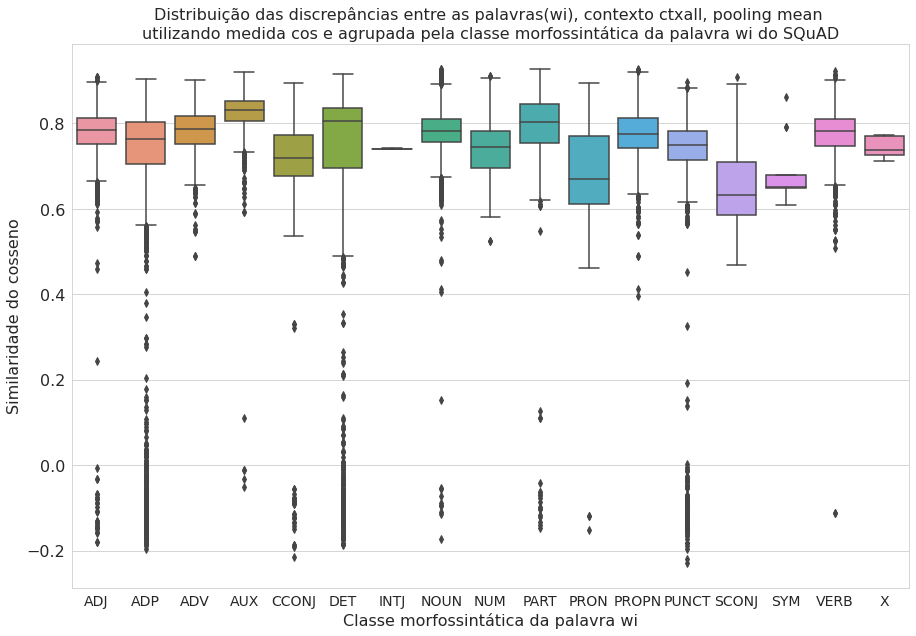

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std       min      25%      50%      75%  \
pos_i                                                                      
ADJ   2144.000000 0.758959 0.109813 -0.179693 0.742677 0.777269 0.804055   
ADP   3528.000000 0.694337 0.228583 -0.194765 0.705851 0.764224 0.802631   
ADV    527.000000 0.776792 0.061787  0.490730 0.748771 0.783885 0.815562   
AUX   2527.000000 0.825649 0.052371 -0.051380 0.805619 0.831492 0.853314   
CCONJ  292.000000 0.652140 0.254911 -0.214284 0.676723 0.719556 0.773150   
DET   3317.000000 0.717831 0.228786 -0.185305 0.696953 0.804395 0.835167   
INTJ     2.000000 0.740454 0.001513  0.739384 0.739919 0.740454 0.740989   
NOUN  6055.000000 0.770627 0.056397 -0.171550 0.747933 0.777085 0.802362   
NUM    428.000000 0.728653 0.061328  0.566600 0.688727 0.736209 0.774991   
PART   644.000000 0.764525 0.152914 -0.147104 0.749533 0.794145 0.830546   
PRON  1896.000000 0.685387 0.099678 -0.150916 0.611839 0.669632 0.769470   
PROPN 3397.000000 0.743155 0.055241  0.536235 0.713477 0.752206 0.781570   
PUNCT 3264.000000 0.720501 0.162416 -0.228659 0.714351 0.749729 0.781711   
SCONJ  814.000000 0.650849 0.091400  0.467915 0.585357 0.632623 0.708502   
SYM     14.000000 0.670492 0.055548  0.609325 0.649391 0.652215 0.679876   
VERB  2895.000000 0.773030 0.056737 -0.111169 0.744866 0.779500 0.807913   
X        7.000000 0.745241 0.026784  0.711558 0.725984 0.737844 0.771701   

           max  
pos_i           
ADJ   0.908822  
ADP   0.903340  
ADV   0.901211  
AUX   0.919683  
CCONJ 0.894152  
DET   0.915012  
INTJ  0.741524  
NOUN  0.887616  
NUM   0.911911  
PART  0.911559  
PRON  0.893796  
PROPN 0.877028  
PUNCT 0.896836  
SCONJ 0.908546  
SYM   0.791560  
VERB  0.906236  
X     0.771912

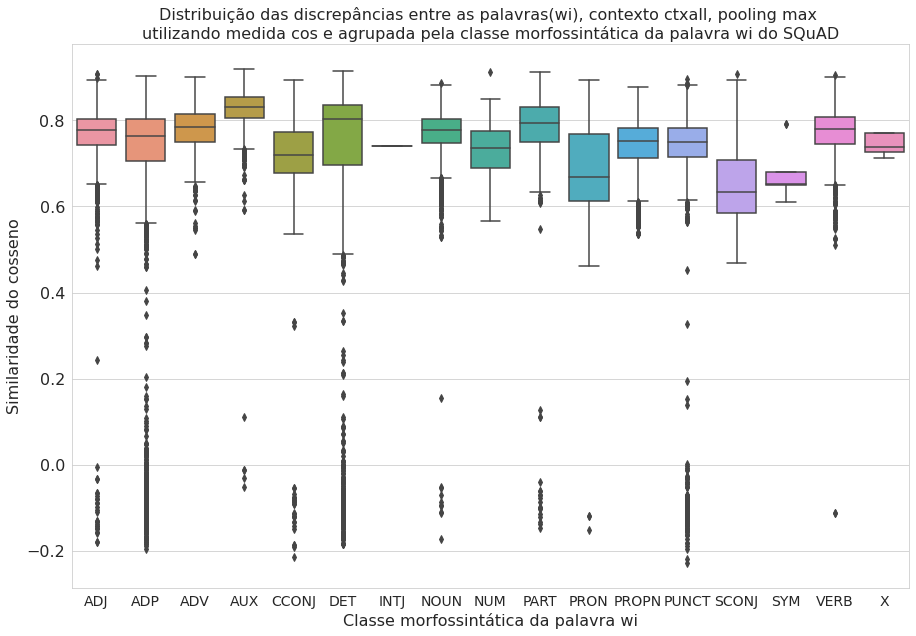

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

#### EUC

In [ ]:
medida = "euc"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                          
ADJ   2144.000000 27.796105 3.996745 15.521852 25.673178 27.574316 29.807775   
ADP   3528.000000 31.044709 5.117527 17.774363 27.471045 30.083867 33.593591   
ADV    527.000000 28.332577 4.170429 18.729811 25.664133 27.948874 30.720386   
AUX   2527.000000 25.420647 2.886209 15.435189 23.490778 25.323708 27.265991   
CCONJ  292.000000 32.020610 5.175245 19.004978 28.617142 31.806319 34.199782   
DET   3317.000000 29.521972 6.225109 16.773283 25.073433 27.568272 33.011799   
INTJ     2.000000 31.372469 0.068139 31.324287 31.348378 31.372469 31.396560   
NOUN  6055.000000 27.356033 3.422731 13.849763 25.515737 27.433371 29.390595   
NUM    428.000000 30.109490 4.587755 15.997623 27.271496 29.616806 33.350102   
PART   644.000000 26.931924 4.754517 15.596294 23.561978 26.478466 29.525095   
PRON  1896.000000 33.121520 5.163938 19.577154 29.019205 34.248535 37.157782   
PROPN 3397.000000 26.814040 4.333764 12.264054 24.196602 27.484411 29.597826   
PUNCT 3264.000000 29.606896 3.892852 18.422895 27.300471 29.160048 31.309173   
SCONJ  814.000000 35.195500 4.819407 17.585857 32.709614 36.281708 38.417313   
SYM     14.000000 33.938080 5.067378 20.114389 33.860988 35.705580 36.307810   
VERB  2895.000000 28.317595 3.447878 14.621447 26.079433 28.263968 30.503311   
X        7.000000 31.256135 2.052975 28.929890 29.142374 32.653049 32.865309   

            max  
pos_i            
ADJ   45.741364  
ADP   46.381302  
ADV   43.818737  
AUX   41.596291  
CCONJ 45.863129  
DET   45.819889  
INTJ  31.420650  
NOUN  44.011665  
NUM   41.252361  
PART  44.421440  
PRON  44.446083  
PROPN 42.688576  
PUNCT 45.780571  
SCONJ 44.384129  
SYM   38.555416  
VERB  43.906845  
X     33.194637

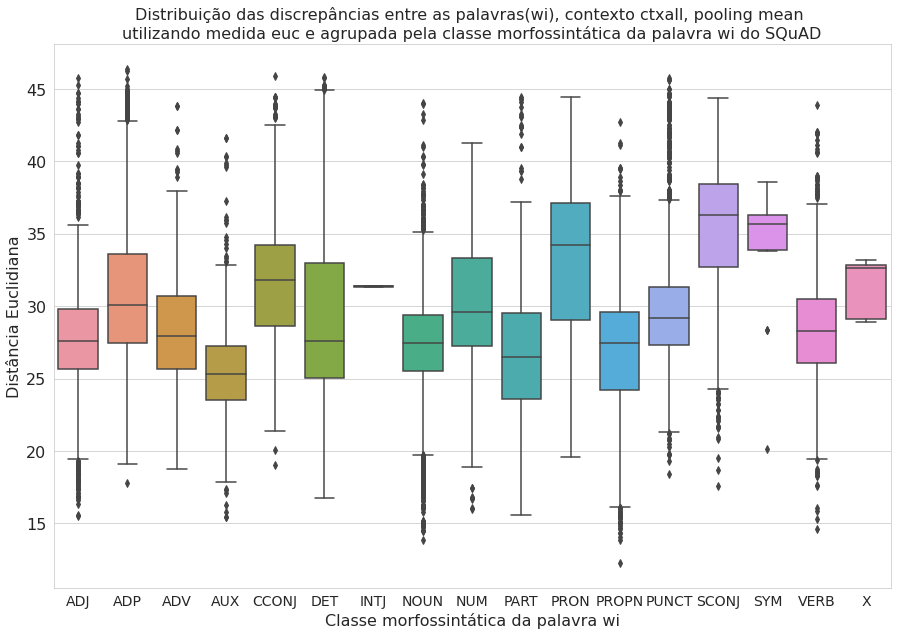

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                          
ADJ   2144.000000 28.988594 4.310845 18.354097 26.321319 28.149018 30.657743   
ADP   3528.000000 31.044709 5.117527 17.774363 27.471045 30.083867 33.593591   
ADV    527.000000 28.594953 4.172473 18.729811 25.805643 28.210602 31.057942   
AUX   2527.000000 25.443383 2.883589 15.787507 23.496735 25.341141 27.274379   
CCONJ  292.000000 32.117142 5.106791 19.004978 28.694841 31.966390 34.422640   
DET   3317.000000 29.538590 6.216748 16.773283 25.080513 27.585993 33.011799   
INTJ     2.000000 31.372469 0.068139 31.324287 31.348378 31.372469 31.396560   
NOUN  6055.000000 28.396105 3.370520 19.293945 26.215549 27.956415 30.001703   
NUM    428.000000 31.340346 4.475259 16.792143 27.904543 30.586519 34.017895   
PART   644.000000 28.300163 4.679153 17.321085 25.323783 27.732025 30.391375   
PRON  1896.000000 33.146680 5.153068 19.577154 29.071722 34.251072 37.173079   
PROPN 3397.000000 30.211143 4.285438 20.116777 27.401981 29.305466 31.980366   
PUNCT 3264.000000 29.606896 3.892852 18.422895 27.300471 29.160048 31.309173   
SCONJ  814.000000 35.236456 4.809416 17.585857 32.762630 36.291870 38.434505   
SYM     14.000000 35.200408 3.225252 28.381855 34.388911 36.074015 37.368453   
VERB  2895.000000 28.756063 3.578816 18.269419 26.407901 28.514038 30.808184   
X        7.000000 31.256135 2.052975 28.929890 29.142374 32.653049 32.865309   

            max  
pos_i            
ADJ   53.854504  
ADP   46.381302  
ADV   43.818737  
AUX   41.596291  
CCONJ 45.863129  
DET   45.819889  
INTJ  31.420650  
NOUN  49.654564  
NUM   47.147266  
PART  44.421440  
PRON  44.446083  
PROPN 51.803310  
PUNCT 45.780571  
SCONJ 44.384129  
SYM   38.555416  
VERB  47.237957  
X     33.194637

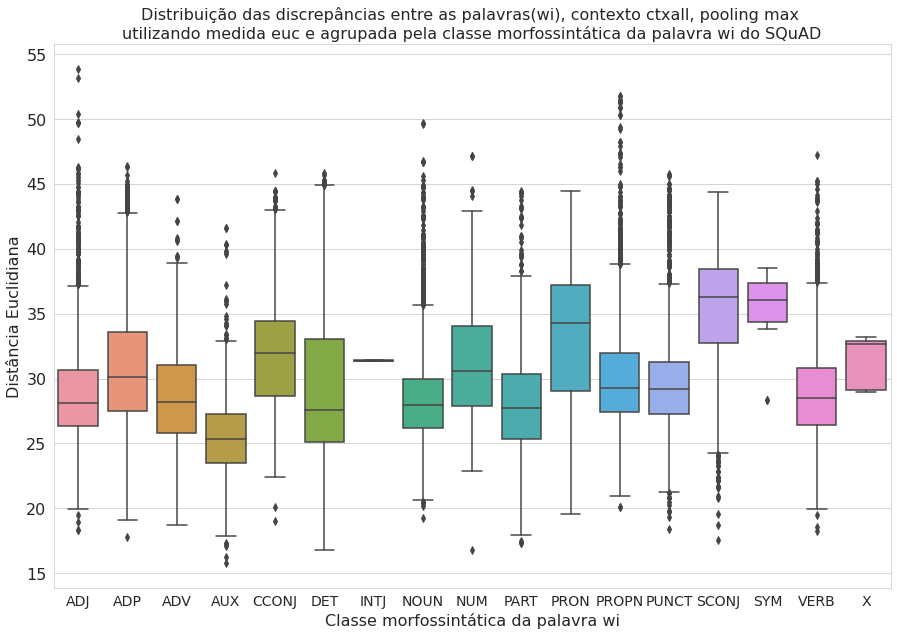

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

#### MAN

In [ ]:
medida = "man"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                          
ADJ   2144.000000 1379.731099 188.658271  792.154050 1275.163500 1376.319450   
ADP   3528.000000 1497.172006 209.204884  894.501600 1344.155225 1485.992000   
ADV    527.000000 1423.346876 210.007204  942.879940 1289.199300 1408.312700   
AUX   2527.000000 1281.601679 143.160225  732.533140 1183.363700 1279.523400   
CCONJ  292.000000 1527.052590 215.599483  949.091300 1377.079425 1529.252700   
DET   3317.000000 1417.202960 249.828849  845.477600 1238.682400 1359.380900   
INTJ     2.000000 1575.596200   6.068815 1571.304900 1573.450550 1575.596200   
NOUN  6055.000000 1365.308676 174.006675  703.460800 1270.194950 1369.577900   
NUM    428.000000 1512.178346 238.740439  793.268200 1365.355375 1492.249400   
PART   644.000000 1328.274784 216.767999  783.519400 1184.207925 1326.699700   
PRON  1896.000000 1630.864343 234.753478  973.859740 1450.974975 1676.064800   
PROPN 3397.000000 1334.983431 219.146236  611.551760 1207.304200 1367.414300   
PUNCT 3264.000000 1470.527606 164.568396  923.907200 1365.266200 1466.788950   
SCONJ  814.000000 1723.872549 217.911233  882.774660 1614.949525 1778.725450   
SYM     14.000000 1714.854107 257.919702 1030.072400 1701.408000 1814.147100   
VERB  2895.000000 1426.653681 176.132658  737.681640 1310.239350 1425.343000   
X        7.000000 1581.783400 105.876314 1469.649900 1472.765500 1633.544900   

              75%         max  
pos_i                          
ADJ   1489.620125 2116.392600  
ADP   1632.347550 2168.415500  
ADV   1546.874700 2144.607700  
AUX   1376.846100 2049.773400  
CCONJ 1674.722600 2169.886000  
DET   1529.606600 2250.778800  
INTJ  1577.741850 1579.887500  
NOUN  1469.532350 1953.169700  
NUM   1686.855300 2101.836400  
PART  1473.048300 2004.333900  
PRON  1814.203625 2183.854500  
PROPN 1477.267100 2123.255000  
PUNCT 1571.408100 2079.731000  
SCONJ 1862.117875 2157.450700  
SYM   1837.712800 1951.365600  
VERB  1539.166800 2209.260700  
X     1661.933300 1699.891400

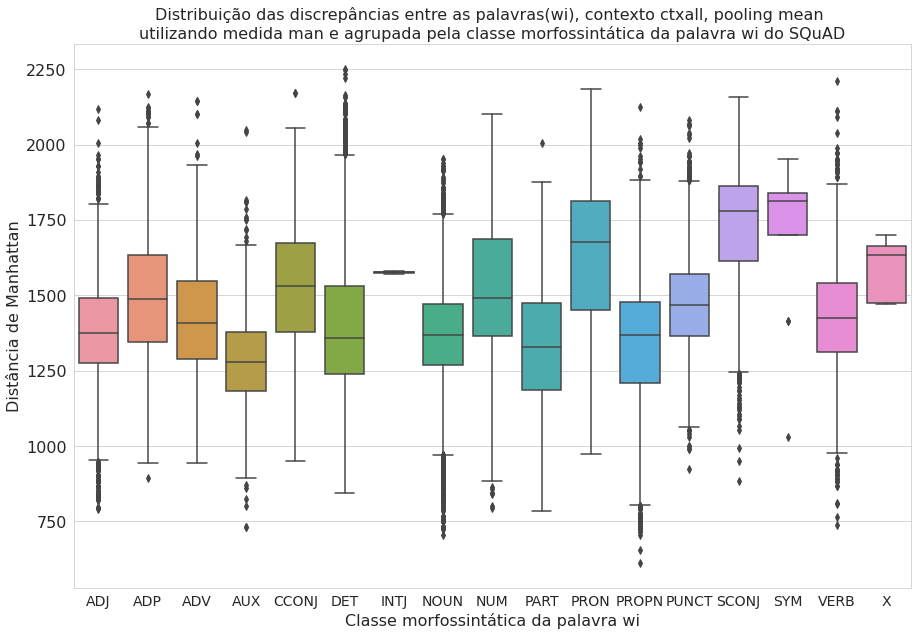

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                          
ADJ   2144.000000 1444.397188 219.637302  919.459700 1312.161600 1403.923850   
ADP   3528.000000 1497.172006 209.204884  894.501600 1344.155225 1485.992000   
ADV    527.000000 1437.309407 208.501301  942.879940 1303.099100 1414.493500   
AUX   2527.000000 1282.865680 142.281634  800.147800 1184.052450 1280.126500   
CCONJ  292.000000 1532.197133 213.739042  949.091300 1389.075950 1529.539300   
DET   3317.000000 1417.987372 249.538618  845.477600 1239.155800 1360.008800   
INTJ     2.000000 1575.596200   6.068815 1571.304900 1573.450550 1575.596200   
NOUN  6055.000000 1420.514232 177.894657  974.048650 1307.722600 1396.703600   
NUM    428.000000 1579.087860 240.286931  863.957700 1399.477800 1542.976950   
PART   644.000000 1406.952167 207.996797  875.939200 1264.761700 1391.946950   
PRON  1896.000000 1632.125421 234.287990  973.859740 1453.004925 1676.920650   
PROPN 3397.000000 1514.581803 236.584139 1004.731900 1364.594700 1459.136500   
PUNCT 3264.000000 1470.527606 164.568396  923.907200 1365.266200 1466.788950   
SCONJ  814.000000 1725.993219 217.820242  882.774660 1615.326800 1779.346400   
SYM     14.000000 1781.204371 174.053484 1415.968000 1733.330675 1822.045150   
VERB  2895.000000 1450.270360 185.095680  902.179200 1329.388600 1439.027600   
X        7.000000 1581.783400 105.876314 1469.649900 1472.765500 1633.544900   

              75%         max  
pos_i                          
ADJ   1532.127700 2994.337000  
ADP   1632.347550 2168.415500  
ADV   1567.680150 2144.607700  
AUX   1377.399400 2049.773400  
CCONJ 1681.686700 2169.886000  
DET   1530.038000 2250.778800  
INTJ  1577.741850 1579.887500  
NOUN  1500.352700 2720.041300  
NUM   1711.838300 2488.375000  
PART  1518.467675 2155.826700  
PRON  1814.667475 2183.854500  
PROPN 1603.848100 2862.921400  
PUNCT 1571.408100 2079.731000  
SCONJ 1862.852050 2157.450700  
SYM   1890.669300 1958.976100  
VERB  1554.291300 2529.345200  
X     1661.933300 1699.891400

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

### Contexto com todas as palavras sem as stopwords(ctxclean)

In [ ]:
equacao_medida = "ctxclean"

#### COS

In [ ]:
medida = "cos"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std       min      25%      50%      75%  \
pos_i                                                                      
ADJ   2144.000000 0.778996 0.119123 -0.223004 0.761942 0.805697 0.833378   
ADP   3528.000000 0.618057 0.235822 -0.263093 0.623602 0.688436 0.732713   
ADV    527.000000 0.752394 0.084921  0.432559 0.707368 0.766526 0.812575   
AUX   2527.000000 0.744268 0.059288 -0.201122 0.719111 0.748724 0.775100   
CCONJ  292.000000 0.585735 0.258959 -0.257606 0.611674 0.656210 0.711320   
DET   3317.000000 0.636581 0.231033 -0.263263 0.606320 0.718635 0.757447   
INTJ     2.000000 0.775565 0.000060  0.775522 0.775544 0.775565 0.775586   
NOUN  6055.000000 0.809331 0.059448 -0.130207 0.788473 0.817991 0.843024   
NUM    428.000000 0.742974 0.078373  0.497173 0.692789 0.761127 0.802881   
PART   644.000000 0.692106 0.159572 -0.204462 0.673234 0.723434 0.769843   
PRON  1896.000000 0.607994 0.101831 -0.215862 0.534087 0.584438 0.692864   
PROPN 3397.000000 0.801354 0.050510  0.360438 0.777415 0.807214 0.833105   
PUNCT 3264.000000 0.724952 0.159736 -0.208595 0.715063 0.751450 0.785204   
SCONJ  814.000000 0.565806 0.095462  0.376610 0.499086 0.537899 0.608901   
SYM     14.000000 0.715850 0.074323  0.644180 0.670867 0.689038 0.707316   
VERB  2895.000000 0.782669 0.063920 -0.015720 0.753057 0.793273 0.825177   
X        7.000000 0.779886 0.033894  0.737131 0.756050 0.773492 0.805848   

           max  
pos_i           
ADJ   0.914735  
ADP   0.890572  
ADV   0.912625  
AUX   0.879961  
CCONJ 0.843235  
DET   0.867799  
INTJ  0.775608  
NOUN  0.924491  
NUM   0.889237  
PART  0.867931  
PRON  0.860039  
PROPN 0.928414  
PUNCT 1.000000  
SCONJ 0.851643  
SYM   0.856590  
VERB  0.915301  
X     0.824785

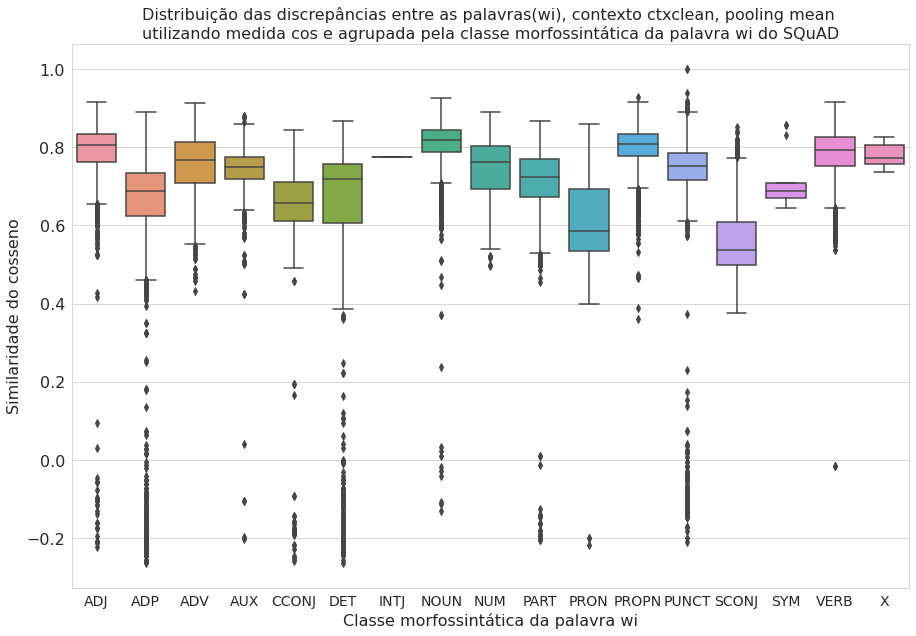

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std       min      25%      50%      75%  \
pos_i                                                                      
ADJ   2144.000000 0.767763 0.123763 -0.223004 0.736569 0.799608 0.829971   
ADP   3528.000000 0.618057 0.235822 -0.263093 0.623602 0.688436 0.732713   
ADV    527.000000 0.750233 0.084768  0.432559 0.706737 0.760826 0.806706   
AUX   2527.000000 0.744496 0.058426 -0.201122 0.719111 0.748724 0.775100   
CCONJ  292.000000 0.584768 0.258384 -0.257606 0.611674 0.656210 0.708414   
DET   3317.000000 0.636439 0.230992 -0.263263 0.606320 0.718434 0.757447   
INTJ     2.000000 0.775565 0.000060  0.775522 0.775544 0.775565 0.775586   
NOUN  6055.000000 0.799487 0.066356 -0.130207 0.777892 0.811614 0.839326   
NUM    428.000000 0.732102 0.081423  0.515837 0.681229 0.745632 0.797772   
PART   644.000000 0.688065 0.157741 -0.204462 0.672985 0.716734 0.761428   
PRON  1896.000000 0.607739 0.101648 -0.215862 0.533383 0.584152 0.692864   
PROPN 3397.000000 0.768823 0.075497  0.465913 0.734412 0.787238 0.820799   
PUNCT 3264.000000 0.724952 0.159736 -0.208595 0.715063 0.751450 0.785204   
SCONJ  814.000000 0.565388 0.095520  0.376610 0.499066 0.537394 0.607783   
SYM     14.000000 0.703765 0.067486  0.644180 0.665052 0.677636 0.705435   
VERB  2895.000000 0.778673 0.067630 -0.015720 0.748706 0.791046 0.824199   
X        7.000000 0.779886 0.033894  0.737131 0.756050 0.773492 0.805848   

           max  
pos_i           
ADJ   0.914735  
ADP   0.890572  
ADV   0.912625  
AUX   0.879961  
CCONJ 0.843235  
DET   0.867799  
INTJ  0.775608  
NOUN  0.924491  
NUM   0.889237  
PART  0.867931  
PRON  0.849531  
PROPN 0.914870  
PUNCT 1.000000  
SCONJ 0.851643  
SYM   0.856590  
VERB  0.915301  
X     0.824785

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

#### EUC

In [ ]:
medida = "euc"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                          
ADJ   2144.000000 27.209045 4.796223 16.666996 24.028475 26.082309 29.598794   
ADP   3528.000000 34.881862 5.401404 20.098831 31.118530 33.782022 37.353293   
ADV    527.000000 29.600192 5.188876 17.229431 26.127879 29.332754 32.422421   
AUX   2527.000000 29.918807 2.905563 19.307667 28.038480 29.876657 31.747473   
CCONJ  292.000000 35.384154 5.413424 22.370609 31.858644 34.756819 37.269840   
DET   3317.000000 33.751320 6.046870 21.050858 29.355770 31.935284 37.362808   
INTJ     2.000000 29.449418 0.143619 29.347864 29.398641 29.449418 29.500195   
NOUN  6055.000000 25.643075 3.447960 15.381392 23.321843 25.324009 27.484296   
NUM    428.000000 29.925411 4.989952 19.796015 26.191273 28.995770 33.905347   
PART   644.000000 31.291366 4.526741 21.927425 28.304605 30.652506 33.341776   
PRON  1896.000000 36.832739 5.022830 20.610954 32.550030 38.212965 40.780380   
PROPN 3397.000000 25.503235 3.292409 14.265612 23.244581 25.336540 27.492399   
PUNCT 3264.000000 29.395313 3.925697  0.000000 27.159981 29.173791 31.281001   
SCONJ  814.000000 39.082204 4.786068 21.683859 37.453735 40.485353 42.261073   
SYM     14.000000 32.411719 5.026919 22.176790 32.972557 34.082262 35.434296   
VERB  2895.000000 27.894589 3.925477 17.607315 25.173280 27.557499 30.211957   
X        7.000000 29.344338 2.533579 25.785873 27.197182 30.713902 31.291503   

            max  
pos_i            
ADJ   49.127216  
ADP   50.180656  
ADV   45.804718  
AUX   48.460121  
CCONJ 48.958790  
DET   49.852932  
INTJ  29.550972  
NOUN  42.218525  
NUM   44.240856  
PART  48.928722  
PRON  48.455158  
PROPN 43.918770  
PUNCT 44.723145  
SCONJ 48.170612  
SYM   37.699032  
VERB  42.436909  
X     31.933224

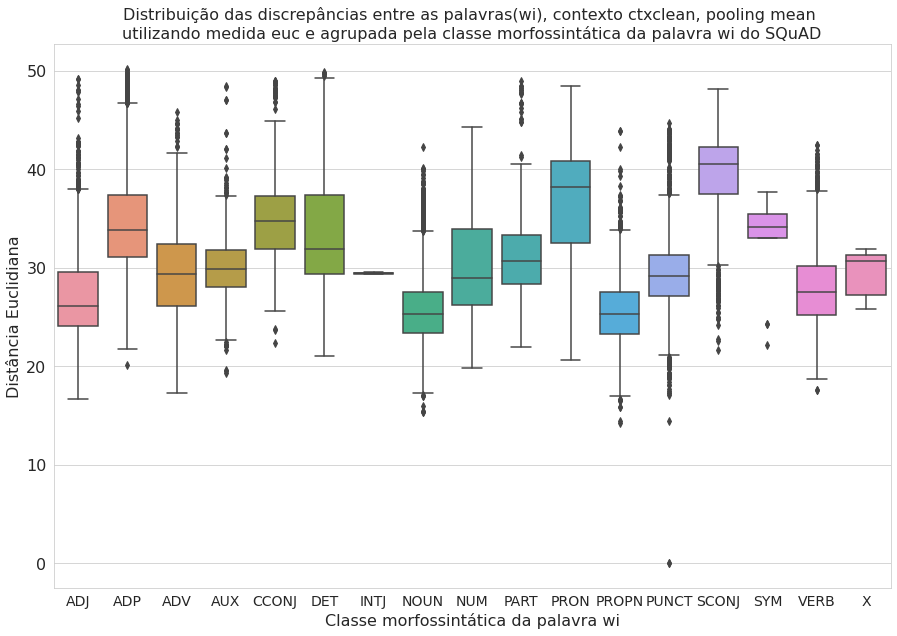

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                          
ADJ   2144.000000 28.340388 5.490497 16.666996 24.632961 26.886398 31.004905   
ADP   3528.000000 34.881862 5.401404 20.098831 31.118530 33.782022 37.353293   
ADV    527.000000 29.850703 5.177794 17.229431 26.383976 29.527283 32.670845   
AUX   2527.000000 29.928803 2.917648 19.307667 28.038480 29.886492 31.753390   
CCONJ  292.000000 35.474688 5.326849 22.370609 31.925193 34.815184 37.269840   
DET   3317.000000 33.765489 6.040554 21.050858 29.389494 31.957052 37.362808   
INTJ     2.000000 29.449418 0.143619 29.347864 29.398641 29.449418 29.500195   
NOUN  6055.000000 26.635424 4.168690 15.944219 23.904562 25.940466 28.434616   
NUM    428.000000 31.070149 5.392412 20.733404 26.574733 30.587214 34.719932   
PART   644.000000 32.305653 4.865660 21.927425 29.053801 31.801169 34.335215   
PRON  1896.000000 36.856801 5.002301 22.711462 32.556072 38.218637 40.783759   
PROPN 3397.000000 28.709886 5.422254 16.927723 25.138596 27.422800 30.800808   
PUNCT 3264.000000 29.395313 3.925697  0.000000 27.159981 29.173791 31.281001   
SCONJ  814.000000 39.118063 4.786461 21.683859 37.578990 40.495741 42.276003   
SYM     14.000000 33.589592 4.327555 24.237064 32.989886 35.181597 35.714862   
VERB  2895.000000 28.308961 4.231648 17.607315 25.401385 27.896212 30.526541   
X        7.000000 29.344338 2.533579 25.785873 27.197182 30.713902 31.291503   

            max  
pos_i            
ADJ   55.460445  
ADP   50.180656  
ADV   45.804718  
AUX   48.460121  
CCONJ 48.958790  
DET   49.852932  
INTJ  29.550972  
NOUN  51.208912  
NUM   48.863487  
PART  48.928722  
PRON  48.455158  
PROPN 53.668068  
PUNCT 44.723145  
SCONJ 48.170612  
SYM   38.667019  
VERB  48.903595  
X     31.933224

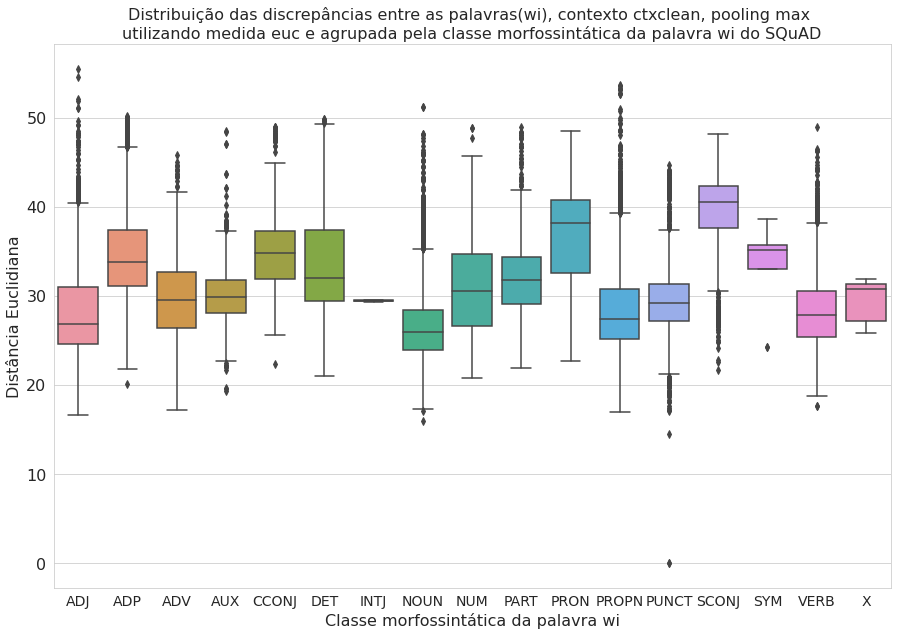

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

#### MAN

In [ ]:
medida = "man"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                          
ADJ   2144.000000 1351.966384 227.623693  816.086730 1198.919200 1302.563700   
ADP   3528.000000 1682.511698 213.414035 1015.844240 1535.075725 1674.677150   
ADV    527.000000 1488.185715 262.005917  865.990360 1312.571050 1478.932700   
AUX   2527.000000 1511.260945 142.413660  983.103000 1416.739550 1510.574700   
CCONJ  292.000000 1688.449491 214.978723 1122.548100 1543.075200 1708.642300   
DET   3317.000000 1624.331299 237.606315 1058.034700 1453.102400 1579.807700   
INTJ     2.000000 1491.425150   9.407278 1484.773200 1488.099175 1491.425150   
NOUN  6055.000000 1281.878724 174.913831  773.505740 1163.394800 1265.853500   
NUM    428.000000 1502.343934 258.812014  894.609300 1306.218175 1454.150700   
PART   644.000000 1543.418507 201.435495  957.779100 1408.610600 1536.853150   
PRON  1896.000000 1816.270479 225.772472 1032.868400 1636.951125 1874.580150   
PROPN 3397.000000 1270.263700 167.134372  669.029400 1155.715300 1262.289100   
PUNCT 3264.000000 1459.510629 171.072897    0.000000 1358.375200 1466.357150   
SCONJ  814.000000 1918.638695 214.604437 1104.856200 1851.727925 1966.117400   
SYM     14.000000 1642.096836 254.299016 1129.674100 1657.412025 1733.881800   
VERB  2895.000000 1406.921636 200.503550  893.575560 1270.578350 1390.140000   
X        7.000000 1483.947700 130.006676 1314.553300 1368.937700 1542.853900   

              75%         max  
pos_i                          
ADJ   1473.294475 2209.787000  
ADP   1819.740700 2369.888200  
ADV   1634.157250 2263.295400  
AUX   1605.513000 2212.918000  
CCONJ 1825.724500 2329.813500  
DET   1752.700400 2405.935800  
INTJ  1494.751125 1498.077100  
NOUN  1376.837300 1997.821000  
NUM   1714.798725 2243.273400  
PART  1672.486725 2332.912600  
PRON  1987.775525 2347.573000  
PROPN 1369.874000 2150.273200  
PUNCT 1572.158700 1996.065200  
SCONJ 2054.886275 2368.643600  
SYM   1795.099200 1905.334200  
VERB  1528.912400 2161.933000  
X     1581.110900 1630.129500

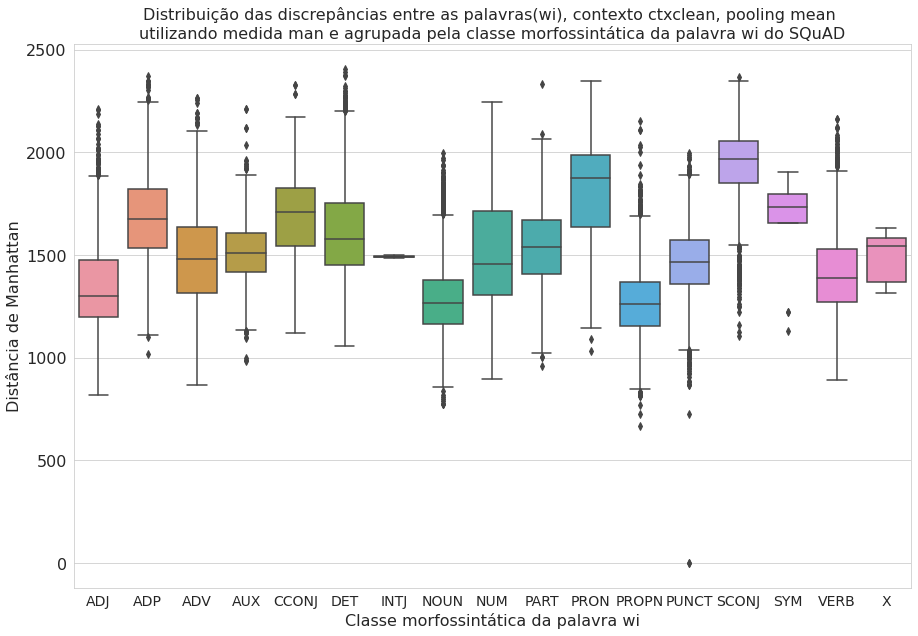

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                          
ADJ   2144.000000 1413.217874 274.497567  829.905000 1228.019725 1344.397900   
ADP   3528.000000 1682.511698 213.414035 1015.844240 1535.075725 1674.677150   
ADV    527.000000 1501.749093 259.580834  865.990360 1328.690300 1490.826000   
AUX   2527.000000 1512.186085 142.695526  983.103000 1417.330800 1510.717000   
CCONJ  292.000000 1693.336763 211.770419 1122.548100 1548.582325 1709.082750   
DET   3317.000000 1624.995148 237.437058 1058.034700 1453.889900 1581.174600   
INTJ     2.000000 1491.425150   9.407278 1484.773200 1488.099175 1491.425150   
NOUN  6055.000000 1334.623920 216.260633  799.278300 1193.946950 1297.708900   
NUM    428.000000 1564.803209 284.017130 1019.431400 1329.513675 1535.956300   
PART   644.000000 1606.416057 214.862894 1104.109100 1453.014600 1597.392600   
PRON  1896.000000 1817.499333 224.749141 1145.476100 1637.814125 1874.751250   
PROPN 3397.000000 1439.820270 289.239069  857.090100 1251.947500 1367.030500   
PUNCT 3264.000000 1459.510629 171.072897    0.000000 1358.375200 1466.357150   
SCONJ  814.000000 1920.462804 215.013441 1104.856200 1855.660125 1966.178150   
SYM     14.000000 1704.339471 224.076089 1224.332800 1666.721775 1776.436500   
VERB  2895.000000 1429.381434 217.741860  893.575560 1281.410900 1406.868300   
X        7.000000 1483.947700 130.006676 1314.553300 1368.937700 1542.853900   

              75%         max  
pos_i                          
ADJ   1544.769075 3028.649200  
ADP   1819.740700 2369.888200  
ADV   1642.159900 2263.295400  
AUX   1606.037450 2212.918000  
CCONJ 1830.477825 2329.813500  
DET   1753.462600 2405.935800  
INTJ  1494.751125 1498.077100  
NOUN  1423.970300 2747.411100  
NUM   1749.111800 2551.618200  
PART  1720.962925 2457.003000  
PRON  1987.945000 2347.573000  
PROPN 1537.245100 2912.674300  
PUNCT 1572.158700 1996.065200  
SCONJ 2055.359900 2368.643600  
SYM   1817.245150 2001.071000  
VERB  1544.044400 2588.652300  
X     1581.110900 1630.129500

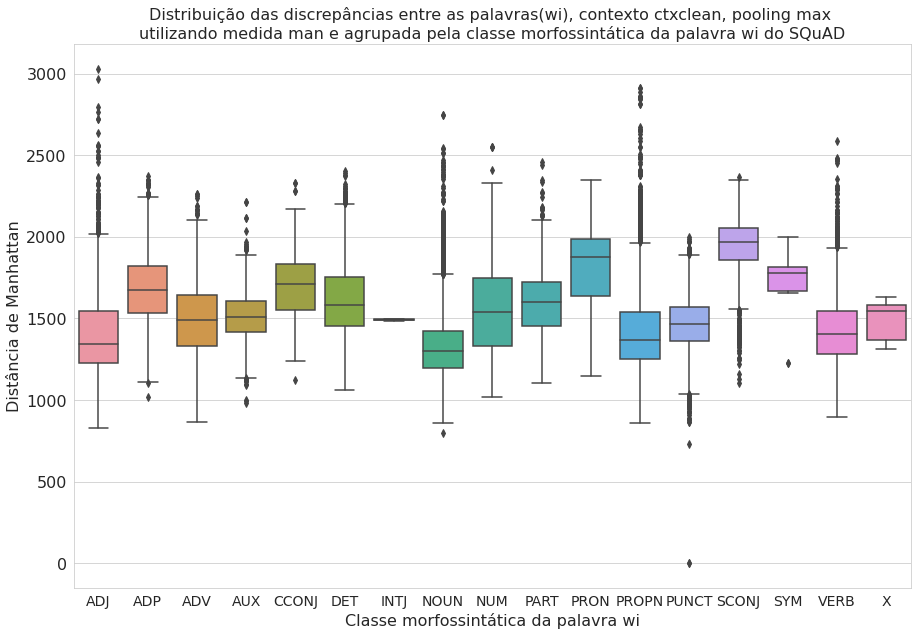

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

### Contexto com palavras da classe VERB e AUX(ctxverb)

In [ ]:
equacao_medida = "ctxverb"

#### COS

In [ ]:
medida = "cos"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std       min      25%      50%      75%  \
pos_i                                                                      
ADJ   2119.000000 0.623474 0.113847 -0.240234 0.580539 0.631468 0.680832   
ADP   3475.000000 0.580336 0.220488 -0.223757 0.550395 0.641765 0.699359   
ADV    525.000000 0.699256 0.094552  0.356224 0.637642 0.709877 0.768934   
AUX   2527.000000 0.914759 0.064496  0.144303 0.881067 0.906689 0.948916   
CCONJ  282.000000 0.533911 0.242426 -0.239562 0.521797 0.600548 0.665813   
DET   3274.000000 0.610707 0.228171 -0.227315 0.540896 0.681382 0.750623   
INTJ     2.000000 0.607885 0.004402  0.604773 0.606329 0.607885 0.609441   
NOUN  5965.000000 0.636621 0.076462 -0.194291 0.591115 0.639902 0.686124   
NUM    426.000000 0.582176 0.082495  0.375802 0.527761 0.580675 0.637164   
PART   640.000000 0.692668 0.163700 -0.182657 0.661566 0.722218 0.784389   
PRON  1884.000000 0.577576 0.111318 -0.211654 0.497957 0.554409 0.667383   
PROPN 3359.000000 0.593955 0.072287  0.264420 0.545979 0.594536 0.641401   
PUNCT 3214.000000 0.614260 0.162067 -0.253069 0.590523 0.645117 0.690507   
SCONJ  810.000000 0.548377 0.111468  0.325625 0.477366 0.518292 0.590009   
SYM     14.000000 0.514358 0.078936  0.403140 0.482636 0.494550 0.528405   
VERB  2895.000000 0.890154 0.062854  0.171387 0.854246 0.893590 0.918297   
X        7.000000 0.493225 0.059649  0.406309 0.444501 0.533930 0.536448   

           max  
pos_i           
ADJ   0.871726  
ADP   0.885692  
ADV   0.892939  
AUX   1.000000  
CCONJ 0.784231  
DET   0.916746  
INTJ  0.610998  
NOUN  0.865986  
NUM   0.812052  
PART  0.908351  
PRON  0.860116  
PROPN 0.799473  
PUNCT 0.852877  
SCONJ 0.881707  
SYM   0.680977  
VERB  1.000000  
X     0.550438

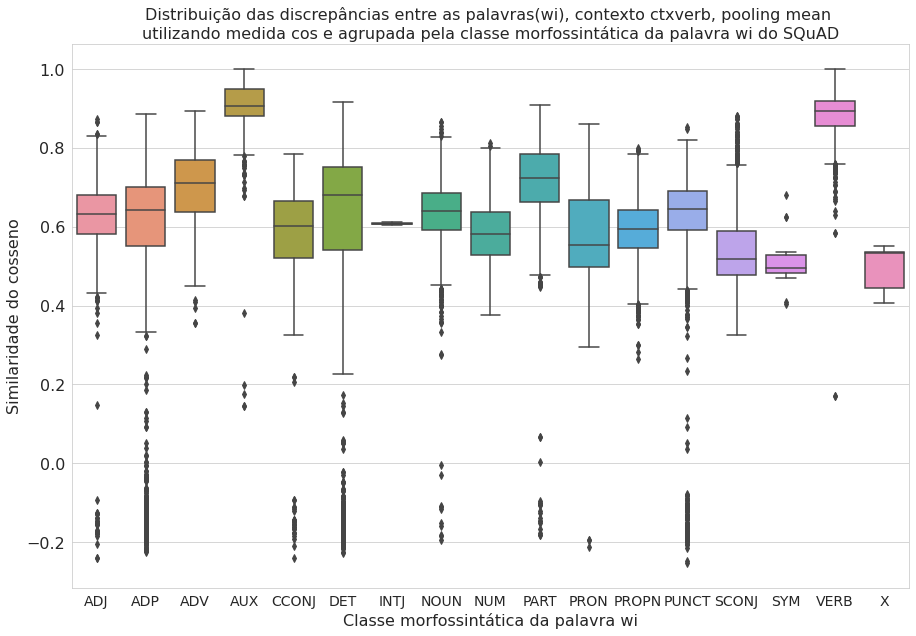

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std       min      25%      50%      75%  \
pos_i                                                                      
ADJ   2119.000000 0.615154 0.118372 -0.240234 0.570311 0.627006 0.679015   
ADP   3475.000000 0.580336 0.220488 -0.223757 0.550395 0.641765 0.699359   
ADV    525.000000 0.697393 0.094752  0.356224 0.637349 0.706927 0.768475   
AUX   2527.000000 0.914522 0.064676  0.144303 0.880956 0.906582 0.948709   
CCONJ  282.000000 0.533008 0.241948 -0.239562 0.521797 0.599610 0.662595   
DET   3274.000000 0.610586 0.228144 -0.227315 0.540896 0.681211 0.750623   
INTJ     2.000000 0.607885 0.004402  0.604773 0.606329 0.607885 0.609441   
NOUN  5965.000000 0.629124 0.078667 -0.194291 0.582445 0.634055 0.679129   
NUM    426.000000 0.574253 0.085913  0.338968 0.521841 0.576771 0.632445   
PART   640.000000 0.686749 0.164192 -0.182657 0.653116 0.718034 0.780990   
PRON  1884.000000 0.577370 0.111407 -0.211654 0.497840 0.554204 0.667383   
PROPN 3359.000000 0.569732 0.073077  0.317507 0.521149 0.572635 0.618390   
PUNCT 3214.000000 0.614260 0.162067 -0.253069 0.590523 0.645117 0.690507   
SCONJ  810.000000 0.547999 0.111569  0.325625 0.477228 0.517907 0.587474   
SYM     14.000000 0.503542 0.063145  0.403140 0.482636 0.494550 0.523173   
VERB  2895.000000 0.885388 0.070856  0.171387 0.850805 0.892995 0.917636   
X        7.000000 0.493225 0.059649  0.406309 0.444501 0.533930 0.536448   

           max  
pos_i           
ADJ   0.871726  
ADP   0.885692  
ADV   0.892939  
AUX   1.000000  
CCONJ 0.784231  
DET   0.916746  
INTJ  0.610998  
NOUN  0.865986  
NUM   0.812052  
PART  0.908351  
PRON  0.860116  
PROPN 0.793460  
PUNCT 0.852877  
SCONJ 0.881707  
SYM   0.623629  
VERB  1.000000  
X     0.550438

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

#### EUC

In [ ]:
medida = "euc"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                          
ADJ   2119.000000 37.166369 4.802935 22.008755 34.038795 37.101669 40.099110   
ADP   3475.000000 38.625485 6.617829 20.939419 34.046047 37.545727 42.722034   
ADV    525.000000 33.636948 5.955232 20.591690 29.421450 33.219967 37.572739   
AUX   2527.000000 15.514407 9.073953  0.000000 14.014116 18.996395 21.334676   
CCONJ  282.000000 39.775501 6.252805 27.891211 35.265937 39.591492 43.444016   
DET   3274.000000 36.693924 7.782183 16.655796 30.740955 35.049965 42.656022   
INTJ     2.000000 38.912531 0.321700 38.685055 38.798793 38.912531 39.026269   
NOUN  5965.000000 36.463494 4.413359 21.462152 33.395664 36.366837 39.485912   
NUM    426.000000 39.933992 5.120327 25.402821 36.061882 39.900885 43.714639   
PART   640.000000 32.433391 5.834498 18.320057 28.395248 31.965134 35.250889   
PRON  1884.000000 40.076656 6.137621 21.954365 35.266806 41.526966 44.581672   
PROPN 3359.000000 38.150888 4.626168 24.444145 34.988525 38.142708 41.294300   
PUNCT 3214.000000 36.873304 5.228862 23.174145 33.428631 36.107393 39.348581   
SCONJ  810.000000 41.503613 6.254578 20.624641 39.781219 43.244345 45.417419   
SYM     14.000000 44.513472 4.860041 34.402195 42.581369 46.178043 47.794978   
VERB  2895.000000 18.834047 7.938960  0.000000 17.811693 20.385473 23.397768   
X        7.000000 45.459129 4.117136 41.873787 42.200787 42.740566 48.961523   

            max  
pos_i            
ADJ   57.109898  
ADP   58.054005  
ADV   51.557648  
AUX   35.886940  
CCONJ 54.758373  
DET   56.231762  
INTJ  39.140007  
NOUN  55.239887  
NUM   53.405167  
PART  52.828949  
PRON  55.813690  
PROPN 52.648300  
PUNCT 57.083420  
SCONJ 54.379650  
SYM   50.788208  
VERB  37.731236  
X     51.274933

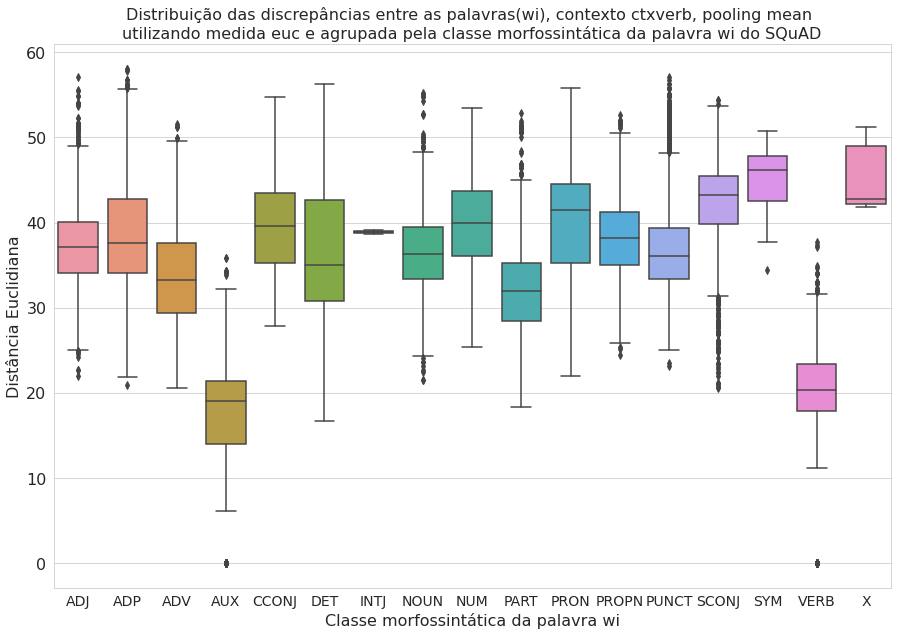

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                          
ADJ   2119.000000 38.002475 5.451215 22.008755 34.323275 37.524345 40.889456   
ADP   3475.000000 38.625485 6.617829 20.939419 34.046047 37.545727 42.722034   
ADV    525.000000 33.845921 5.993428 20.591690 29.635908 33.538555 38.001732   
AUX   2527.000000 15.550077 9.087566  0.000000 14.077534 18.997812 21.344112   
CCONJ  282.000000 39.857091 6.188541 27.891211 35.390417 39.628582 43.444016   
DET   3274.000000 36.705028 7.779731 16.655796 30.743442 35.058886 42.668840   
INTJ     2.000000 38.912531 0.321700 38.685055 38.798793 38.912531 39.026269   
NOUN  5965.000000 37.197675 4.679274 21.462152 33.912556 36.886261 40.279270   
NUM    426.000000 40.782239 5.624482 25.402821 36.914622 40.300890 44.235119   
PART   640.000000 33.354529 6.470101 18.320057 28.532786 32.517235 36.677127   
PRON  1884.000000 40.095028 6.146601 21.954365 35.266806 41.560867 44.594846   
PROPN 3359.000000 40.528208 4.942620 26.921160 37.185507 40.085979 43.655117   
PUNCT 3214.000000 36.873304 5.228862 23.174145 33.428631 36.107393 39.348581   
SCONJ  810.000000 41.534945 6.270317 20.624641 39.948711 43.246801 45.429184   
SYM     14.000000 45.438339 3.931084 37.667061 44.486782 46.815584 47.794978   
VERB  2895.000000 19.336627 8.386909  0.000000 17.894851 20.557259 23.847574   
X        7.000000 45.459129 4.117136 41.873787 42.200787 42.740566 48.961523   

            max  
pos_i            
ADJ   61.650280  
ADP   58.054005  
ADV   51.557648  
AUX   35.886940  
CCONJ 54.758373  
DET   56.231762  
INTJ  39.140007  
NOUN  59.706543  
NUM   58.770073  
PART  52.828949  
PRON  55.813690  
PROPN 63.013847  
PUNCT 57.083420  
SCONJ 54.379650  
SYM   50.788208  
VERB  48.746475  
X     51.274933

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

#### MAN

In [ ]:
medida = "man"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                          
ADJ   2119.000000 1860.270771 227.638353 1109.236816 1706.995300 1862.225220   
ADP   3475.000000 1886.506706 268.905504 1059.155518 1700.891418 1868.220703   
ADV    525.000000 1696.932098 300.030378 1035.643555 1479.823730 1673.283691   
AUX   2527.000000  783.616973 457.133226    0.000000  712.609253  960.436584   
CCONJ  282.000000 1925.446518 254.154534 1416.454346 1727.177979 1939.102173   
DET   3274.000000 1782.614584 319.672805  827.959045 1549.472107 1744.360840   
INTJ     2.000000 1940.917664  19.029131 1927.462036 1934.189850 1940.917664   
NOUN  5965.000000 1833.156491 222.960408 1063.084106 1678.233643 1830.363037   
NUM    426.000000 2014.451596 261.919900 1292.202637 1813.962280 2019.890015   
PART   640.000000 1608.501408 251.215601  933.730225 1429.714539 1599.144531   
PRON  1884.000000 1975.698700 282.633259 1110.272583 1779.774719 2020.195435   
PROPN 3359.000000 1915.132070 236.416850 1241.651611 1754.024658 1917.165527   
PUNCT 3214.000000 1840.683412 225.108775 1175.785034 1688.418427 1817.757568   
SCONJ  810.000000 2032.433314 287.983211 1046.453857 1943.814972 2094.053711   
SYM     14.000000 2257.742902 252.722408 1748.482178 2170.595703 2327.303467   
VERB  2895.000000  950.481713 399.626143    0.000000  898.620300 1030.426147   
X        7.000000 2302.151576 206.538686 2127.744385 2136.324585 2165.809570   

              75%         max  
pos_i                          
ADJ   2013.527527 2608.926270  
ADP   2068.334961 2845.965576  
ADV   1907.688477 2579.735352  
AUX   1079.633728 1719.350342  
CCONJ 2101.241455 2631.410156  
DET   1996.335327 2691.360840  
INTJ  1947.645477 1954.373291  
NOUN  1988.390137 2558.004395  
NUM   2211.630615 2707.064453  
PART  1754.153534 2372.600586  
PRON  2180.803894 2792.114258  
PROPN 2072.897095 2681.553223  
PUNCT 1978.513733 2706.395752  
SCONJ 2207.235657 2674.257812  
SYM   2418.165161 2584.671875  
VERB  1178.183594 1877.300049  
X     2477.677124 2593.503662

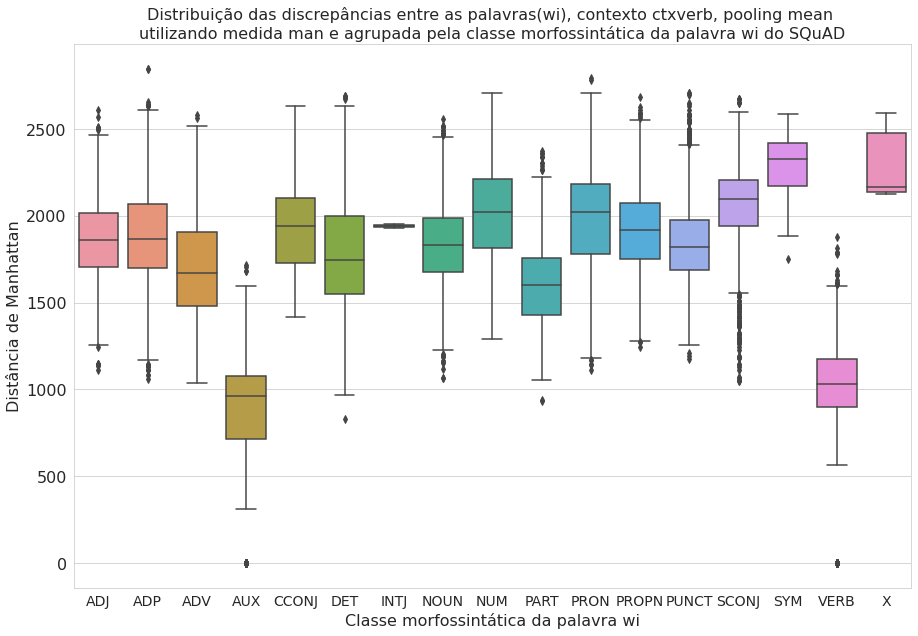

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                          
ADJ   2119.000000 1904.942352 266.425982 1109.236816 1728.862793 1886.602295   
ADP   3475.000000 1886.506706 268.905504 1059.155518 1700.891418 1868.220703   
ADV    525.000000 1708.068331 301.783269 1035.643555 1487.315063 1697.759521   
AUX   2527.000000  785.344429 457.660646    0.000000  713.694946  960.736023   
CCONJ  282.000000 1929.814881 251.481895 1416.454346 1728.054688 1944.267517   
DET   3274.000000 1783.113113 319.625231  827.959045 1550.548981 1744.869019   
INTJ     2.000000 1940.917664  19.029131 1927.462036 1934.189850 1940.917664   
NOUN  5965.000000 1872.007803 237.276066 1063.084106 1708.376709 1860.099365   
NUM    426.000000 2060.516288 289.352960 1292.202637 1851.256653 2038.690735   
PART   640.000000 1665.429313 292.381088  933.730225 1445.607330 1638.652893   
PRON  1884.000000 1976.581445 283.241193 1110.272583 1779.774719 2021.266235   
PROPN 3359.000000 2040.082523 256.663890 1371.866943 1867.793640 2016.353516   
PUNCT 3214.000000 1840.683412 225.108775 1175.785034 1688.418427 1817.757568   
SCONJ  810.000000 2033.959055 289.220264 1046.453857 1946.112732 2094.250977   
SYM     14.000000 2305.192592 208.190135 1883.613525 2280.070801 2359.315430   
VERB  2895.000000  976.918496 424.913785    0.000000  906.392151 1038.257812   
X        7.000000 2302.151576 206.538686 2127.744385 2136.324585 2165.809570   

              75%         max  
pos_i                          
ADJ   2050.119995 3201.896973  
ADP   2068.334961 2845.965576  
ADV   1913.440918 2579.735352  
AUX   1080.586060 1719.350342  
CCONJ 2101.241455 2631.410156  
DET   1997.090454 2691.360840  
INTJ  1947.645477 1954.373291  
NOUN  2028.274292 3085.813965  
NUM   2233.714844 3027.608887  
PART  1829.093475 2660.481445  
PRON  2181.963135 2792.114258  
PROPN 2198.544922 3258.246338  
PUNCT 1978.513733 2706.395752  
SCONJ 2207.868164 2674.257812  
SYM   2418.165161 2584.671875  
VERB  1203.552185 2582.264648  
X     2477.677124 2593.503662

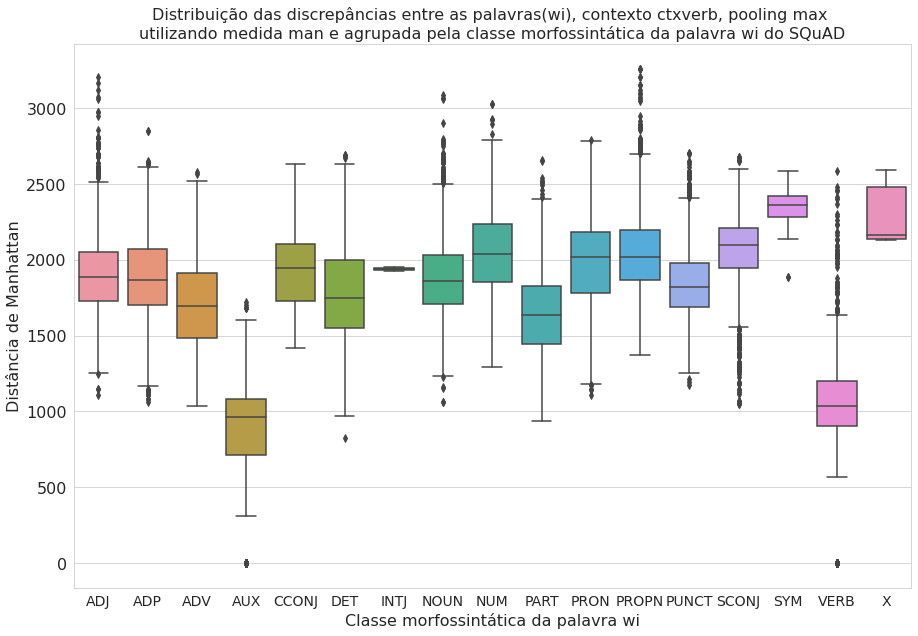

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

### Contexto com palavras da classe NOUN(ctxnoun)

In [ ]:
equacao_medida = "ctxnoun"

#### COS

In [ ]:
medida = "cos"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std       min      25%      50%      75%  \
pos_i                                                                      
ADJ   2077.000000 0.676771 0.120240 -0.240344 0.643395 0.692194 0.737646   
ADP   3355.000000 0.567341 0.230351 -0.257124 0.546357 0.635361 0.693925   
ADV    476.000000 0.615230 0.080674  0.351224 0.566991 0.619567 0.671314   
AUX   2276.000000 0.644016 0.069431 -0.206595 0.605807 0.648691 0.688833   
CCONJ  271.000000 0.518669 0.241982 -0.265209 0.518808 0.587215 0.655291   
DET   3163.000000 0.567096 0.223556 -0.260678 0.510220 0.639020 0.696990   
INTJ     2.000000 0.743592 0.004196  0.740624 0.742108 0.743592 0.745075   
NOUN  6055.000000 0.880184 0.070415  0.022611 0.841037 0.877510 0.913032   
NUM    381.000000 0.606252 0.077424  0.212390 0.559892 0.617093 0.656361   
PART   625.000000 0.607459 0.151974 -0.204724 0.572628 0.635671 0.687323   
PRON  1724.000000 0.517690 0.116619 -0.243586 0.433089 0.483588 0.615361   
PROPN 2795.000000 0.614838 0.078945  0.217550 0.565208 0.616380 0.670280   
PUNCT 2948.000000 0.541146 0.149310 -0.303819 0.526962 0.568204 0.603239   
SCONJ  671.000000 0.473889 0.107989  0.245992 0.397135 0.449906 0.539135   
SYM     13.000000 0.557764 0.085838  0.422926 0.495613 0.530906 0.609226   
VERB  2648.000000 0.655834 0.078364 -0.137425 0.609626 0.662787 0.711252   
X        6.000000 0.573419 0.124405  0.471269 0.482088 0.514385 0.681693   

           max  
pos_i           
ADJ   0.863209  
ADP   0.835384  
ADV   0.910171  
AUX   0.806131  
CCONJ 0.732810  
DET   0.860361  
INTJ  0.746559  
NOUN  1.000000  
NUM   0.849031  
PART  0.851895  
PRON  0.816032  
PROPN 0.910830  
PUNCT 0.767157  
SCONJ 0.778184  
SYM   0.708076  
VERB  0.852888  
X     0.731690

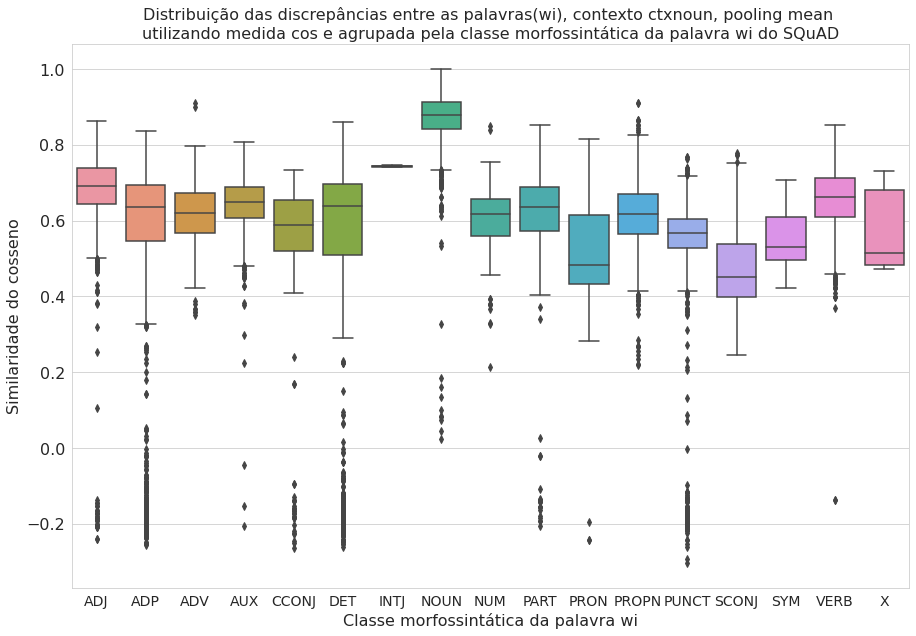

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std       min      25%      50%      75%  \
pos_i                                                                      
ADJ   2077.000000 0.667207 0.123597 -0.240344 0.628146 0.684752 0.733426   
ADP   3355.000000 0.567341 0.230351 -0.257124 0.546357 0.635361 0.693925   
ADV    476.000000 0.613917 0.081611  0.351224 0.567367 0.617230 0.671074   
AUX   2276.000000 0.644318 0.068799 -0.206595 0.605807 0.648691 0.688833   
CCONJ  271.000000 0.517818 0.241593 -0.265209 0.518808 0.586813 0.654226   
DET   3163.000000 0.566965 0.223529 -0.260678 0.510220 0.638666 0.696990   
INTJ     2.000000 0.743592 0.004196  0.740624 0.742108 0.743592 0.745075   
NOUN  6055.000000 0.868866 0.079932  0.022611 0.829718 0.873111 0.908909   
NUM    381.000000 0.597321 0.079662  0.212390 0.550753 0.607902 0.653619   
PART   625.000000 0.604317 0.150607 -0.204724 0.572315 0.634756 0.681366   
PRON  1724.000000 0.517455 0.116544 -0.243586 0.433089 0.483444 0.613611   
PROPN 2795.000000 0.591480 0.082434  0.217550 0.536154 0.594906 0.649884   
PUNCT 2948.000000 0.541146 0.149310 -0.303819 0.526962 0.568204 0.603239   
SCONJ  671.000000 0.473504 0.108112  0.245992 0.396200 0.447453 0.539135   
SYM     13.000000 0.547992 0.073669  0.422926 0.495613 0.530906 0.605546   
VERB  2648.000000 0.652624 0.079985 -0.137425 0.605480 0.659615 0.709708   
X        6.000000 0.573419 0.124405  0.471269 0.482088 0.514385 0.681693   

           max  
pos_i           
ADJ   0.863209  
ADP   0.835384  
ADV   0.910171  
AUX   0.806131  
CCONJ 0.732810  
DET   0.860361  
INTJ  0.746559  
NOUN  1.000000  
NUM   0.849031  
PART  0.851895  
PRON  0.816032  
PROPN 0.863986  
PUNCT 0.767157  
SCONJ 0.778184  
SYM   0.662050  
VERB  0.852888  
X     0.731690

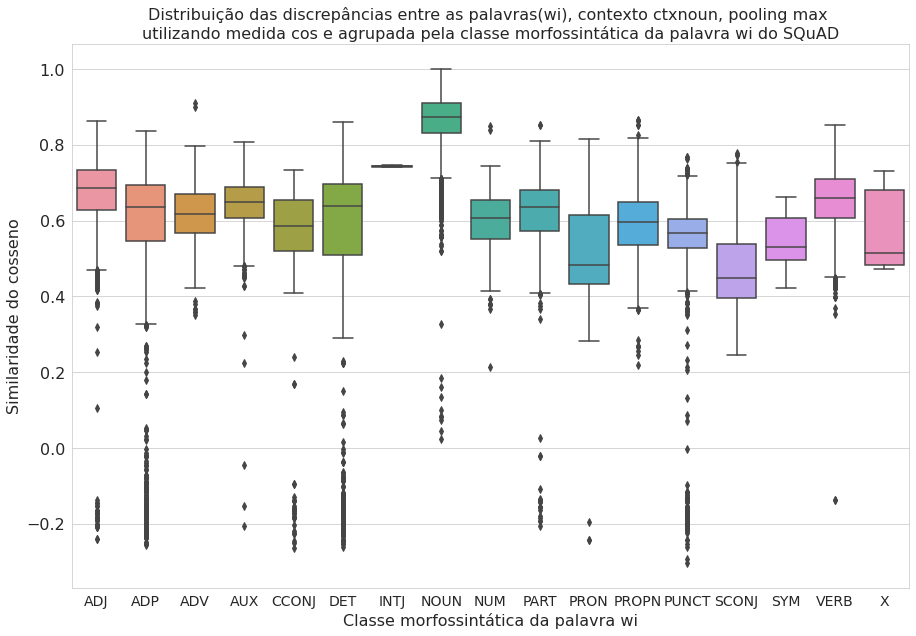

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

#### EUC

In [ ]:
medida = "euc"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                          
ADJ   2077.000000 33.638199 4.909198 20.981749 30.325930 33.111034 36.442734   
ADP   3355.000000 38.362173 6.171563 23.945799 33.646221 37.147217 42.371466   
ADV    476.000000 37.679601 4.899221 19.070795 34.038596 37.465532 40.865269   
AUX   2276.000000 36.145889 3.960473 25.890686 33.329412 35.789259 38.642483   
CCONJ  271.000000 39.592691 5.700198 29.618608 34.923105 38.722790 43.200441   
DET   3163.000000 38.185717 6.500166 23.353022 33.137861 36.558788 43.236942   
INTJ     2.000000 31.106380 0.334467 30.869877 30.988129 31.106380 31.224632   
NOUN  6055.000000 19.116736 8.036059  0.000000 17.822170 21.040995 23.792994   
NUM    381.000000 38.148184 4.754818 24.951895 35.054192 37.608318 40.944405   
PART   625.000000 36.641695 5.270468 23.247017 33.110573 36.081749 39.508835   
PRON  1724.000000 42.231767 5.971011 25.862417 37.305559 43.765491 46.594744   
PROPN 2795.000000 36.908659 4.999085 16.278669 33.280317 36.644417 40.350090   
PUNCT 2948.000000 39.751742 4.124414 29.332981 37.015379 39.018486 41.994082   
SCONJ  671.000000 44.722203 5.837561 27.833393 41.721991 45.622604 48.752529   
SYM     13.000000 41.450306 5.379693 29.702469 37.453819 43.492664 45.062134   
VERB  2648.000000 35.495837 4.685970 22.252539 32.133248 35.117876 38.347888   
X        6.000000 40.801163 7.528429 31.258795 34.198344 44.230150 46.410155   

            max  
pos_i            
ADJ   55.506878  
ADP   57.273426  
ADV   52.046871  
AUX   56.703041  
CCONJ 53.584702  
DET   56.240677  
INTJ  31.342884  
NOUN  39.371788  
NUM   53.168400  
PART  56.334843  
PRON  57.623577  
PROPN 53.218239  
PUNCT 56.462887  
SCONJ 59.477032  
SYM   49.913795  
VERB  54.982056  
X     47.096653

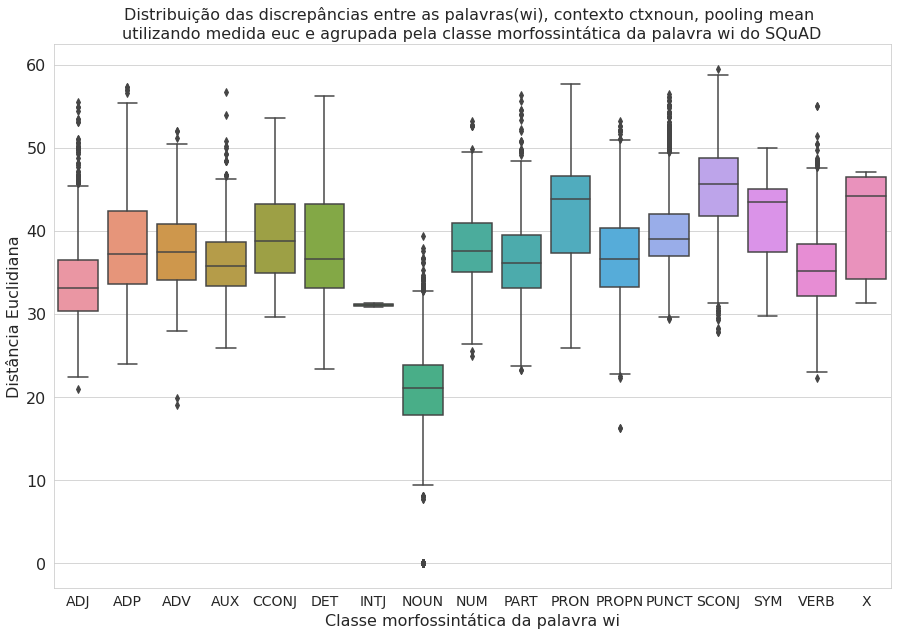

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                          
ADJ   2077.000000 34.570035 5.511548 20.981749 30.844894 33.762081 37.511372   
ADP   3355.000000 38.362173 6.171563 23.945799 33.646221 37.147217 42.371466   
ADV    476.000000 37.855634 4.979017 19.070795 34.155182 37.664093 40.904756   
AUX   2276.000000 36.148393 3.959804 25.890686 33.332875 35.793098 38.642483   
CCONJ  271.000000 39.674881 5.640714 30.146397 35.096909 38.752651 43.200441   
DET   3163.000000 38.197882 6.499368 23.353022 33.144405 36.606491 43.248085   
INTJ     2.000000 31.106380 0.334467 30.869877 30.988129 31.106380 31.224632   
NOUN  6055.000000 20.361157 8.596564  0.000000 18.414997 21.616581 24.912964   
NUM    381.000000 39.105919 5.246134 24.951895 35.418732 38.096226 41.829529   
PART   625.000000 37.488751 5.391002 23.247017 33.817738 36.707626 40.392750   
PRON  1724.000000 42.252646 5.968256 25.862417 37.458184 43.785133 46.594744   
PROPN 2795.000000 39.244764 5.475737 22.793770 35.196974 38.705898 42.831562   
PUNCT 2948.000000 39.751742 4.124414 29.332981 37.015379 39.018486 41.994082   
SCONJ  671.000000 44.757219 5.854697 27.833393 41.773808 45.632488 48.778122   
SYM     13.000000 42.451558 4.060561 37.363365 37.738255 43.492664 45.062134   
VERB  2648.000000 35.830864 4.800899 22.975374 32.401003 35.436516 38.671419   
X        6.000000 40.801163 7.528429 31.258795 34.198344 44.230150 46.410155   

            max  
pos_i            
ADJ   57.257992  
ADP   57.273426  
ADV   52.046871  
AUX   56.703041  
CCONJ 53.584702  
DET   56.240677  
INTJ  31.342884  
NOUN  50.862572  
NUM   55.021214  
PART  56.334843  
PRON  57.623577  
PROPN 61.106171  
PUNCT 56.462887  
SCONJ 59.477032  
SYM   49.913795  
VERB  54.982056  
X     47.096653

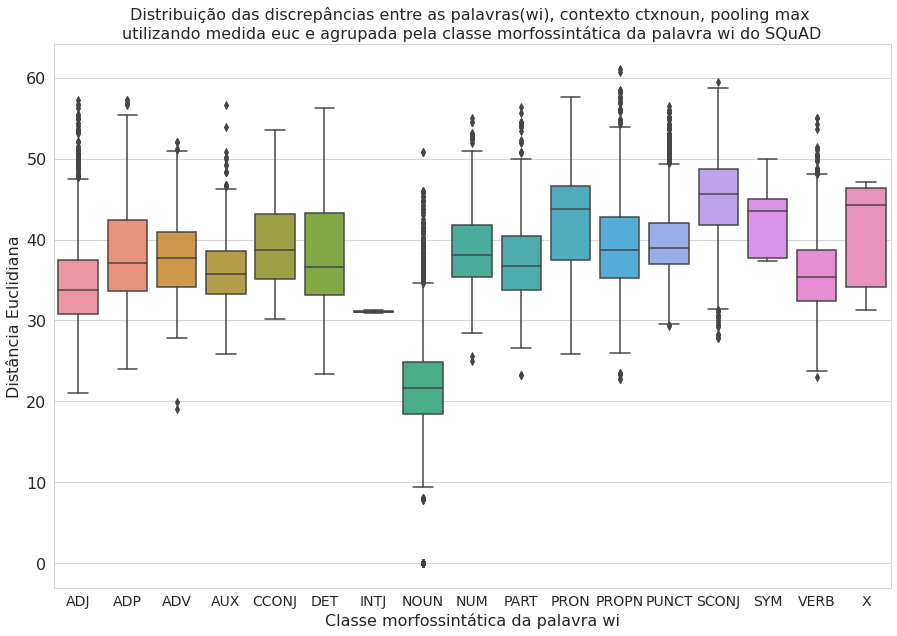

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

#### MAN

In [ ]:
medida = "man"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                          
ADJ   2077.000000 1672.999379 231.943447 1039.696045 1513.281616 1654.781982   
ADP   3355.000000 1858.188404 263.197311 1226.567383 1662.835938 1827.888184   
ADV    476.000000 1893.760304 249.387185  959.587891 1709.166260 1881.595825   
AUX   2276.000000 1824.223351 198.062759 1293.038330 1683.696442 1807.690308   
CCONJ  271.000000 1903.182268 245.127103 1303.106934 1719.352417 1909.772705   
DET   3163.000000 1850.826928 278.084593 1175.996460 1641.083679 1793.941528   
INTJ     2.000000 1571.617004  19.832049 1557.593628 1564.605316 1571.617004   
NOUN  6055.000000  954.700089 401.621833    0.000000  890.585510 1049.510986   
NUM    381.000000 1916.146744 241.039712 1251.865601 1767.699097 1896.198730   
PART   625.000000 1816.520479 246.612810 1023.152100 1654.431396 1808.073730   
PRON  1724.000000 2097.637147 282.426828 1308.189819 1879.747559 2155.922363   
PROPN 2795.000000 1841.487693 256.893599  819.549316 1662.186035 1827.123535   
PUNCT 2948.000000 1979.170000 189.951221 1408.586060 1859.905212 1961.251221   
SCONJ  671.000000 2220.719177 278.245523 1397.163696 2067.298706 2252.641602   
SYM     13.000000 2091.635648 269.936254 1511.291382 1890.245117 2209.416748   
VERB  2648.000000 1787.281695 237.028828 1106.121582 1613.358398 1771.020752   
X        6.000000 2059.253174 379.522284 1576.514771 1727.603363 2243.311035   

              75%         max  
pos_i                          
ADJ   1822.465454 2470.935059  
ADP   2043.052002 2805.372559  
ADV   2058.395813 2554.914551  
AUX   1954.675873 2568.001709  
CCONJ 2062.130493 2494.412598  
DET   2045.814575 2763.335449  
INTJ  1578.628693 1585.640381  
NOUN  1186.907227 1837.491943  
NUM   2057.475098 2676.771729  
PART  1982.494873 2521.940430  
PRON  2305.339233 2802.621094  
PROPN 2016.094604 2657.245117  
PUNCT 2097.010437 2780.532471  
SCONJ 2406.989502 2929.408203  
SYM   2277.206299 2501.867920  
VERB  1936.403931 2556.067383  
X     2338.604980 2366.311768

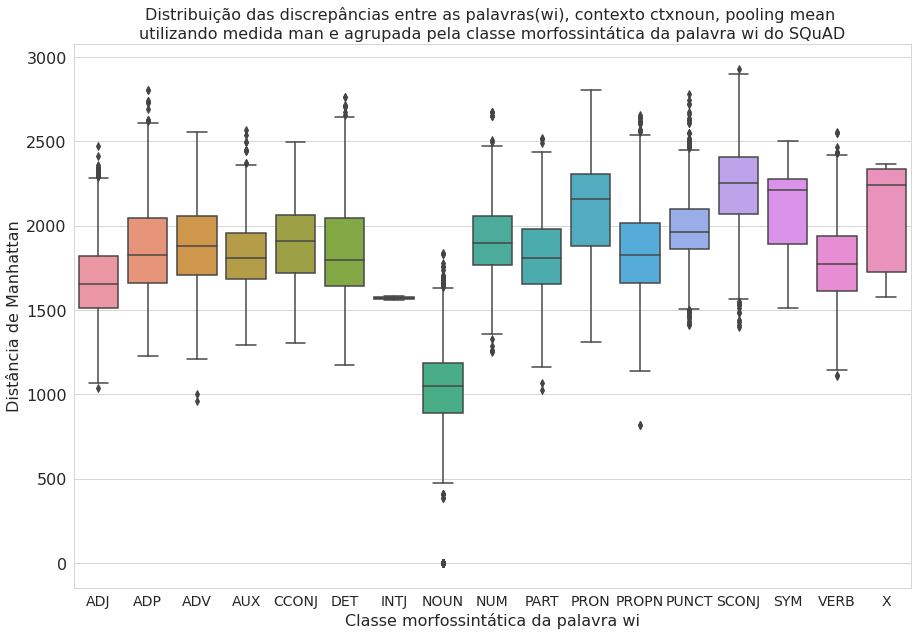

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                          
ADJ   2077.000000 1723.723873 269.385247 1039.696045 1543.422852 1691.595703   
ADP   3355.000000 1858.188404 263.197311 1226.567383 1662.835938 1827.888184   
ADV    476.000000 1903.776868 250.165494  959.587891 1716.239197 1897.819092   
AUX   2276.000000 1824.849181 197.742677 1293.038330 1684.478882 1807.737854   
CCONJ  271.000000 1907.655954 243.204997 1303.106934 1728.109436 1914.761353   
DET   3163.000000 1851.410501 278.184049 1175.996460 1641.346191 1794.248779   
INTJ     2.000000 1571.617004  19.832049 1557.593628 1564.605316 1571.617004   
NOUN  6055.000000 1020.165632 435.519312    0.000000  918.766968 1080.824463   
NUM    381.000000 1968.805465 268.116628 1256.552490 1783.684326 1913.343750   
PART   625.000000 1870.883876 245.838998 1175.392822 1706.018066 1852.261230   
PRON  1724.000000 2098.644100 282.355742 1308.189819 1882.478058 2156.882324   
PROPN 2795.000000 1965.910055 285.417303 1141.688477 1757.534729 1937.677734   
PUNCT 2948.000000 1979.170000 189.951221 1408.586060 1859.905212 1961.251221   
SCONJ  671.000000 2222.453135 279.270215 1397.163696 2067.298706 2253.345703   
SYM     13.000000 2142.884681 206.321174 1868.479980 1901.126831 2209.416748   
VERB  2648.000000 1805.571179 243.020334 1144.702393 1632.080048 1788.273376   
X        6.000000 2059.253174 379.522284 1576.514771 1727.603363 2243.311035   

              75%         max  
pos_i                          
ADJ   1871.636475 3088.922363  
ADP   2043.052002 2805.372559  
ADV   2066.452576 2565.371826  
AUX   1955.060638 2568.001709  
CCONJ 2067.953613 2494.412598  
DET   2047.770691 2763.335449  
INTJ  1578.628693 1585.640381  
NOUN  1246.311157 2725.454102  
NUM   2114.774902 2855.329102  
PART  2021.993408 2827.920654  
PRON  2305.992920 2802.621094  
PROPN 2149.319580 3142.991211  
PUNCT 2097.010437 2780.532471  
SCONJ 2411.237305 2929.408203  
SYM   2277.206299 2501.867920  
VERB  1953.002808 2780.310791  
X     2338.604980 2366.311768

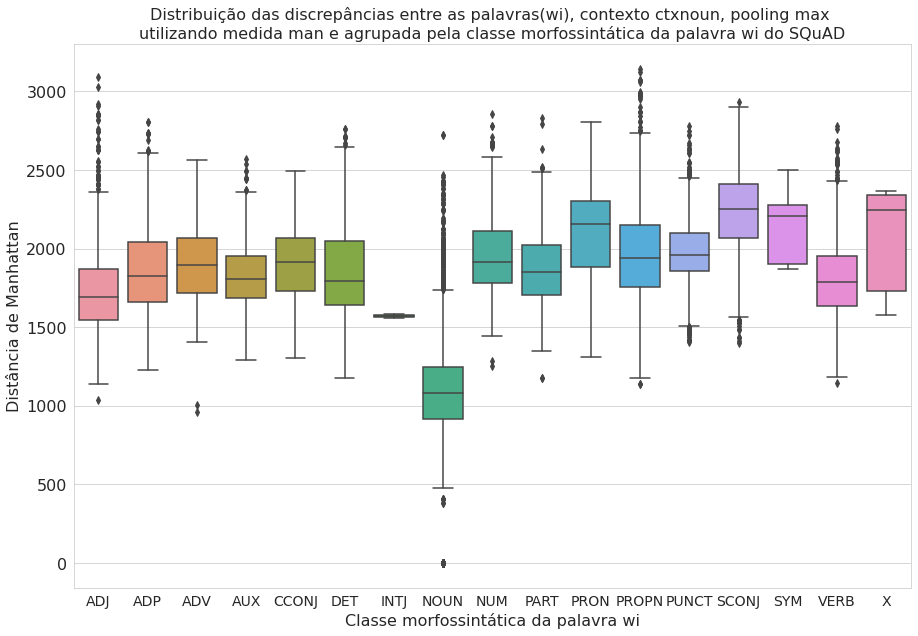

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

### Contexto com palavras da classe VERB(AUX) e NOUN(ctxverbnoun)

In [ ]:
equacao_medida = "ctxverbnoun"

#### COS

In [ ]:
medida = "cos"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std       min      25%      50%      75%  \
pos_i                                                                      
ADJ   2144.000000 0.702890 0.115516 -0.257169 0.676207 0.718702 0.755098   
ADP   3527.000000 0.618859 0.236589 -0.259451 0.616218 0.689981 0.739497   
ADV    527.000000 0.710318 0.081040  0.358119 0.672414 0.726106 0.764917   
AUX   2527.000000 0.845524 0.058796  0.048271 0.819749 0.845952 0.876751   
CCONJ  291.000000 0.563336 0.251745 -0.266218 0.576143 0.628418 0.695883   
DET   3317.000000 0.633734 0.235982 -0.257478 0.581790 0.720200 0.766522   
INTJ     2.000000 0.735729 0.005260  0.732009 0.733869 0.735729 0.737588   
NOUN  6055.000000 0.830350 0.055481 -0.041515 0.805600 0.834755 0.861102   
NUM    428.000000 0.639261 0.075624  0.389915 0.598405 0.646378 0.692563   
PART   644.000000 0.701126 0.159357 -0.197072 0.684824 0.733000 0.779245   
PRON  1895.000000 0.587859 0.114265 -0.235700 0.504687 0.555329 0.685035   
PROPN 3395.000000 0.648927 0.067723  0.267177 0.608793 0.653134 0.695350   
PUNCT 3263.000000 0.622009 0.160470 -0.300637 0.612314 0.650541 0.687643   
SCONJ  814.000000 0.551085 0.107303  0.352253 0.479062 0.522470 0.599988   
SYM     14.000000 0.578694 0.084922  0.496838 0.517616 0.530909 0.617714   
VERB  2895.000000 0.836039 0.055858  0.065938 0.807182 0.838055 0.869528   
X        7.000000 0.571717 0.083464  0.477600 0.521971 0.551474 0.621869   

           max  
pos_i           
ADJ   0.897261  
ADP   0.877715  
ADV   0.861360  
AUX   1.000000  
CCONJ 0.780782  
DET   0.914282  
INTJ  0.739448  
NOUN  1.000000  
NUM   0.816082  
PART  0.876120  
PRON  0.851307  
PROPN 0.837024  
PUNCT 0.831429  
SCONJ 0.855295  
SYM   0.772571  
VERB  1.000000  
X     0.685261

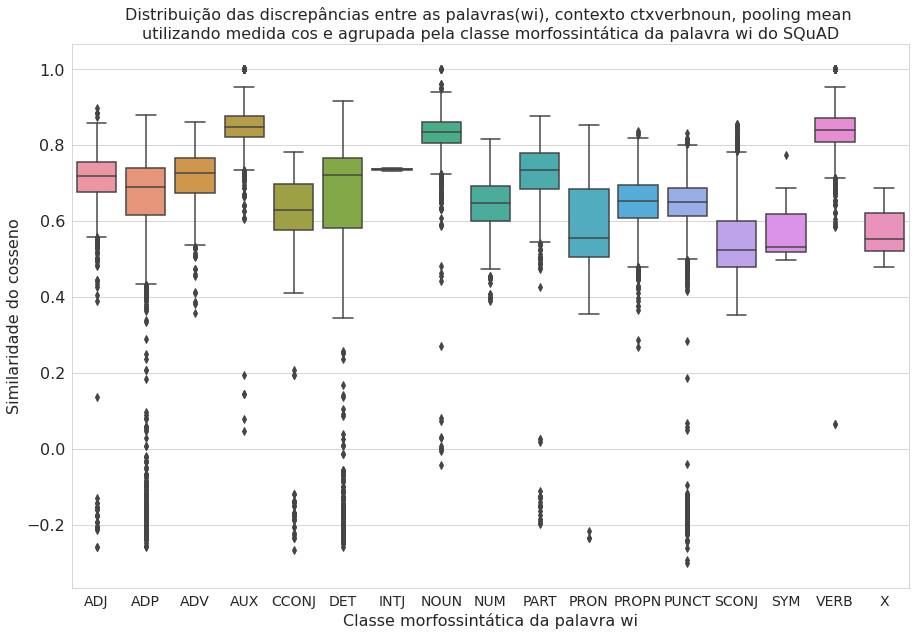

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std       min      25%      50%      75%  \
pos_i                                                                      
ADJ   2144.000000 0.693248 0.119855 -0.257169 0.664758 0.714045 0.751221   
ADP   3527.000000 0.618859 0.236589 -0.259451 0.616218 0.689981 0.739497   
ADV    527.000000 0.708535 0.081535  0.358119 0.669978 0.722246 0.764355   
AUX   2527.000000 0.845585 0.058466  0.048271 0.819689 0.845952 0.876751   
CCONJ  291.000000 0.562472 0.251379 -0.266218 0.576143 0.628055 0.693775   
DET   3317.000000 0.633594 0.235954 -0.257478 0.581790 0.720100 0.766522   
INTJ     2.000000 0.735729 0.005260  0.732009 0.733869 0.735729 0.737588   
NOUN  6055.000000 0.820248 0.065579 -0.041515 0.795883 0.829348 0.857713   
NUM    428.000000 0.630446 0.078548  0.389915 0.589087 0.640609 0.683605   
PART   644.000000 0.696149 0.158897 -0.197072 0.679233 0.723717 0.775244   
PRON  1895.000000 0.587637 0.114283 -0.235700 0.504587 0.555026 0.685035   
PROPN 3395.000000 0.622864 0.072839  0.364320 0.575214 0.631311 0.675291   
PUNCT 3263.000000 0.622009 0.160470 -0.300637 0.612314 0.650541 0.687643   
SCONJ  814.000000 0.550693 0.107338  0.352253 0.478918 0.521549 0.598798   
SYM     14.000000 0.567523 0.065529  0.496838 0.517616 0.530909 0.616540   
VERB  2895.000000 0.831800 0.062793  0.065938 0.803798 0.836599 0.868831   
X        7.000000 0.571717 0.083464  0.477600 0.521971 0.551474 0.621869   

           max  
pos_i           
ADJ   0.897261  
ADP   0.877715  
ADV   0.861360  
AUX   1.000000  
CCONJ 0.780782  
DET   0.914282  
INTJ  0.739448  
NOUN  1.000000  
NUM   0.816082  
PART  0.876120  
PRON  0.851307  
PROPN 0.837024  
PUNCT 0.831429  
SCONJ 0.855295  
SYM   0.686960  
VERB  1.000000  
X     0.685261

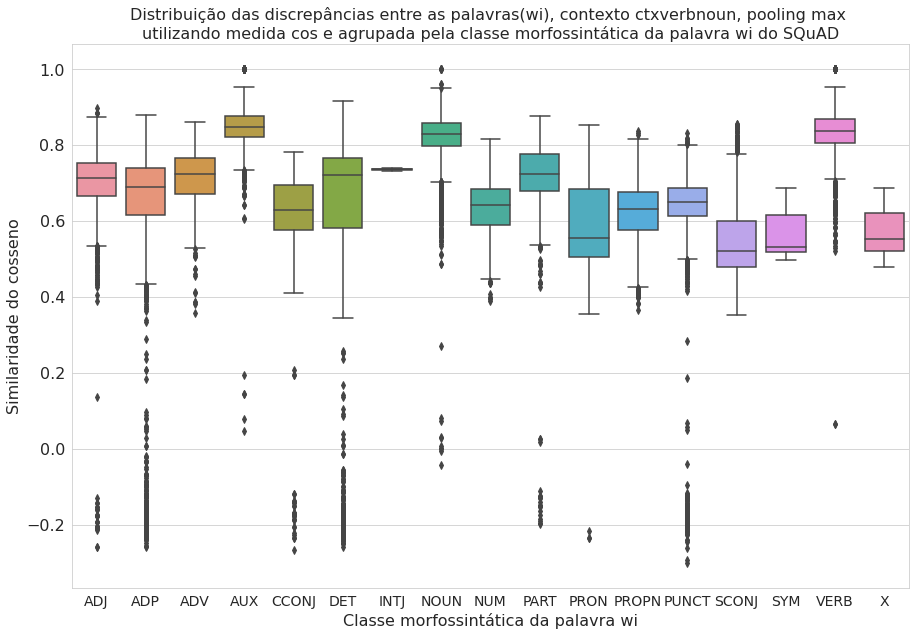

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

#### EUC

In [ ]:
medida = "euc"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                          
ADJ   2144.000000 31.760841 4.324442 19.227724 28.996726 31.233642 33.994990   
ADP   3527.000000 35.275659 6.083386 22.056976 31.027409 33.932384 38.315004   
ADV    527.000000 32.203225 4.854444 21.804815 28.926459 31.635792 34.474964   
AUX   2527.000000 23.431837 4.753513  0.000000 21.542783 23.941551 26.034052   
CCONJ  291.000000 36.996639 5.677213 27.791336 32.693338 36.572845 39.507223   
DET   3317.000000 34.248274 6.978265 16.701679 29.063322 31.983158 39.172443   
INTJ     2.000000 31.516336 0.388266 31.241791 31.379064 31.516336 31.653609   
NOUN  6055.000000 24.226423 3.390877  0.000000 22.082335 24.209312 26.275949   
NUM    428.000000 35.812532 4.565271 25.323452 32.707423 35.405643 38.486012   
PART   644.000000 31.181037 4.801169 21.349014 28.147734 30.669924 32.878754   
PRON  1895.000000 38.318852 5.862118 22.653864 33.494795 40.279369 42.670120   
PROPN 3395.000000 34.331116 4.294376 22.697392 31.426817 34.066132 36.973627   
PUNCT 3263.000000 35.232413 4.280141 24.872496 32.600475 34.644077 36.843987   
SCONJ  814.000000 40.477305 5.693019 21.560846 38.625117 42.041462 44.302263   
SYM     14.000000 39.914263 5.669670 26.115873 36.998655 41.558945 43.333261   
VERB  2895.000000 24.326164 4.521906  0.000000 22.097265 24.546268 26.895276   
X        7.000000 40.452296 5.019174 33.588047 37.250944 41.409618 43.896427   

            max  
pos_i            
ADJ   51.697536  
ADP   52.831692  
ADV   52.046871  
AUX   40.038471  
CCONJ 50.403431  
DET   52.704205  
INTJ  31.790882  
NOUN  41.524250  
NUM   51.417652  
PART  50.575584  
PRON  51.925480  
PROPN 52.095482  
PUNCT 54.833580  
SCONJ 51.872169  
SYM   47.807522  
VERB  40.631443  
X     45.873661

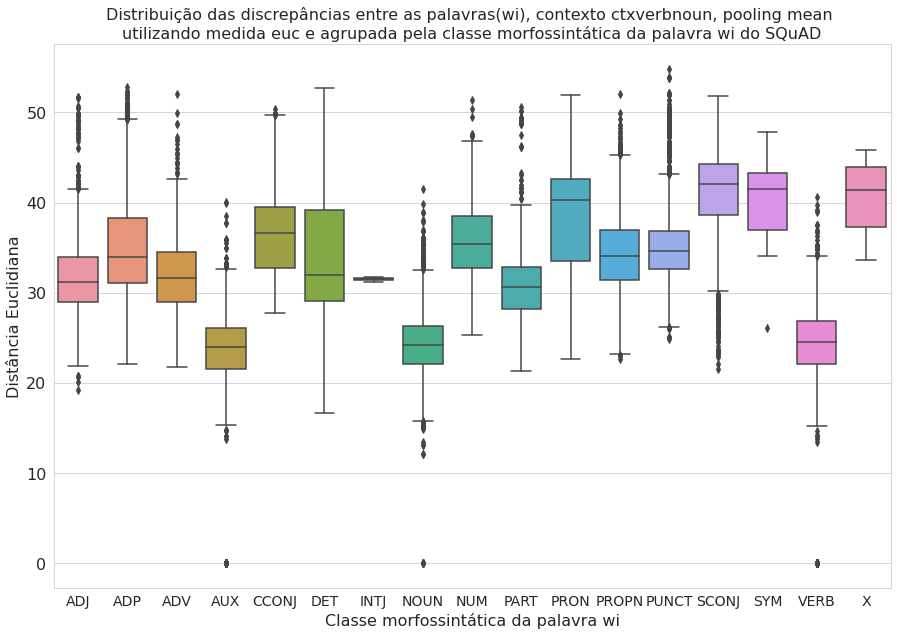

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                          
ADJ   2144.000000 32.722745 5.037125 19.227724 29.496482 31.872301 35.047745   
ADP   3527.000000 35.275659 6.083386 22.056976 31.027409 33.932384 38.315004   
ADV    527.000000 32.416465 4.913611 21.804815 29.133889 31.900723 35.020889   
AUX   2527.000000 23.447706 4.768157  0.000000 21.542783 23.947954 26.053258   
CCONJ  291.000000 37.077746 5.630351 27.892727 32.772665 36.652172 39.577820   
DET   3317.000000 34.261445 6.976251 16.701679 29.069567 32.002502 39.172443   
INTJ     2.000000 31.516336 0.388266 31.241791 31.379064 31.516336 31.653609   
NOUN  6055.000000 25.231708 4.379315  0.000000 22.616647 24.736525 27.154864   
NUM    428.000000 36.756174 5.026882 25.368835 33.289696 35.760618 39.394246   
PART   644.000000 32.165493 5.319017 21.349014 28.463031 31.565021 34.323359   
PRON  1895.000000 38.338940 5.864678 22.653864 33.498672 40.298523 42.687756   
PROPN 3395.000000 36.904960 4.959764 23.746931 33.334343 36.046467 39.804789   
PUNCT 3263.000000 35.232413 4.280141 24.872496 32.600475 34.644077 36.843987   
SCONJ  814.000000 40.510949 5.696667 21.560846 38.677814 42.064285 44.338489   
SYM     14.000000 40.978841 4.046343 34.082954 38.038989 41.558945 43.333261   
VERB  2895.000000 24.754988 5.031032  0.000000 22.232327 24.786674 27.265338   
X        7.000000 40.452296 5.019174 33.588047 37.250944 41.409618 43.896427   

            max  
pos_i            
ADJ   56.763432  
ADP   52.831692  
ADV   52.046871  
AUX   40.038471  
CCONJ 50.403431  
DET   52.704205  
INTJ  31.790882  
NOUN  51.008263  
NUM   53.688576  
PART  50.575584  
PRON  51.925480  
PROPN 57.873421  
PUNCT 54.833580  
SCONJ 51.872169  
SYM   47.807522  
VERB  49.032181  
X     45.873661

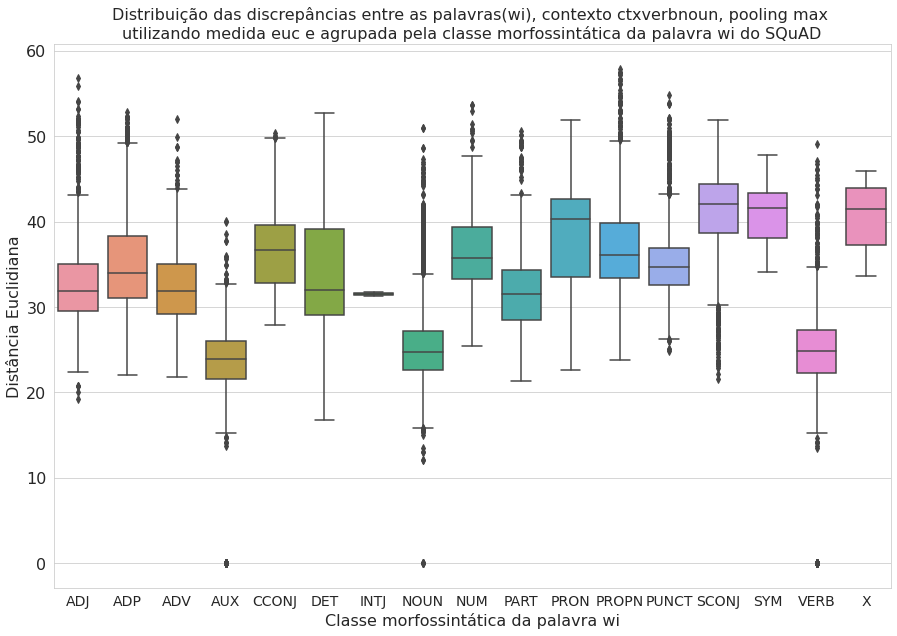

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

#### MAN

In [ ]:
medida = "man"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                          
ADJ   2144.000000 1580.845955 198.447323  967.709656 1447.340393 1563.161560   
ADP   3527.000000 1705.049790 236.199367 1118.561035 1535.674316 1677.535889   
ADV    527.000000 1620.510804 243.241204 1084.294556 1453.004639 1590.710205   
AUX   2527.000000 1183.122255 238.619540    0.000000 1089.116699 1208.570801   
CCONJ  291.000000 1774.538794 231.820757 1310.801270 1596.529297 1781.659180   
DET   3317.000000 1651.925591 277.966763  836.648071 1448.670044 1582.392334   
INTJ     2.000000 1589.406311  19.824626 1575.388184 1582.397247 1589.406311   
NOUN  6055.000000 1213.047772 169.823894    0.000000 1103.569702 1211.260010   
NUM    428.000000 1802.756224 234.613583 1165.605591 1641.764526 1778.666199   
PART   644.000000 1540.692499 199.110286 1003.133911 1405.784485 1539.731567   
PRON  1895.000000 1891.128661 267.868707 1141.385498 1691.808044 1962.125977   
PROPN 3395.000000 1717.164650 221.007105 1128.713867 1570.475952 1707.197021   
PUNCT 3263.000000 1753.834459 178.863972 1197.402588 1639.004517 1743.913818   
SCONJ  814.000000 1985.645388 258.927335 1091.687012 1909.429535 2049.630005   
SYM     14.000000 2019.127494 290.303590 1325.048584 1863.163757 2134.794922   
VERB  2895.000000 1226.038177 227.553703    0.000000 1113.761658 1237.498047   
X        7.000000 2042.953997 249.325820 1697.550781 1884.275391 2105.378662   

              75%         max  
pos_i                          
ADJ   1699.700195 2350.790771  
ADP   1852.658936 2480.222412  
ADV   1750.641296 2554.914551  
AUX   1317.130737 2021.161377  
CCONJ 1924.189941 2336.726562  
DET   1798.812378 2506.739258  
INTJ  1596.415375 1603.424438  
NOUN  1318.483459 1843.390137  
NUM   1935.991425 2612.220459  
PART  1648.747559 2172.030273  
PRON  2091.534668 2635.469238  
PROPN 1853.141357 2592.768799  
PUNCT 1851.185974 2482.311035  
SCONJ 2157.873291 2551.071289  
SYM   2199.757996 2419.234863  
VERB  1359.444153 2027.508545  
X     2215.071045 2299.055664

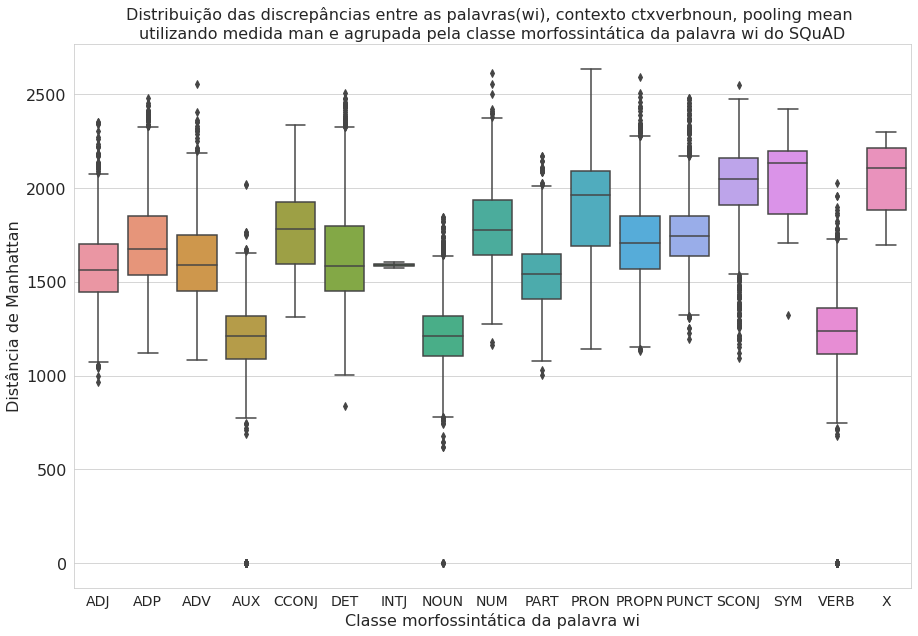

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                          
ADJ   2144.000000 1633.253512 244.057247  967.709656 1474.220215 1596.581665   
ADP   3527.000000 1705.049790 236.199367 1118.561035 1535.674316 1677.535889   
ADV    527.000000 1632.299467 244.568836 1084.294556 1465.615784 1607.319946   
AUX   2527.000000 1184.279832 239.233829    0.000000 1089.540344 1209.640259   
CCONJ  291.000000 1778.916673 230.726582 1310.801270 1598.623291 1788.869873   
DET   3317.000000 1652.534148 277.995545  836.648071 1449.721436 1583.309326   
INTJ     2.000000 1589.406311  19.824626 1575.388184 1582.397247 1589.406311   
NOUN  6055.000000 1266.322006 225.783378    0.000000 1132.987915 1240.695068   
NUM    428.000000 1854.586358 260.197895 1275.194580 1672.557129 1808.672546   
PART   644.000000 1602.758824 228.240721 1079.047119 1443.180176 1584.243469   
PRON  1895.000000 1892.114591 268.122615 1141.385498 1691.907837 1964.336060   
PROPN 3395.000000 1853.319634 260.354195 1197.365723 1666.239502 1807.097900   
PUNCT 3263.000000 1753.834459 178.863972 1197.402588 1639.004517 1743.913818   
SCONJ  814.000000 1987.300784 259.484998 1091.687012 1910.423889 2050.683838   
SYM     14.000000 2074.750296 210.803257 1706.804321 1917.327515 2134.794922   
VERB  2895.000000 1249.125566 256.171195    0.000000 1123.550049 1251.074585   
X        7.000000 2042.953997 249.325820 1697.550781 1884.275391 2105.378662   

              75%         max  
pos_i                          
ADJ   1753.434692 3067.160156  
ADP   1852.658936 2480.222412  
ADV   1759.759583 2554.914551  
AUX   1318.050598 2021.161377  
CCONJ 1924.681335 2336.726562  
DET   1800.442139 2506.739258  
INTJ  1596.415375 1603.424438  
NOUN  1360.448608 2733.724854  
NUM   1989.435730 2760.132812  
PART  1711.226074 2474.489746  
PRON  2092.228760 2635.469238  
PROPN 1995.470947 3047.439453  
PUNCT 1851.185974 2482.311035  
SCONJ 2162.258118 2551.071289  
SYM   2199.757996 2419.234863  
VERB  1375.003479 2590.377441  
X     2215.071045 2299.055664

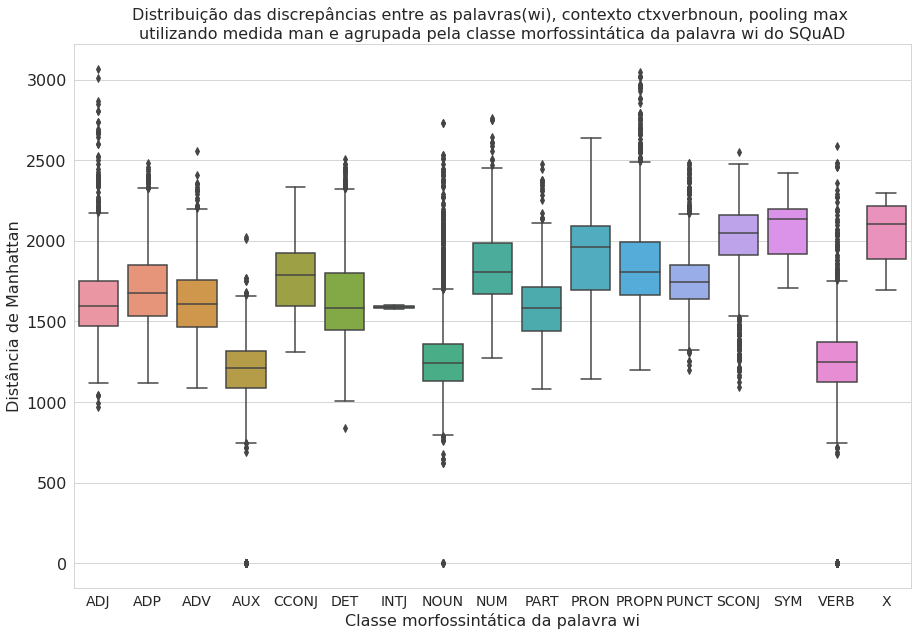

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do SQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

## 3.5 Estatísticas das discrepâncias do contexto e palavras

### Geral

Conta pares de classes de palavras

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_bar = tqdm_notebook(lista_comparacao_contexto.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_contexto))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_bar:  
  #if i < 10:             
    contador[linha_comparacao[4]] += 1

Documentos:   0%|          | 0/31751 [00:00<?, ? documento/s]

Ordenada as contagens dos pares

In [ ]:
top = 10
dicdados = {}
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    dicdados.update({item: contador[item]})    

Mostra o gráfico

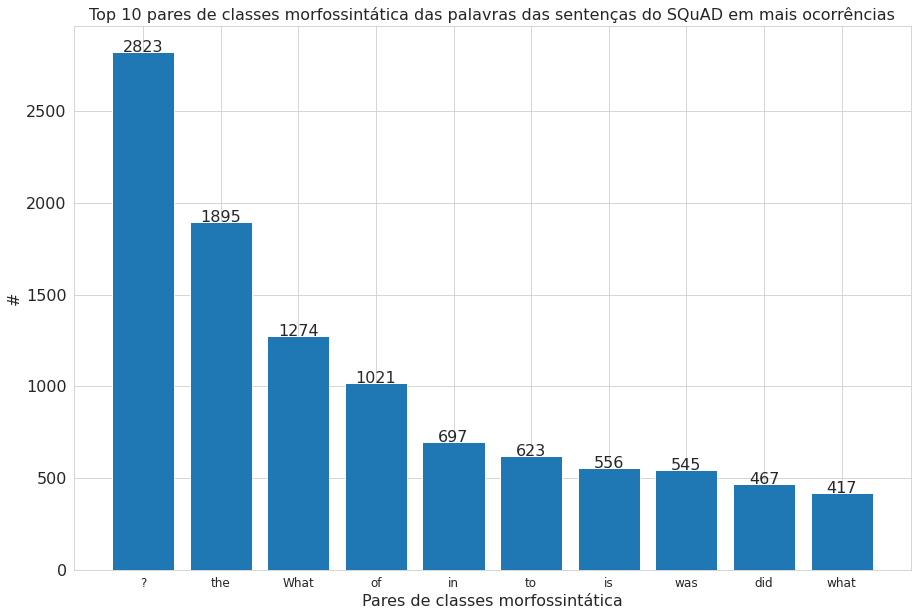

In [ ]:
# Import da biblioteca
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
plt.figure(figsize =(15, 10))

# Recupera os rótulos e os valores
rotulos = list(dicdados.keys())
valores = list(dicdados.values())

# Título do gráfico
plt.title("Top 10 pares de classes morfossintática das palavras das sentenças do SQuAD em mais ocorrências")
# Texto do eixo x
plt.xlabel("Pares de classes morfossintática")
# Texto do eixo y
plt.ylabel("#")

# Insere os dados no gráfico
plt.bar(rotulos, valores)

plt.xticks(fontsize=12)

# Adiciona os rótulos as barras
for i in range(len(valores)):
  plt.annotate(str(valores[i]), xy = (rotulos[i], valores[i]), ha = "center")

# Mostra o gráfico
plt.show()

### Contexto com todas as palavras (ctxall)

#### VERB

In [ ]:
classe_morfosintatica = "VERB"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesVV = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 2895


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxall_mean" ,"euc_ctxall_mean",
                          "man_ctxall_max"  ,"cos_ctxall_max",
                          "euc_ctxall_max"  ,"man_ctxall_max"]].describe(include=["float", "int"]) 

cos_ctxall_mean  euc_ctxall_mean  man_ctxall_max  cos_ctxall_max  \
count      2895.000000      2895.000000     2895.000000     2895.000000   
mean          0.777254        28.317595     1450.270360        0.773030   
std           0.054610         3.447878      185.095680        0.056737   
min          -0.111169        14.621447      902.179200       -0.111169   
25%           0.748232        26.079433     1329.388600        0.744866   
50%           0.781870        28.263968     1439.027600        0.779500   
75%           0.810045        30.503311     1554.291300        0.807913   
max           0.923754        43.906845     2529.345200        0.906236   

       euc_ctxall_max  man_ctxall_max  
count     2895.000000     2895.000000  
mean        28.756063     1450.270360  
std          3.578816      185.095680  
min         18.269419      902.179200  
25%         26.407901     1329.388600  
50%         28.514038     1439.027600  
75%         30.808184     1554.291300  
max         47.237957     2529.345200

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo VERB

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/2895 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        3  394
      2        4  352
      3        5  352
      4        6  322
      5        7  266
      6        2  250
      7        1  217
      8        8  210
      9        9  146
     10       10  118
     11       11   91
     12       12   50
     13       13   45
     14       14   23
     15       15   16
     16        0   15
     17       16   12
     18       19    5
     19       18    5
     20       20    2


##### COS - MEAN

In [ ]:
medida = "cos_ctxall_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.06181269884109497
Limite superior             : 0.9027641415596008
Limite inferior             : 0.655513346195221


Encontra os documentos com as maiores similaridades (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 5 de 2895 ( 0.0017271157167530224 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 47 de 2895 ( 0.01623488773747841 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  52 de 2895 ( 0.017962003454231434 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.9237544536590576 indentured
         When was Punch indentured?

 2 0.9156452417373656 strenthened
         What war strenthened the monarchs position?

 3 0.91329687833786 unserved
         Which two cities are unserved by major airlines?

 4 0.9116517901420592 thrives
         What type of industry thrives in Settle?

 5 0.9062360525131226 became
         What weather condition became much more stable?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxall) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 -0.1111691370606422 -
         When was the Armenian Mosaic re - discovered ?

 2 -0.1111691370606422 -
         When was the Armenian Mosaic re-discovered?

 3 0.5095253586769104 force
         How much did Wilber force Bell gave him in order to look at Gray 's paperwork ?

 4 0.5238640904426575 Given
         Given the weakness of French forces at Louisbourg , what did Loudoun do ?

 5 0.5238640904426575 Given
         Given the weakness of French forces at Louisbourg, what did Loudoun do?


###### Top 5 documentos com as discrepâncias (cos(wi,ctxall) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes = lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 What was closed in order to film a fight sequence using a boat?
       1 0.8079405426979065 film
       2 0.7817140817642212 using
       3 0.6536733508110046 closed

 2 Along with Cooley, from whose work did Scheff derive social bond theory?
       1 0.6517905592918396 derive

 3 Along with Cooley , from whose work did Scheff derive social bond theory ?
       1 0.6517905592918396 derive

 4 Where was Feynman imprisoned after his work at Los Alamos?
       1 0.6503450870513916 imprisoned

 5 Why did Feynman have to turn down an offer from the Institute of Advanced Study ?
       1 0.751521110534668 have
       2 0.649466872215271 turn


##### COS - MAX

In [ ]:
medida = "cos_ctxall_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.06304684281349182
Limite superior             : 0.9024829715490341
Limite inferior             : 0.6502956002950668


Encontra os documentos com as maiores similaridades (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 1 de 2895 ( 0.0003454231433506045 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 73 de 2895 ( 0.02521588946459413 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  74 de 2895 ( 0.025561312607944732 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.9062360525131226 became
         What weather condition became much more stable?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxall) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 -0.1111691370606422 -
         When was the Armenian Mosaic re-discovered?

 2 -0.1111691370606422 -
         When was the Armenian Mosaic re - discovered ?

 3 0.5095253586769104 force
         How much did Wilber force Bell gave him in order to look at Gray 's paperwork ?

 4 0.5238640904426575 Given
         Given the weakness of French forces at Louisbourg, what did Loudoun do?

 5 0.5238640904426575 Given
         Given the weakness of French forces at Louisbourg , what did Loudoun do ?


###### Top 5 documentos com as discrepâncias (cos(wi,ctxall) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Why did Feynman have to turn down an offer from the Institute of Advanced Study ?
       1 0.751521110534668 have
       2 0.649466872215271 turn

 2 How many years of study would it take to obtain a degree from a polytechnic in Singapore?
       1 0.855982780456543 obtain
       2 0.6491613388061523 take

 3 What book did Douglas Stuart summarize?
       1 0.6465824246406555 summarize

 4 What day did Nintendo not unveil the new systems?
       1 0.6465412378311157 unveil

 5 What state 's law states that death sentences must not take place in an " enclosure " ?
       1 0.7549474239349365 states
       2 0.6450464129447937 take


##### EUC - MEAN

In [ ]:
medida = "euc_ctxall_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.42387771606445
Limite superior             : 37.139127731323235
Limite inferior             : 19.443616867065437


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 33 de 2895 ( 0.011398963730569948 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 15 de 2895 ( 0.0051813471502590676 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  48 de 2895 ( 0.016580310880829015 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 43.90684509277344 force
         How much did Wilber force Bell gave him in order to look at Gray 's paperwork ?

 2 42.01612091064453 throw
         What group wanted to use violent means to over throw the British rule ?

 3 42.01612091064453 throw
         What group wanted to use violent means to over throw the British rule?

 4 41.876243591308594 -
         When was the Armenian Mosaic re - discovered ?

 5 41.876243591308594 -
         When was the Armenian Mosaic re-discovered?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxall) < limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 14.62144660949707 strenthened
         What war strenthened the monarchs position?

 2 15.325550079345703 indentured
         When was Punch indentured?

 3 15.880513191223145 unserved
         Which two cities are unserved by major airlines?

 4 16.088274002075195 thrives
         What type of industry thrives in Settle?

 5 17.573240280151367 affixed
         What generation of iPod batterys being affixed with glue ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 How much did Wilber force Bell gave him in order to look at Gray 's paperwork ?
       1 43.90684509277344 force
       2 28.439861297607425 gave
       3 27.74053382873535 look

 2 What group wanted to use violent means to over throw the British rule ?
       1 42.01612091064453 throw
       2 24.21968460083008 wanted
       3 24.1557559967041 use

 3 What group wanted to use violent means to over throw the British rule?
       1 42.01612091064453 throw
       2 24.21968460083008 wanted
       3 24.1557559967041 use

 4 When was the Armenian Mosaic re - discovered ?
       1 41.876243591308594 -
       2 26.781774520874023 discovered

 5 When was the Armenian Mosaic re-discovered?
       1 41.876243591308594 -
       2 26.781774520874023 discovered


##### EUC - MAX

In [ ]:
medida = "euc_ctxall_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.400282859802246
Limite superior             : 37.408607959747314
Limite inferior             : 19.80747652053833


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 69 de 2895 ( 0.02383419689119171 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 3 de 2895 ( 0.0010362694300518134 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  72 de 2895 ( 0.024870466321243522 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 47.23795700073242 diaphragming
         Why did some music lovers frown upon diaphragming?

 2 45.2268180847168 Occupy
         On what date did the Occupy Wall Street protests begin ?

 3 45.19610977172852 affixed
         What generation of iPod batterys being affixed with glue ?

 4 45.00463485717773 Occupy
         On what date did the Occupy Wall Street protests commence?

 5 44.569950103759766 affixed
         What generation saw iPod batterys being affixed with glue?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxall) < limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 18.269418716430664 became
         What weather condition became much more stable?

 2 18.588985443115234 have
         What type of machinery does Punjab not have ?

 3 19.480926513671875 began
         What music began associated with the lower classes?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Why did some music lovers frown upon diaphragming?
       1 47.23795700073242 diaphragming
       2 32.61865234375 frown

 2 On what date did the Occupy Wall Street protests begin ?
       1 45.2268180847168 Occupy
       2 32.67435073852539 begin

 3 What generation of iPod batterys being affixed with glue ?
       1 45.19610977172852 affixed

 4 On what date did the Occupy Wall Street protests commence?
       1 45.00463485717773 Occupy
       2 33.01547622680664 commence

 5 What generation saw iPod batterys being affixed with glue?
       1 44.569950103759766 affixed
       2 28.340240478515625 saw


##### MAN - MEAN

In [ ]:
medida = "man_ctxall_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 228.92745000000014
Limite superior             : 1882.5579750000002
Limite inferior             : 966.8481749999996


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 27 de 2895 ( 0.00932642487046632 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 21 de 2895 ( 0.007253886010362694 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  48 de 2895 ( 0.016580310880829015 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 2209.2607 force
         How much did Wilber force Bell gave him in order to look at Gray 's paperwork ?

 2 2112.647 throw
         What group wanted to use violent means to over throw the British rule ?

 3 2112.647 throw
         What group wanted to use violent means to over throw the British rule?

 4 2089.9243 compromised
         What is compromised of many levels of codified and uncodified forms of law?

 5 2036.9194 providing
         What country fell providing with less information on Canada's army size?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxall) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 737.68164 strenthened
         What war strenthened the monarchs position?

 2 764.59326 indentured
         When was Punch indentured?

 3 806.58594 thrives
         What type of industry thrives in Settle?

 4 810.292 unserved
         Which two cities are unserved by major airlines?

 5 865.6387 expel
         In the Soviet section to the north , what did they have to expel from their land ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 How much did Wilber force Bell gave him in order to look at Gray 's paperwork ?
       1 2209.2607 force
       2 1453.854 gave
       3 1382.1843 look

 2 What group wanted to use violent means to over throw the British rule ?
       1 2112.647 throw
       2 1210.044 wanted
       3 1204.636 use

 3 What group wanted to use violent means to over throw the British rule?
       1 2112.647 throw
       2 1210.044 wanted
       3 1204.636 use

 4 What is compromised of many levels of codified and uncodified forms of law?
       1 2089.9243 compromised

 5 What country fell providing with less information on Canada's army size?
       1 2036.9194 providing
       2 1256.658 fell


##### MAN - MAX

In [ ]:
medida = "man_ctxall_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 224.9027000000001
Limite superior             : 1891.6453500000002
Limite inferior             : 992.0345499999999


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 65 de 2895 ( 0.022452504317789293 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 3 de 2895 ( 0.0010362694300518134 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  68 de 2895 ( 0.023488773747841106 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 2529.3452 diaphragming
         Why did some music lovers frown upon diaphragming?

 2 2433.4639 affixed
         What generation of iPod batterys being affixed with glue ?

 3 2422.8223 strenthened
         What war strenthened the monarchs position?

 4 2412.7563 Occupy
         On what date did the Occupy Wall Street protests begin ?

 5 2402.151 affixed
         What generation saw iPod batterys being affixed with glue?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxall) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 902.1792 have
         What type of machinery does Punjab not have ?

 2 913.1847 became
         What weather condition became much more stable?

 3 985.18445 began
         What music began associated with the lower classes?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Why did some music lovers frown upon diaphragming?
       1 2529.3452 diaphragming
       2 1643.2556 frown

 2 What generation of iPod batterys being affixed with glue ?
       1 2433.4639 affixed

 3 What war strenthened the monarchs position?
       1 2422.8223 strenthened

 4 On what date did the Occupy Wall Street protests begin ?
       1 2412.7563 Occupy
       2 1653.8108 begin

 5 What generation saw iPod batterys being affixed with glue?
       1 2402.151 affixed
       2 1446.9087 saw


#### NOUN

In [ ]:
classe_morfosintatica = "NOUN"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesNN = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 6055


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxall_mean","euc_ctxall_mean","man_ctxall_mean", "cos_ctxall_max","euc_ctxall_max","man_ctxall_max"]].describe(include=["float", "int"]) 

cos_ctxall_mean  euc_ctxall_mean  man_ctxall_mean  cos_ctxall_max  \
count      6055.000000      6055.000000      6055.000000     6055.000000   
mean          0.780850        27.356033      1365.308676        0.770627   
std           0.057175         3.422731       174.006675        0.056397   
min          -0.171550        13.849763       703.460800       -0.171550   
25%           0.755588        25.515737      1270.194950        0.747933   
50%           0.783019        27.433371      1369.577900        0.777085   
75%           0.810038        29.390595      1469.532350        0.802362   
max           0.927066        44.011665      1953.169700        0.887616   

       euc_ctxall_max  man_ctxall_max  
count     6055.000000     6055.000000  
mean        28.396105     1420.514232  
std          3.370520      177.894657  
min         19.293945      974.048650  
25%         26.215549     1307.722600  
50%         27.956415     1396.703600  
75%         30.001703     1500.352700  
max         49.654564     2720.041300

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo NOUN

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/6055 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        3  703
      2        1  637
      3        4  587
      4        2  563
      5        6  559
      6        5  530
      7        7  508
      8        8  457
      9        9  347
     10       10  291
     11       11  203
     12       12  171
     13       13  124
     14       14  104
     15       15   78
     16       16   50
     17        0   34
     18       17   29
     19       18   19
     20       19   19


##### COS - MEAN

In [ ]:
medida = "cos_ctxall_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.054449498653411865
Limite superior             : 0.8917121887207031
Limite inferior             : 0.6739141941070557


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 51 de 6055 ( 0.008422791081750619 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 95 de 6055 ( 0.01568951279933939 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  146 de 6055 ( 0.024112303881090008 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.927065908908844 chetoblasts
         What hair-like extensions do chetoblasts eat?

 2 0.9269448518753052 U+FFFE
         U+FFFE is related to what ?

 3 0.9239212274551392 chetoblasts
         What hair - like extensions do chetoblasts have ?

 4 0.9225502014160156 apellidos
         In what year was the catalogo alfabetico de apellidos published ?

 5 0.9225502014160156 apellidos
         In what year was the catalogo alfabetico de apellidos published?


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxall) > limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 -0.1715497374534607 -
         Who were the two National Assembly vice-presidents in Egypt?

 2 -0.1133332550525665 leg
         Who probably visited the island on their final leg of their circumnavigation trip ?

 3 -0.1090376228094101 -
         non-LEDs are often used for what type of systems?

 4 -0.0952706784009933 leg
         Who probably located the island on their final leg of their circumnavigation trip?

 5 -0.0937379077076911 -
         What companies were responsible for the re-release Digimon


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxall) < limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 What state's law says that death sentences must not take place in an "enclosure"?
       1 0.7678195238113403 death
       2 0.7607002258300781 law
       3 0.7379608750343323 enclosure
       4 0.7285988330841064 state
       5 0.7149019241333008 sentences
       6 0.673587441444397 place

 2 What state 's law states that death sentences must not take place in an " enclosure " ?
       1 0.7693237662315369 death
       2 0.7569852471351624 law
       3 0.7372782230377197 enclosure
       4 0.7240856289863586 state
       5 0.7184895873069763 sentences
       6 0.673435389995575 place

 3 What kind of weather event is a major problem for Houston ?
       1 0.860244631767273 problem
       2 0.7994487285614014 event
       3 0.7847803235054016 weather
       4 0.672145664691925 kind

 4 What treaty takes the place of constitutional treaty ?
       1 0.819590151309967 treaty
       2 0.8056106567382812 treaty
       3 0.6714679002761841 place

 5 Which one of the world 's largest cho

##### COS - MAX

In [ ]:
medida = "cos_ctxall_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.05442872643470764
Limite superior             : 0.8840049356222153
Limite inferior             : 0.6662900298833847


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 1 de 6055 ( 0.00016515276630883568 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 168 de 6055 ( 0.027745664739884393 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  169 de 6055 ( 0.027910817506193227 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.8876157402992249 age
         When was the bronze age?


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxall) > limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 -0.1715497374534607 -
         Who were the two National Assembly vice-presidents in Egypt?

 2 -0.1133332550525665 leg
         Who probably visited the island on their final leg of their circumnavigation trip ?

 3 -0.1090376228094101 -
         non-LEDs are often used for what type of systems?

 4 -0.0952706784009933 leg
         Who probably located the island on their final leg of their circumnavigation trip?

 5 -0.0937379077076911 -
         What companies were responsible for the re-release Digimon


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxall) < limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 What does cutting a key bed in an older rock form ?
       1 0.7879869937896729 rock
       2 0.7147684693336487 form
       3 0.6658323407173157 bed

 2 Other than malnutrition and a spread of disease, what is an example of a health problem that arose due to environmental depletion?
       1 0.8055448532104492 problem
       2 0.7615535259246826 health
       3 0.7432941198348999 spread
       4 0.7404478788375854 malnutrition
       5 0.7265843152999878 disease
       6 0.6988261938095093 example
       7 0.6653333306312561 depletion

 3 What do unstable isotope studies mean ?
       1 0.8055734634399414 studies
       2 0.6652708053588867 isotope

 4 What type of lectionary do Anglicanism churches use ?
       1 0.7654042840003967 churches
       2 0.7550421953201294 type
       3 0.6651495099067688 lectionary

 5 What treaty took the place of constitutional treaty?
       1 0.821282148361206 treaty
       2 0.8108749389648438 treaty
       3 0.6648061275482178 place


##### EUC - MEAN

In [ ]:
medida = "euc_ctxall_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 3.874858856201172
Limite superior             : 35.20288372039795
Limite inferior             : 19.70344829559326


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 73


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 180 de 6055 ( 0.02972749793559042 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  253 de 6055 ( 0.04178364987613543 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 44.01166534423828 -
         Who were the two National Assembly vice-presidents in Egypt?

 2 43.93188095092773 -
         non-LEDs are often used for what type of systems?

 3 43.27593231201172 -
         What team were responsible for the re - release Digimon

 4 42.87566375732422 -
         What companies were responsible for the re-release Digimon

 5 41.15296173095703 -
         Which genres were least influenced by post-punk?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxall) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 13.84976291656494 U+FFFE
         U+FFFE is related to what ?

 2 14.475419044494627 apellidos
         In what year was the catalogo alfabetico de apellidos published?

 3 14.475419044494627 apellidos
         In what year was the catalogo alfabetico de apellidos published ?

 4 14.550596237182615 neoclassicism
         What style was neoclassicism in 1806 ?

 5 14.734975814819336 hydrides
         How many binary borane hydrides are known ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Who were the two National Assembly vice-presidents in Egypt?
       1 44.01166534423828 -
       2 34.07059860229492 vice
       3 31.005346298217773 presidents

 2 non-LEDs are often used for what type of systems?
       1 43.93188095092773 -
       2 27.902069091796875 type
       3 22.78269386291504 systems
       4 19.111547470092773 LEDs

 3 What team were responsible for the re - release Digimon
       1 43.27593231201172 -
       2 29.338178634643555 release
       3 27.6674861907959 re
       4 25.331674575805664 team

 4 What companies were responsible for the re-release Digimon
       1 42.87566375732422 -
       2 27.750707626342773 re
       3 27.05964469909668 companies

 5 Which genres were least influenced by post-punk?
       1 41.15296173095703 -
       2 27.431795120239254 genres
       3 26.831167221069336 punk


##### EUC - MAX

In [ ]:
medida = "euc_ctxall_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 3.7861547470092773
Limite superior             : 35.68093538284302
Limite inferior             : 20.536316394805908


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 213


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 6 de 6055 ( 0.000990916597853014 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  219 de 6055 ( 0.03616845582163501 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 49.654563903808594 circumnavigation
         Who probably located the island on their final leg of their circumnavigation trip?

 2 49.59037780761719 circumnavigation
         Who probably visited the island on their final leg of their circumnavigation trip ?

 3 46.78306579589844 esablishment
         The treaty of Paris return how many esablishment captured by the British?

 4 46.67789459228516 Inhabitants
         Inhabitants of Judah are known as what ?

 5 46.67789459228516 Inhabitants
         Inhabitants of Judah are known as what?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxall) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 19.2939453125 leaders
         What did the orthodox leaders believe?

 2 20.21097946166992 clusters
         What occurs in sound clusters?

 3 20.422605514526367 age
         When was the bronze age?

 4 20.43577766418457 leadership
         What made identifying House leadership difficult?

 5 20.47766876220703 leaders
         What did the orthodox leaders say ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Who probably located the island on their final leg of their circumnavigation trip?
       1 49.654563903808594 circumnavigation
       2 39.12996292114258 leg
       3 30.01862525939941 island
       4 29.55644798278809 trip

 2 Who probably visited the island on their final leg of their circumnavigation trip ?
       1 49.59037780761719 circumnavigation
       2 40.286888122558594 leg
       3 30.292797088623047 island
       4 29.31391716003418 trip

 3 The treaty of Paris return how many esablishment captured by the British?
       1 46.78306579589844 esablishment
       2 28.400659561157227 treaty

 4 Inhabitants of Judah are known as what ?
       1 46.67789459228516 Inhabitants

 5 Inhabitants of Judah are known as what?
       1 46.67789459228516 Inhabitants


##### MAN - MEAN

In [ ]:
medida = "man_ctxall_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 199.3373999999999
Limite superior             : 1768.5384499999998
Limite inferior             : 971.1888500000002


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 59


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 184 de 6055 ( 0.030388109000825763 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  243 de 6055 ( 0.040132122213047065 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1953.1697 place
         From what years did Low Cubism take place ?

 2 1953.1697 place
         From what years did Low Cubism take place?

 3 1938.1962 day
         What present-day country is Avicenna's father thought to have come from?

 4 1927.56 Critics
         Critics of the HDI question its focus on which : egalitarianism or authoritarianism ?

 5 1927.136 day
         What present - day country is Avicenna 's father supposed to have come from ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxall) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 703.4608 U+FFFE
         U+FFFE is related to what ?

 2 726.0681 apellidos
         In what year was the catalogo alfabetico de apellidos published ?

 3 726.0681 apellidos
         In what year was the catalogo alfabetico de apellidos published?

 4 730.1693 chetoblasts
         What hair - like extensions do chetoblasts have ?

 5 731.4435 neoclassicism
         What style was neoclassicism in 1806 ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 From what years did Low Cubism take place ?
       1 1953.1697 place
       2 1336.8988 years

 2 From what years did Low Cubism take place?
       1 1953.1697 place
       2 1336.8988 years

 3 What present-day country is Avicenna's father thought to have come from?
       1 1938.1962 day
       2 1560.8772 country
       3 1380.3187 father

 4 Critics of the HDI question its focus on which : egalitarianism or authoritarianism ?
       1 1927.56 Critics
       2 1361.8762 focus
       3 902.1083 authoritarianism
       4 817.36536 egalitarianism

 5 What present - day country is Avicenna 's father supposed to have come from ?
       1 1927.136 day
       2 1557.5997 country
       3 1384.3208 father


##### MAN - MAX

In [ ]:
medida = "man_ctxall_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 192.63009999999986
Limite superior             : 1789.2978499999997
Limite inferior             : 1018.7774500000003


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 221


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 3 de 6055 ( 0.000495458298926507 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  224 de 6055 ( 0.03699421965317919 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 2720.0413 circumnavigation
         Who probably visited the island on their final leg of their circumnavigation trip ?

 2 2716.2573 circumnavigation
         Who probably located the island on their final leg of their circumnavigation trip?

 3 2499.6125 esablishment
         The treaty of Paris return how many esablishment captured by the British?

 4 2462.3794 Inhabitants
         Inhabitants of Judah are known as what ?

 5 2462.3794 Inhabitants
         Inhabitants of Judah are known as what?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxall) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 974.04865 leaders
         What did the orthodox leaders believe?

 2 996.3369 leadership
         What made identifying House leadership difficult?

 3 1003.9824 clusters
         What occurs in sound clusters?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Who probably visited the island on their final leg of their circumnavigation trip ?
       1 2720.0413 circumnavigation
       2 1498.4509 island
       3 1466.4075 trip
       4 1113.3158 leg

 2 Who probably located the island on their final leg of their circumnavigation trip?
       1 2716.2573 circumnavigation
       2 1472.8075 island
       3 1465.3434 trip
       4 1068.8971 leg

 3 The treaty of Paris return how many esablishment captured by the British?
       1 2499.6125 esablishment
       2 1429.2972 treaty

 4 Inhabitants of Judah are known as what ?
       1 2462.3794 Inhabitants

 5 Inhabitants of Judah are known as what?
       1 2462.3794 Inhabitants


#### Comparando discrepância entre o contexto de todas as palavras e palavras de todas as classes, VERB(AUX) e NOUN.

##### COS, EUC, MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxall_mean","euc_ctxall_mean","man_ctxall_mean"]],
                    lista_comparacao_classesVV[["cos_ctxall_mean","euc_ctxall_mean","man_ctxall_mean"]], 
                    lista_comparacao_classesNN[["cos_ctxall_mean","euc_ctxall_mean","man_ctxall_mean"]],
                    ], 
                    axis="columns", 
                   keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                                            VERB  \
      cos_ctxall_mean euc_ctxall_mean man_ctxall_mean cos_ctxall_mean   
count    31751.000000    31751.000000    31751.000000     2895.000000   
mean         0.749682       28.765830     1421.803734        0.777254   
std          0.142165        4.890951      220.695440        0.054610   
min         -0.228659       12.264054      611.551760       -0.111169   
25%          0.732425       25.717285     1279.531100        0.748232   
50%          0.777865       28.161108     1406.382800        0.781870   
75%          0.815230       31.066850     1548.543300        0.810045   
max          0.927686       46.381302     2250.778800        0.923754   

                                                 NOUN                  \
      euc_ctxall_mean man_ctxall_mean cos_ctxall_mean euc_ctxall_mean   
count     2895.000000     2895.000000     6055.000000     6055.000000   
mean        28.317595     1426.653681        0.780850       27.356033   
std          3.447878      176.132658        0.057175        3.422731   
min         14.621447      737.681640       -0.171550       13.849763   
25%         26.079433     1310.239350        0.755588       25.515737   
50%         28.263968     1425.343000        0.783019       27.433371   
75%         30.503311     1539.166800        0.810038       29.390595   
max         43.906845     2209.260700        0.927066       44.011665   

                       
      man_ctxall_mean  
count     6055.000000  
mean      1365.308676  
std        174.006675  
min        703.460800  
25%       1270.194950  
50%       1369.577900  
75%       1469.532350  
max       1953.169700

##### COS

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxall_mean"]],                    
                    lista_comparacao_classesVV[["cos_ctxall_mean"]], 
                    lista_comparacao_classesNN[["cos_ctxall_mean"]],
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral            VERB            NOUN
      cos_ctxall_mean cos_ctxall_mean cos_ctxall_mean
count    31751.000000     2895.000000     6055.000000
mean         0.749682        0.777254        0.780850
std          0.142165        0.054610        0.057175
min         -0.228659       -0.111169       -0.171550
25%          0.732425        0.748232        0.755588
50%          0.777865        0.781870        0.783019
75%          0.815230        0.810045        0.810038
max          0.927686        0.923754        0.927066

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


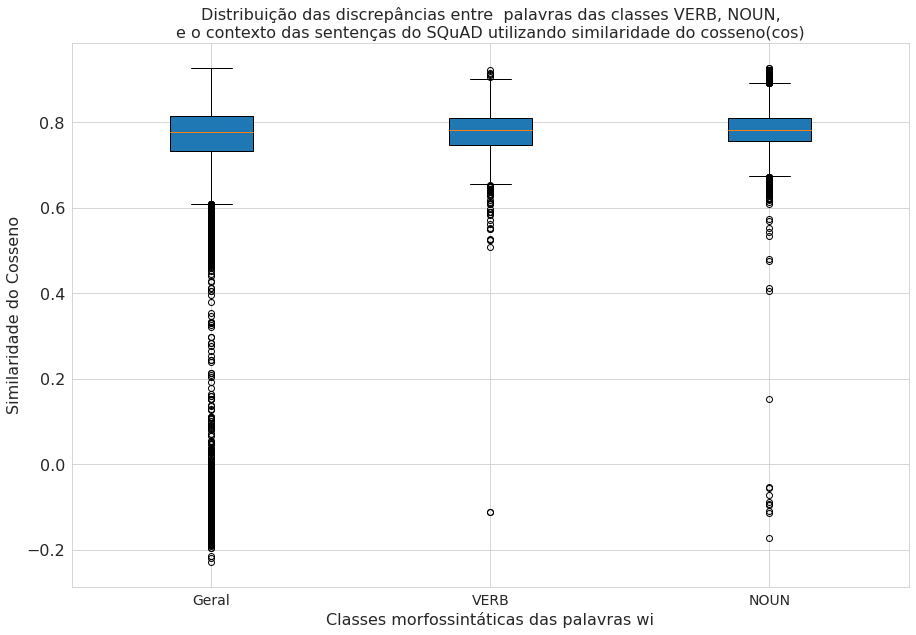

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre  palavras das classes VERB, NOUN,\ne o contexto das sentenças do SQuAD utilizando similaridade do cosseno(cos)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

colunas = [lista_comparacao_contexto[["cos_ctxall_mean"]], lista_comparacao_classesVV[["cos_ctxall_mean"]], lista_comparacao_classesNN[["cos_ctxall_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

##### EUC

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["euc_ctxall_mean"]],
                    lista_comparacao_classesVV[["euc_ctxall_mean"]], 
                    lista_comparacao_classesNN[["euc_ctxall_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral            VERB            NOUN
      euc_ctxall_mean euc_ctxall_mean euc_ctxall_mean
count    31751.000000     2895.000000     6055.000000
mean        28.765830       28.317595       27.356033
std          4.890951        3.447878        3.422731
min         12.264054       14.621447       13.849763
25%         25.717285       26.079433       25.515737
50%         28.161108       28.263968       27.433371
75%         31.066850       30.503311       29.390595
max         46.381302       43.906845       44.011665

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


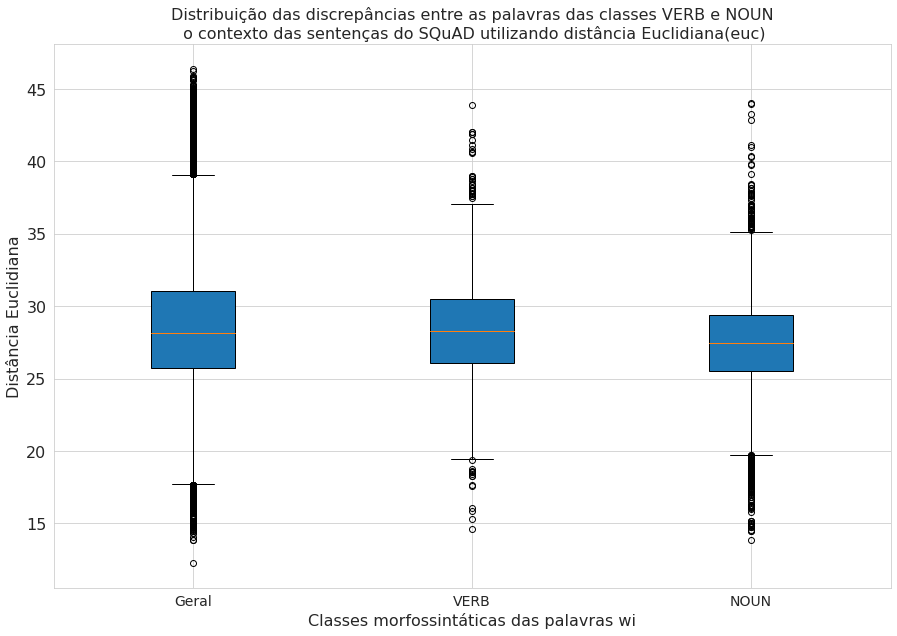

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n o contexto das sentenças do SQuAD utilizando distância Euclidiana(euc)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

colunas = [lista_comparacao_contexto[["euc_ctxall_mean"]], lista_comparacao_classesVV[["euc_ctxall_mean"]], lista_comparacao_classesNN[["euc_ctxall_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3 ], ["Geral", "VERB", "NOUN"])

plt.show()

##### MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["man_ctxall_mean"]],
                    lista_comparacao_classesVV[["man_ctxall_mean"]], 
                    lista_comparacao_classesNN[["man_ctxall_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral            VERB            NOUN
      man_ctxall_mean man_ctxall_mean man_ctxall_mean
count    31751.000000     2895.000000     6055.000000
mean      1421.803734     1426.653681     1365.308676
std        220.695440      176.132658      174.006675
min        611.551760      737.681640      703.460800
25%       1279.531100     1310.239350     1270.194950
50%       1406.382800     1425.343000     1369.577900
75%       1548.543300     1539.166800     1469.532350
max       2250.778800     2209.260700     1953.169700

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


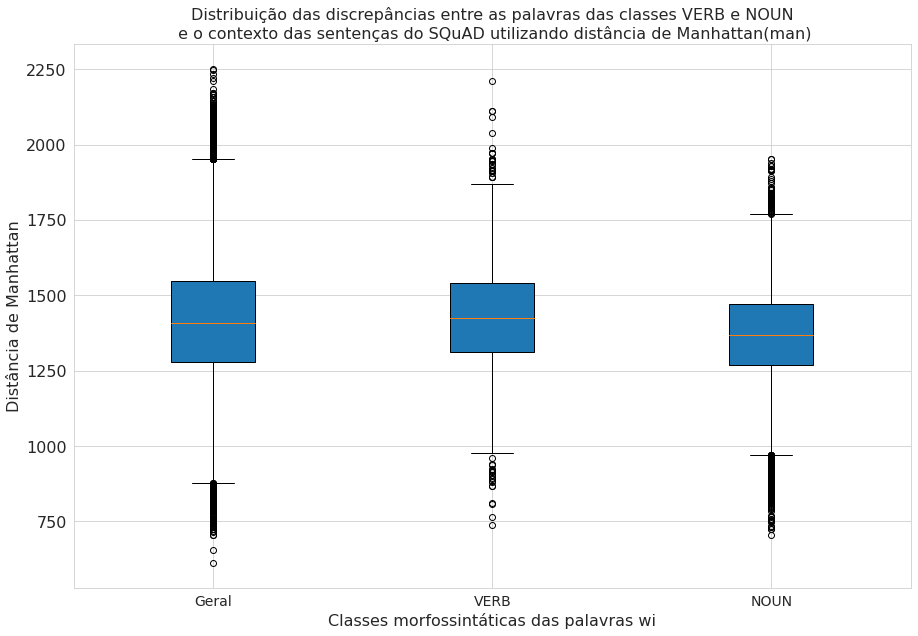

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n e o contexto das sentenças do SQuAD utilizando distância de Manhattan(man)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

colunas = [lista_comparacao_contexto[["man_ctxall_mean"]], lista_comparacao_classesVV[["man_ctxall_mean"]], lista_comparacao_classesNN[["man_ctxall_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

### Contexto com todas as palavras sem stopwords(ctxclean)

#### VERB

In [ ]:
classe_morfosintatica = "VERB"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesVV = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 2895


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxclean_mean","euc_ctxclean_mean","cos_ctxclean_max","euc_ctxclean_max","man_ctxclean_max","man_ctxclean_mean"]].describe(include=["float", "int"]) 

cos_ctxclean_mean  euc_ctxclean_mean  cos_ctxclean_max  \
count        2895.000000        2895.000000       2895.000000   
mean            0.782669          27.894589          0.778673   
std             0.063920           3.925477          0.067630   
min            -0.015720          17.607315         -0.015720   
25%             0.753057          25.173280          0.748706   
50%             0.793273          27.557499          0.791046   
75%             0.825177          30.211957          0.824199   
max             0.915301          42.436909          0.915301   

       euc_ctxclean_max  man_ctxclean_max  man_ctxclean_mean  
count       2895.000000       2895.000000        2895.000000  
mean          28.308961       1429.381434        1406.921636  
std            4.231648        217.741860         200.503550  
min           17.607315        893.575560         893.575560  
25%           25.401385       1281.410900        1270.578350  
50%           27.896212       1406.868300        1390.140000  
75%           30.526541       1544.044400        1528.912400  
max           48.903595       2588.652300        2161.933000

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo VERB

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/2895 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        3  394
      2        4  352
      3        5  352
      4        6  322
      5        7  266
      6        2  250
      7        1  217
      8        8  210
      9        9  146
     10       10  118
     11       11   91
     12       12   50
     13       13   45
     14       14   23
     15       15   16
     16        0   15
     17       16   12
     18       19    5
     19       18    5
     20       20    2


##### COS - MEAN

In [ ]:
medida = "cos_ctxclean_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.07211953401565552
Limite superior             : 0.9333558976650238
Limite inferior             : 0.6448777616024017


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2895 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 96 de 2895 ( 0.03316062176165803 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  96 de 2895 ( 0.03316062176165803 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 -0.0157197955995798 -
         When was the Armenian Mosaic re-discovered?

 2 -0.0157197955995798 -
         When was the Armenian Mosaic re - discovered ?

 3 0.5378506183624268 take
         How many days did it take for the Romanians give into the Soviets requests ?

 4 0.5378506183624268 take
         How many days did it take for the Romanians give into the Soviets requests?

 5 0.5473417043685913 done
         What is being done ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 What did many Benedictines take part in?
       1 0.6433079242706299 take

 2 What did many Benedictines take part in ?
       1 0.6433079242706299 take

 3 As an inhaler , what was epinephrine used to do ?
       1 0.6500186324119568 used
       2 0.6425721049308777 do

 4 Following the Liberal victory in 2015 , standing orders were changed to Say what ?
       1 0.7960010766983032 standing
       2 0.7104443311691284 changed
       3 0.6422924995422363 Say
       4 0.5640324354171753 Following

 5 When had the British East India Company replaced the Dutch East India Company in sales ?
       1 0.6419590711593628 replaced


##### COS - MAX

In [ ]:
medida = "cos_ctxclean_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.07549259066581726
Limite superior             : 0.9374379366636276
Limite inferior             : 0.6354675740003586


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2895 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 116 de 2895 ( 0.04006908462867012 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  116 de 2895 ( 0.04006908462867012 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 -0.0157197955995798 -
         When was the Armenian Mosaic re-discovered?

 2 -0.0157197955995798 -
         When was the Armenian Mosaic re - discovered ?

 3 0.52164226770401 diaphragming
         Why did some music lovers frown upon diaphragming?

 4 0.5318494439125061 liberate
         When did the Ottoman Empire liberate Constantinople from the Balkans?

 5 0.5337939858436584 Stretched
         Stretched rocks that turn into lenses are known by what word ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Did the FBI reassign agents from counter-intelligence to violent crime?
       1 0.6329809427261353 reassign

 2 What is compromised of many levels of codified and uncodified forms of law?
       1 0.6324145793914795 compromised

 3 Which mountain is seperated from the rest of the range by a valley?
       1 0.6323544979095459 seperated

 4 What artistic movement caused New York to overtake Paris as the global art center?
       1 0.7515109181404114 caused
       2 0.631475031375885 overtake

 5 How old was Mabel when she became deaf?
       1 0.6313091516494751 became


##### EUC - MEAN

In [ ]:
medida = "euc_ctxclean_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 5.038677215576172
Limite superior             : 37.769972801208496
Limite inferior             : 17.61526393890381


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 55 de 2895 ( 0.018998272884283247 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 2 de 2895 ( 0.000690846286701209 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  57 de 2895 ( 0.019689119170984457 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 42.43690872192383 take
         How many days did it take for the Romanians give into the Soviets requests ?

 2 42.43690872192383 take
         How many days did it take for the Romanians give into the Soviets requests?

 3 41.933349609375 take
         How many years of study would it take to get a degree from a polytechnic in Singapore ?

 4 41.5715446472168 take
         How many years did it take for Ibn Sina's Book of Healing to be available in Latin?

 5 41.5715446472168 take
         How many years did it take for Ibn Sina 's Book of Healing to be available in Latin ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxclean) < limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 17.607315063476562 mean
         What does 10i mean?

 2 17.607315063476562 mean
         What does 10i mean ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 How many days did it take for the Romanians give into the Soviets requests ?
       1 42.43690872192383 take
       2 30.278125762939453 give

 2 How many days did it take for the Romanians give into the Soviets requests?
       1 42.43690872192383 take
       2 30.278125762939453 give

 3 How many years of study would it take to get a degree from a polytechnic in Singapore ?
       1 41.933349609375 take
       2 26.85276222229004 get

 4 How many years did it take for Ibn Sina's Book of Healing to be available in Latin?
       1 41.5715446472168 take

 5 How many years did it take for Ibn Sina 's Book of Healing to be available in Latin ?
       1 41.5715446472168 take


##### EUC - MAX

In [ ]:
medida = "euc_ctxclean_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 5.125155448913574
Limite superior             : 38.21427392959595
Limite inferior             : 17.71365213394165


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 92 de 2895 ( 0.03177892918825561 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 2 de 2895 ( 0.000690846286701209 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  94 de 2895 ( 0.03246977547495682 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 48.903594970703125 diaphragming
         Why did some music lovers frown upon diaphragming?

 2 46.52545166015625 Occupy
         On what date did the Occupy Wall Street protests begin ?

 3 46.290672302246094 affixed
         What generation saw iPod batterys being affixed with glue?

 4 46.281864166259766 affixed
         What generation of iPod batterys being affixed with glue ?

 5 46.24697113037109 Occupy
         On what date did the Occupy Wall Street protests commence?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxclean) < limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 17.607315063476562 mean
         What does 10i mean?

 2 17.607315063476562 mean
         What does 10i mean ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Why did some music lovers frown upon diaphragming?
       1 48.903594970703125 diaphragming
       2 29.5767765045166 frown

 2 On what date did the Occupy Wall Street protests begin ?
       1 46.52545166015625 Occupy
       2 31.27692413330078 begin

 3 What generation saw iPod batterys being affixed with glue?
       1 46.290672302246094 affixed
       2 25.2003116607666 saw

 4 What generation of iPod batterys being affixed with glue ?
       1 46.281864166259766 affixed

 5 On what date did the Occupy Wall Street protests commence?
       1 46.24697113037109 Occupy
       2 31.71619415283203 commence


##### MAN - MEAN

In [ ]:
medida = "man_ctxclean_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 258.33404999999993
Limite superior             : 1916.4134749999998
Limite inferior             : 883.0772750000001


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 48 de 2895 ( 0.016580310880829015 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 2895 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  48 de 2895 ( 0.016580310880829015 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 2161.933 take
         How many days did it take for the Romanians give into the Soviets requests ?

 2 2161.933 take
         How many days did it take for the Romanians give into the Soviets requests?

 3 2122.1538 take
         How many years of study would it take to get a degree from a polytechnic in Singapore ?

 4 2120.5952 take
         How many years did it take for Ibn Sina's Book of Healing to be available in Latin?

 5 2120.5952 take
         How many years did it take for Ibn Sina 's Book of Healing to be available in Latin ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxclean) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 How many days did it take for the Romanians give into the Soviets requests ?
       1 2161.933 take
       2 1522.6499 give

 2 How many days did it take for the Romanians give into the Soviets requests?
       1 2161.933 take
       2 1522.6499 give

 3 How many years of study would it take to get a degree from a polytechnic in Singapore ?
       1 2122.1538 take
       2 1339.585 get

 4 How many years did it take for Ibn Sina's Book of Healing to be available in Latin?
       1 2120.5952 take

 5 How many years did it take for Ibn Sina 's Book of Healing to be available in Latin ?
       1 2120.5952 take


##### MAN - MAX

In [ ]:
medida = "man_ctxclean_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 262.63350000000014
Limite superior             : 1937.99465
Limite inferior             : 887.4606499999996


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 87 de 2895 ( 0.03005181347150259 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 2895 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  87 de 2895 ( 0.03005181347150259 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 2588.6523 diaphragming
         Why did some music lovers frown upon diaphragming?

 2 2481.0112 strenthened
         What war strenthened the monarchs position?

 3 2474.19 affixed
         What generation of iPod batterys being affixed with glue ?

 4 2467.872 affixed
         What generation saw iPod batterys being affixed with glue?

 5 2465.8992 Occupy
         On what date did the Occupy Wall Street protests begin ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxclean) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Why did some music lovers frown upon diaphragming?
       1 2588.6523 diaphragming
       2 1485.5702 frown

 2 What war strenthened the monarchs position?
       1 2481.0112 strenthened

 3 What generation of iPod batterys being affixed with glue ?
       1 2474.19 affixed

 4 What generation saw iPod batterys being affixed with glue?
       1 2467.872 affixed
       2 1280.344 saw

 5 On what date did the Occupy Wall Street protests begin ?
       1 2465.8992 Occupy
       2 1590.7933 begin


#### NOUN

In [ ]:
classe_morfosintatica = "NOUN"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesNN = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 6055


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxclean_mean","euc_ctxclean_mean","cos_ctxclean_max","euc_ctxclean_max","man_ctxclean_max","man_ctxclean_mean"]].describe(include=["float", "int"]) 

cos_ctxclean_mean  euc_ctxclean_mean  cos_ctxclean_max  \
count        6055.000000        6055.000000       6055.000000   
mean            0.809331          25.643075          0.799487   
std             0.059448           3.447960          0.066356   
min            -0.130207          15.381392         -0.130207   
25%             0.788473          23.321843          0.777892   
50%             0.817991          25.324009          0.811614   
75%             0.843024          27.484296          0.839326   
max             0.924491          42.218525          0.924491   

       euc_ctxclean_max  man_ctxclean_max  man_ctxclean_mean  
count       6055.000000       6055.000000        6055.000000  
mean          26.635424       1334.623920        1281.878724  
std            4.168690        216.260633         174.913831  
min           15.944219        799.278300         773.505740  
25%           23.904562       1193.946950        1163.394800  
50%           25.940466       1297.708900        1265.853500  
75%           28.434616       1423.970300        1376.837300  
max           51.208912       2747.411100        1997.821000

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo NOUN

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/6055 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        3  703
      2        1  637
      3        4  587
      4        2  563
      5        6  559
      6        5  530
      7        7  508
      8        8  457
      9        9  347
     10       10  291
     11       11  203
     12       12  171
     13       13  124
     14       14  104
     15       15   78
     16       16   50
     17        0   34
     18       17   29
     19       18   19
     20       19   19


##### COS - MEAN

In [ ]:
medida = "cos_ctxclean_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.05455109477043152
Limite superior             : 0.9248511344194412
Limite inferior             : 0.7066467553377151


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 6055 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 248 de 6055 ( 0.040957886044591246 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  248 de 6055 ( 0.040957886044591246 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 -0.1302070617675781 -
         Who were the two National Assembly vice-presidents in Egypt?

 2 -0.1117548123002052 leg
         Who probably located the island on their final leg of their circumnavigation trip?

 3 -0.1064011380076408 leg
         Who probably visited the island on their final leg of their circumnavigation trip ?

 4 -0.040448173880577 -
         Did the FBI reassign agents from counter-intelligence to violent crime?

 5 -0.0286128539592027 -
         Which genres were least influenced by post-punk?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 When was the Armenian Mosaic re-discovered?
       1 0.7065449357032776 re

 2 When was the Armenian Mosaic re - discovered ?
       1 0.7065449357032776 re

 3 The 2008 study related to Napoleon's death found that hair collected from Napoleon's hair as well as that of his family and contemporaries, had arsenic levels approximately how many times higher than current averages?
       1 0.7792431712150574 arsenic
       2 0.7685155272483826 contemporaries
       3 0.7671959400177002 study
       4 0.7588472366333008 levels
       5 0.7570687532424927 averages
       6 0.7469438910484314 hair
       7 0.7388553023338318 times
       8 0.7127537727355957 family
       9 0.7062054872512817 hair
       10 0.7047054767608643 death

 4 The 2008 study related to Napoleon 's death found that hair collected from Napoleon 's hair as well as that of his family and contemporaries , had arsenic levels approximately how many times higher than current averages ?
       1 0.7792431712150574 arsenic


##### COS - MAX

In [ ]:
medida = "cos_ctxclean_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.0614340603351593
Limite superior             : 0.9314774721860886
Limite inferior             : 0.6857412308454514


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 6055 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 341 de 6055 ( 0.05631709331131297 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  341 de 6055 ( 0.05631709331131297 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 -0.1302070617675781 -
         Who were the two National Assembly vice-presidents in Egypt?

 2 -0.1117548123002052 leg
         Who probably located the island on their final leg of their circumnavigation trip?

 3 -0.1064011380076408 leg
         Who probably visited the island on their final leg of their circumnavigation trip ?

 4 -0.040448173880577 -
         Did the FBI reassign agents from counter-intelligence to violent crime?

 5 -0.0286128539592027 -
         Which genres were least influenced by post-punk?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Other than malnutrition and a spread of disease, what is an example of a health problem that arose due to environmental depletion?
       1 0.8462247848510742 problem
       2 0.8197615742683411 health
       3 0.7919859290122986 disease
       4 0.7843124866485596 spread
       5 0.736933171749115 malnutrition
       6 0.7092825770378113 example
       7 0.6857119798660278 depletion

 2 In 2012, what was Switzerland's world ranking for life expectancy in 2012?
       1 0.7794208526611328 world
       2 0.7688326835632324 life
       3 0.6856343746185303 expectancy

 3 The amount of material used as a crop protection measure decreased from 1kg/ha in what year to its current 1%?
       1 0.7974724769592285 measure
       2 0.7852633595466614 protection
       3 0.7800276279449463 material
       4 0.7739626169204712 year
       5 0.7699874639511108 crop
       6 0.7689832448959351 amount
       7 0.685491681098938 %
       8 0.6645044684410095 1kg

 4 Which road was the part of the 

##### EUC - MEAN

In [ ]:
medida = "euc_ctxclean_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.162452697753906
Limite superior             : 33.7279748916626
Limite inferior             : 17.078164100646973


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 155


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 7 de 6055 ( 0.0011560693641618498 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  162 de 6055 ( 0.026754748142031378 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 42.21852493286133 -
         Who were the two National Assembly vice-presidents in Egypt?

 2 40.08232498168945 leg
         Who probably located the island on their final leg of their circumnavigation trip?

 3 40.0674057006836 leg
         Who probably visited the island on their final leg of their circumnavigation trip ?

 4 40.02447891235352 -
         Did the FBI reassign agents from counter-intelligence to violent crime?

 5 39.8609733581543 -
         Which genres were least influenced by post-punk?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxclean) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 15.381392478942873 DCSnet
         What do DCSnet in the US and SORM in Russia do?

 2 15.381392478942873 DCSnet
         What do DCSnet in the US and SORM in Russia do ?

 3 15.464577674865724 microprocessor
         What was the name of the first single-chip microprocessor?

 4 15.944218635559082 objects
         What about metal objects ?

 5 16.99675178527832 apellidos
         In what year was the catalogo alfabetico de apellidos published?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Who were the two National Assembly vice-presidents in Egypt?
       1 42.21852493286133 -
       2 32.181907653808594 vice
       3 29.17637062072754 presidents

 2 Who probably located the island on their final leg of their circumnavigation trip?
       1 40.08232498168945 leg
       2 29.29290580749512 trip
       3 27.49799919128418 island
       4 21.63909149169922 circumnavigation

 3 Who probably visited the island on their final leg of their circumnavigation trip ?
       1 40.0674057006836 leg
       2 29.51064682006836 trip
       3 27.63851356506348 island
       4 21.45721435546875 circumnavigation

 4 Did the FBI reassign agents from counter-intelligence to violent crime?
       1 40.02447891235352 -
       2 25.980438232421875 agents
       3 24.232786178588867 intelligence
       4 24.029741287231445 crime
       5 23.58013343811035 counter

 5 Which genres were least influenced by post-punk?
       1 39.8609733581543 -
       2 25.5297966003418 genres
       3 23.935

##### EUC - MAX

In [ ]:
medida = "euc_ctxclean_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.530054092407227
Limite superior             : 35.22969722747803
Limite inferior             : 17.10948085784912


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 277


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 2 de 6055 ( 0.00033030553261767135 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  279 de 6055 ( 0.046077621800165156 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 51.20891189575195 circumnavigation
         Who probably visited the island on their final leg of their circumnavigation trip ?

 2 51.132572174072266 circumnavigation
         Who probably located the island on their final leg of their circumnavigation trip?

 3 48.1881217956543 Inhabitants
         Inhabitants of Judah are known as what ?

 4 48.1881217956543 Inhabitants
         Inhabitants of Judah are known as what?

 5 48.0146713256836 esablishment
         The treaty of Paris return how many esablishment captured by the British?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxclean) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 15.944218635559082 objects
         What about metal objects ?

 2 17.032094955444336 leaders
         What did the orthodox leaders say ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Who probably visited the island on their final leg of their circumnavigation trip ?
       1 51.20891189575195 circumnavigation
       2 40.0674057006836 leg
       3 29.51064682006836 trip
       4 27.63851356506348 island

 2 Who probably located the island on their final leg of their circumnavigation trip?
       1 51.132572174072266 circumnavigation
       2 40.08232498168945 leg
       3 29.29290580749512 trip
       4 27.49799919128418 island

 3 Inhabitants of Judah are known as what ?
       1 48.1881217956543 Inhabitants

 4 Inhabitants of Judah are known as what?
       1 48.1881217956543 Inhabitants

 5 The treaty of Paris return how many esablishment captured by the British?
       1 48.0146713256836 esablishment
       2 25.837739944458008 treaty


##### MAN - MEAN

In [ ]:
medida = "man_ctxclean_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 213.44249999999988
Limite superior             : 1697.0010499999999
Limite inferior             : 843.2310500000002


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 151


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 8 de 6055 ( 0.0013212221304706854 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  159 de 6055 ( 0.026259289843104872 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1997.821 others
         What was a major reason Victoria 's Secret was not as popular as some others ?

 2 1972.5743 part
         The College 's restricted equity holdings would be only a part of which portion of the portfolio ?

 3 1960.927 others
         What was a major reason Victoria's monarchy was not as popular as some others?

 4 1937.0757 name
         What 's the name of the cave system

 5 1937.0757 name
         What's the name of the cave system


###### Top 5 documentos com as maiores similaridades (man(wi,ctxclean) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 773.50574 DCSnet
         What do DCSnet in the US and SORM in Russia do?

 2 773.50574 DCSnet
         What do DCSnet in the US and SORM in Russia do ?

 3 776.37067 microprocessor
         What was the name of the first single-chip microprocessor?

 4 787.6576 malnutrition
         Other than malnutrition and a spread of disease , what is an example of a health problem that is due to environmental depletion ?

 5 799.2783 objects
         What about metal objects ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 What was a major reason Victoria 's Secret was not as popular as some others ?
       1 1997.821 others
       2 1592.4215 reason

 2 The College 's restricted equity holdings would be only a part of which portion of the portfolio ?
       1 1972.5743 part
       2 1470.5432 portion
       3 1173.6409 equity
       4 1090.6177 holdings
       5 1068.4316 portfolio

 3 What was a major reason Victoria's monarchy was not as popular as some others?
       1 1960.927 others
       2 1609.7773 reason
       3 1231.3065 monarchy

 4 What 's the name of the cave system
       1 1937.0757 name
       2 1059.0762 cave
       3 1059.0762 system

 5 What's the name of the cave system
       1 1937.0757 name
       2 1059.0762 cave
       3 1059.0762 system


##### MAN - MAX

In [ ]:
medida = "man_ctxclean_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 230.02334999999994
Limite superior             : 1769.0053249999999
Limite inferior             : 848.9119250000001


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 277


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 1 de 6055 ( 0.00016515276630883568 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  278 de 6055 ( 0.04591246903385632 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 2747.4111 circumnavigation
         Who probably visited the island on their final leg of their circumnavigation trip ?

 2 2743.1523 circumnavigation
         Who probably located the island on their final leg of their circumnavigation trip?

 3 2542.6743 esablishment
         The treaty of Paris return how many esablishment captured by the British?

 4 2535.5483 neoclassicism
         What style replace neoclassicism in 1806?

 5 2512.547 Inhabitants
         Inhabitants of Judah are known as what?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxclean) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 799.2783 objects
         What about metal objects ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Who probably visited the island on their final leg of their circumnavigation trip ?
       1 2747.4111 circumnavigation
       2 1484.523 trip
       3 1356.1542 island
       4 1100.206 leg

 2 Who probably located the island on their final leg of their circumnavigation trip?
       1 2743.1523 circumnavigation
       2 1467.7319 trip
       3 1350.1772 island
       4 1089.6365 leg

 3 The treaty of Paris return how many esablishment captured by the British?
       1 2542.6743 esablishment
       2 1297.2522 treaty

 4 What style replace neoclassicism in 1806?
       1 2535.5483 neoclassicism
       2 1165.3173 style

 5 Inhabitants of Judah are known as what?
       1 2512.547 Inhabitants


#### Comparando discrepância entre o contexto de todas as palavras e palavras de todas as classes, VERB e NOUN.

##### COS, EUC, MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxclean_mean","euc_ctxclean_mean","cos_ctxclean_max","euc_ctxclean_max","man_ctxclean_max","man_ctxclean_mean"]],
                    lista_comparacao_classesVV[["cos_ctxclean_mean","euc_ctxclean_mean","cos_ctxclean_max","euc_ctxclean_max","man_ctxclean_max","man_ctxclean_mean"]], 
                    lista_comparacao_classesNN[["cos_ctxclean_mean","euc_ctxclean_mean","cos_ctxclean_max","euc_ctxclean_max","man_ctxclean_max","man_ctxclean_mean"]],
                    ], 
                    axis="columns", 
                   keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                                                      \
      cos_ctxclean_mean euc_ctxclean_mean cos_ctxclean_max euc_ctxclean_max   
count      31751.000000      31751.000000     31751.000000     31751.000000   
mean           0.726256         29.883117         0.719474        30.575758   
std            0.159372          5.944113         0.158605         5.921642   
min           -0.263263          0.000000        -0.263263         0.000000   
25%            0.699918         25.652534         0.689778        26.349722   
50%            0.763046         28.927210         0.755420        29.539156   
75%            0.810694         32.835016         0.804340        33.536789   
max            1.000000         50.180656         1.000000        55.460445   

                                                      VERB                    \
      man_ctxclean_max man_ctxclean_mean cos_ctxclean_mean euc_ctxclean_mean   
count     31751.000000      31751.000000       2895.000000       2895.000000   
mean       1514.534134       1477.470606          0.782669         27.894589   
std         271.455534        268.169984          0.063920          3.925477   
min           0.000000          0.000000         -0.015720         17.607315   
25%        1315.904000       1281.836200          0.753057         25.173280   
50%        1477.716800       1448.061300          0.793273         27.557499   
75%        1672.745400       1637.505750          0.825177         30.211957   
max        3028.649200       2405.935800          0.915301         42.436909   

                                                                            \
      cos_ctxclean_max euc_ctxclean_max man_ctxclean_max man_ctxclean_mean   
count      2895.000000      2895.000000      2895.000000       2895.000000   
mean          0.778673        28.308961      1429.381434       1406.921636   
std           0.067630         4.231648       217.741860        200.503550   
min          -0.015720        17.607315       893.575560        893.575560   
25%           0.748706        25.401385      1281.410900       1270.578350   
50%           0.791046        27.896212      1406.868300       1390.140000   
75%           0.824199        30.526541      1544.044400       1528.912400   
max           0.915301        48.903595      2588.652300       2161.933000   

                   NOUN                                                      \
      cos_ctxclean_mean euc_ctxclean_mean cos_ctxclean_max euc_ctxclean_max   
count       6055.000000       6055.000000      6055.000000      6055.000000   
mean           0.809331         25.643075         0.799487        26.635424   
std            0.059448          3.447960         0.066356         4.168690   
min           -0.130207         15.381392        -0.130207        15.944219   
25%            0.788473         23.321843         0.777892        23.904562   
50%            0.817991         25.324009         0.811614        25.940466   
75%            0.843024         27.484296         0.839326        28.434616   
max            0.924491         42.218525         0.924491        51.208912   

                                          
      man_ctxclean_max man_ctxclean_mean  
count      6055.000000       6055.000000  
mean       1334.623920       1281.878724  
std         216.260633        174.913831  
min         799.278300        773.505740  
25%        1193.946950       1163.394800  
50%        1297.708900       1265.853500  
75%        1423.970300       1376.837300  
max        2747.411100       1997.821000

##### COS

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxclean_mean"]],                    
                    lista_comparacao_classesVV[["cos_ctxclean_mean"]], 
                    lista_comparacao_classesNN[["cos_ctxclean_mean"]],
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral              VERB              NOUN
      cos_ctxclean_mean cos_ctxclean_mean cos_ctxclean_mean
count      31751.000000       2895.000000       6055.000000
mean           0.726256          0.782669          0.809331
std            0.159372          0.063920          0.059448
min           -0.263263         -0.015720         -0.130207
25%            0.699918          0.753057          0.788473
50%            0.763046          0.793273          0.817991
75%            0.810694          0.825177          0.843024
max            1.000000          0.915301          0.924491

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


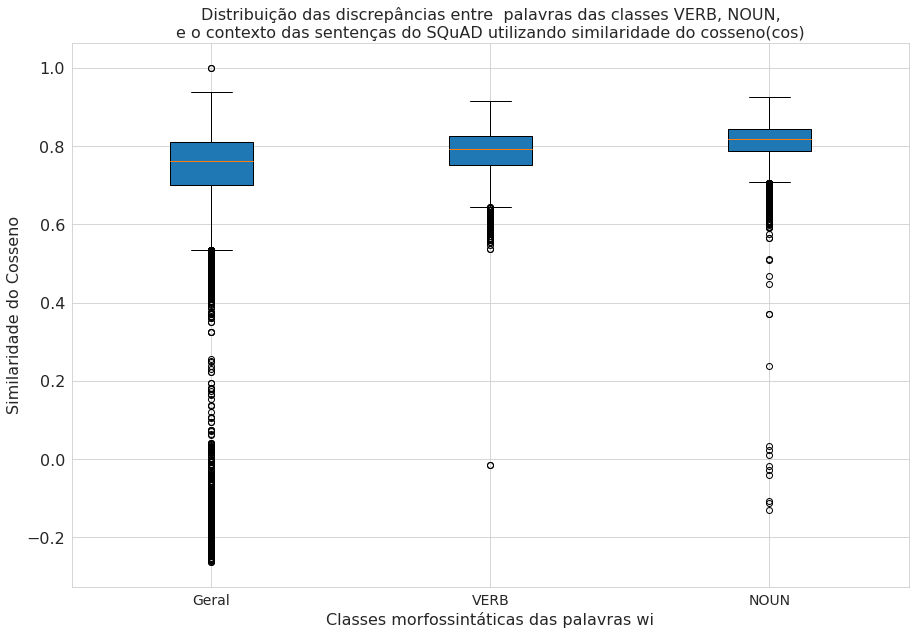

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre  palavras das classes VERB, NOUN,\ne o contexto das sentenças do SQuAD utilizando similaridade do cosseno(cos)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

colunas = [lista_comparacao_contexto[["cos_ctxclean_mean"]], lista_comparacao_classesVV[["cos_ctxclean_mean"]], lista_comparacao_classesNN[["cos_ctxclean_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

##### EUC

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["euc_ctxclean_mean"]],
                    lista_comparacao_classesVV[["euc_ctxclean_mean"]], 
                    lista_comparacao_classesNN[["euc_ctxclean_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral              VERB              NOUN
      euc_ctxclean_mean euc_ctxclean_mean euc_ctxclean_mean
count      31751.000000       2895.000000       6055.000000
mean          29.883117         27.894589         25.643075
std            5.944113          3.925477          3.447960
min            0.000000         17.607315         15.381392
25%           25.652534         25.173280         23.321843
50%           28.927210         27.557499         25.324009
75%           32.835016         30.211957         27.484296
max           50.180656         42.436909         42.218525

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


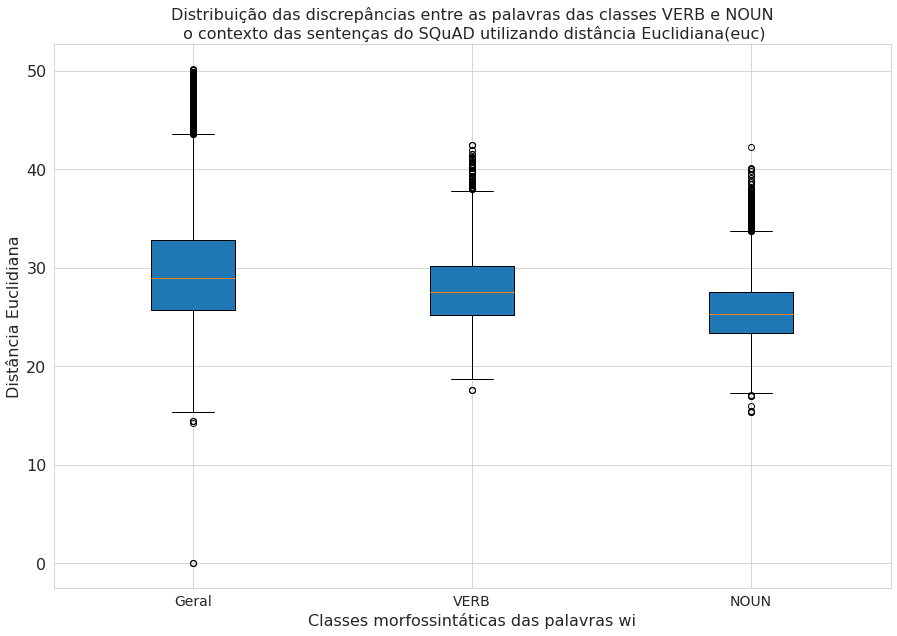

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n o contexto das sentenças do SQuAD utilizando distância Euclidiana(euc)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

colunas = [lista_comparacao_contexto[["euc_ctxclean_mean"]], lista_comparacao_classesVV[["euc_ctxclean_mean"]], lista_comparacao_classesNN[["euc_ctxclean_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3 ], ["Geral", "VERB", "NOUN"])

plt.show()

##### MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["man_ctxclean_mean"]],
                    lista_comparacao_classesVV[["man_ctxclean_mean"]], 
                    lista_comparacao_classesNN[["man_ctxclean_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral              VERB              NOUN
      man_ctxclean_mean man_ctxclean_mean man_ctxclean_mean
count      31751.000000       2895.000000       6055.000000
mean        1477.470606       1406.921636       1281.878724
std          268.169984        200.503550        174.913831
min            0.000000        893.575560        773.505740
25%         1281.836200       1270.578350       1163.394800
50%         1448.061300       1390.140000       1265.853500
75%         1637.505750       1528.912400       1376.837300
max         2405.935800       2161.933000       1997.821000

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


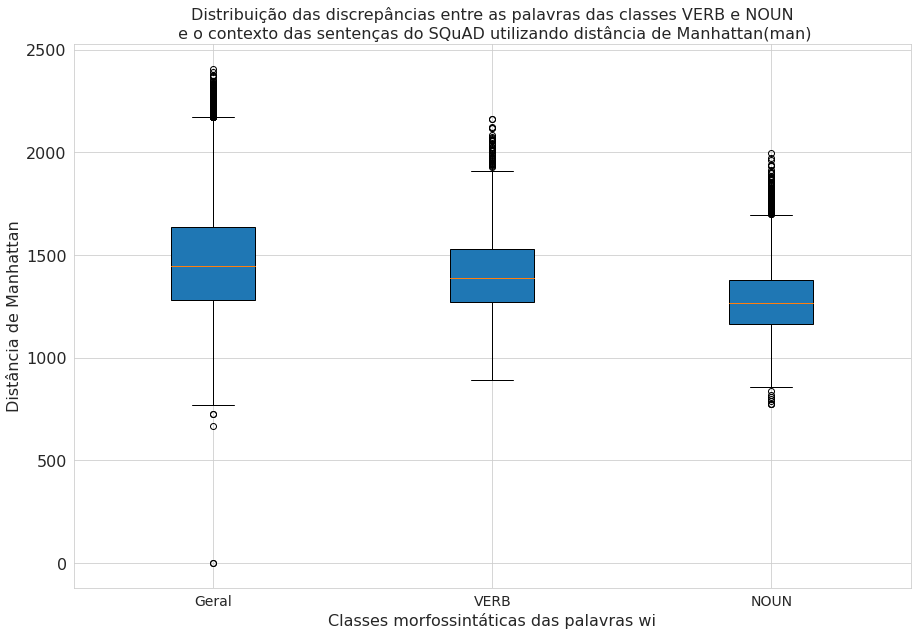

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n e o contexto das sentenças do SQuAD utilizando distância de Manhattan(man)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

colunas = [lista_comparacao_contexto[["man_ctxclean_mean"]], lista_comparacao_classesVV[["man_ctxclean_mean"]], lista_comparacao_classesNN[["man_ctxclean_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

### Contexto com palavras da classe VERB e AUX(ctxverb)

#### VERB

In [ ]:
classe_morfosintatica = "VERB"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesVV = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 2895


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxverb_mean", "euc_ctxverb_mean",
                          "man_ctxverb_mean", "cos_ctxverb_max",
                          "euc_ctxverb_max",  "man_ctxverb_max"]].describe(include=["float", "int"]) 

cos_ctxverb_mean  euc_ctxverb_mean  man_ctxverb_mean  cos_ctxverb_max  \
count       2895.000000       2895.000000       2895.000000      2895.000000   
mean           0.890154         18.834047        950.481713         0.885388   
std            0.062854          7.938960        399.626143         0.070856   
min            0.171387          0.000000          0.000000         0.171387   
25%            0.854246         17.811693        898.620300         0.850805   
50%            0.893590         20.385473       1030.426147         0.892995   
75%            0.918297         23.397768       1178.183594         0.917636   
max            1.000000         37.731236       1877.300049         1.000000   

       euc_ctxverb_max  man_ctxverb_max  
count      2895.000000      2895.000000  
mean         19.336627       976.918496  
std           8.386909       424.913785  
min           0.000000         0.000000  
25%          17.894851       906.392151  
50%          20.557259      1038.257812  
75%          23.847574      1203.552185  
max          48.746475      2582.264648

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo VERB

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/2895 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        3  394
      2        4  352
      3        5  352
      4        6  322
      5        7  266
      6        2  250
      7        1  217
      8        8  210
      9        9  146
     10       10  118
     11       11   91
     12       12   50
     13       13   45
     14       14   23
     15       15   16
     16        0   15
     17       16   12
     18       19    5
     19       18    5
     20       20    2


##### COS - MEAN

In [ ]:
medida = "cos_ctxverb_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.0640510618686676
Limite superior             : 1.0143736451864243
Limite inferior             : 0.7581693977117538


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2895 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 48 de 2895 ( 0.016580310880829015 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  48 de 2895 ( 0.016580310880829015 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.1713870763778686 -
         When was the Armenian Mosaic re - discovered ?

 2 0.1713870763778686 -
         When was the Armenian Mosaic re-discovered?

 3 0.5835802555084229 minted
         When were oldly minted coins presented to ensure they met standards?

 4 0.5842357277870178 minted
         When were oldly minted coins presented to prove they met standards ?

 5 0.6304845213890076 Following
         Following the Liberal victory in 2015 , standing orders were changed to Say what ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 In which number report to the Council did the Prosecutor find that crimes had been committed but evidence for prosecution was sufficient ?
       1 0.7696763277053833 committed
       2 0.7577286958694458 find

 2 Who was supposed to inspect building to see if they met national standards?
       1 0.8290717005729675 see
       2 0.8113358020782471 supposed
       3 0.8063051104545593 inspect
       4 0.7576776742935181 met

 3 When did the U.S. Supreme Court rule clauses forbidding people from holding public office based on their religion was unenforceable?
       1 0.8082506656646729 forbidding
       2 0.773512065410614 based
       3 0.7571547031402588 holding

 4 What was the name of the blockade and bombing of Japan planed to make them surrender?
       1 0.8305106163024902 make
       2 0.8252686262130737 surrender
       3 0.7568442225456238 planed

 5 Who did Virgil recite Books 2, 4, and 6 of the Aeneid to?
       1 0.7563128471374512 recite


##### COS - MAX

In [ ]:
medida = "cos_ctxverb_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.06683117151260376
Limite superior             : 1.0178824365139008
Limite inferior             : 0.7505577504634857


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2895 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 85 de 2895 ( 0.02936096718480138 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  85 de 2895 ( 0.02936096718480138 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.1713870763778686 -
         When was the Armenian Mosaic re-discovered?

 2 0.1713870763778686 -
         When was the Armenian Mosaic re - discovered ?

 3 0.5283166766166687 diaphragming
         Why did some music lovers frown upon diaphragming?

 4 0.5285316109657288 Stretched
         Stretched rocks that turn into lenses are known by what word ?

 5 0.5423076748847961 Occupy
         On what date did the Occupy Wall Street protests begin ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Who was going to inspect building to see if they met national standards ?
       1 0.8510661721229553 going
       2 0.8243057727813721 see
       3 0.8084890246391296 inspect
       4 0.7503665089607239 met

 2 In the Soviet section to the north , what did they have to expel from their land ?
       1 0.901742458343506 have
       2 0.7497596740722656 expel

 3 When are the oldest beads thought to have been made?
       1 0.7933696508407593 made
       2 0.7492215037345886 thought

 4 Who did Virgil recite Books 2, 4, and 6 of the Aeneid to?
       1 0.7470121383666992 recite

 5 What role did Eisenhower believe he could not fulfill if he was believed to want to become involved in politics?
       1 0.8210538029670715 believe
       2 0.7977876663208008 want
       3 0.7951280474662781 become
       4 0.7770654559135437 believed
       5 0.7466076016426086 fulfill


##### EUC - MEAN

In [ ]:
medida = "euc_ctxverb_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 5.5860748291015625
Limite superior             : 31.776880264282227
Limite inferior             : 9.432580947875977


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 18 de 2895 ( 0.0062176165803108805 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 362 de 2895 ( 0.12504317789291883 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  380 de 2895 ( 0.13126079447322972 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 37.73123550415039 Following
         Following the Liberal victory in 2015 , standing orders were changed to Say what ?

 2 37.38051223754883 force
         How much did Wilber force Bell gave him in order to look at Gray 's paperwork ?

 3 37.112548828125 Following
         Following the Liberal victory in 2015, standing orders were changed to do what?

 4 34.941932678222656 sells
         What business that sells cheap alcohol has sometimes been held to have contributed in the decline of pubs ?

 5 34.66094970703125 sells
         What business that sells cheap alcohol has sometimes been held to have resulted in the decline of pubs?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverb) < limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.0 fought
         What two ministers fought for power uner Anne?

 2 0.0 feeds
         What insect feeds on aphids?

 3 0.0 caused
         What caused bad press during the conference protests in Seattle?

 4 0.0 makes
         What makes Neptune blue?

 5 0.0 formed
         Sony and Michael Jordan formed a joint venture in what year?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Following the Liberal victory in 2015 , standing orders were changed to Say what ?
       1 37.73123550415039 Following
       2 30.914714813232425 Say
       3 30.11771774291992 standing
       4 30.01362991333008 changed

 2 How much did Wilber force Bell gave him in order to look at Gray 's paperwork ?
       1 37.38051223754883 force
       2 27.07909393310547 look
       3 25.091951370239254 gave

 3 Following the Liberal victory in 2015, standing orders were changed to do what?
       1 37.112548828125 Following
       2 29.94605255126953 changed
       3 29.60616683959961 do
       4 29.09088897705078 standing

 4 What business that sells cheap alcohol has sometimes been held to have contributed in the decline of pubs ?
       1 34.941932678222656 sells
       2 31.576539993286133 held
       3 29.025909423828125 contributed

 5 What business that sells cheap alcohol has sometimes been held to have resulted in the decline of pubs?
       1 34.66094970703125 sells
       2 31

##### EUC - MAX

In [ ]:
medida = "euc_ctxverb_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 5.952723503112793
Limite superior             : 32.77665948867798
Limite inferior             : 8.965765476226807


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 60 de 2895 ( 0.02072538860103627 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 353 de 2895 ( 0.12193436960276338 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  413 de 2895 ( 0.14265975820379964 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 48.74647521972656 diaphragming
         Why did some music lovers frown upon diaphragming?

 2 47.09477996826172 Occupy
         On what date did the Occupy Wall Street protests begin ?

 3 46.612548828125 Occupy
         On what date did the Occupy Wall Street protests commence?

 4 46.16121292114258 affixed
         What generation saw iPod batterys being affixed with glue?

 5 45.39093780517578 inflicting
         What was inflicting heavy losses and increasing the air war designed to do?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverb) < limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.0 fought
         What two ministers fought for power uner Anne?

 2 0.0 feeds
         What insect feeds on aphids?

 3 0.0 caused
         What caused bad press during the conference protests in Seattle?

 4 0.0 makes
         What makes Neptune blue?

 5 0.0 formed
         Sony and Michael Jordan formed a joint venture in what year?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Why did some music lovers frown upon diaphragming?
       1 48.74647521972656 diaphragming
       2 25.45660400390625 frown

 2 On what date did the Occupy Wall Street protests begin ?
       1 47.09477996826172 Occupy
       2 23.61983299255371 begin

 3 On what date did the Occupy Wall Street protests commence?
       1 46.612548828125 Occupy
       2 24.015729904174805 commence

 4 What generation saw iPod batterys being affixed with glue?
       1 46.16121292114258 affixed
       2 20.360795974731445 saw

 5 What was inflicting heavy losses and increasing the air war designed to do?
       1 45.39093780517578 inflicting
       2 31.628198623657227 do
       3 31.39105987548828 increasing
       4 29.33530807495117 designed


##### MAN - MEAN

In [ ]:
medida = "man_ctxverb_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 279.56329345703125
Limite superior             : 1597.5285339355469
Limite inferior             : 479.2753601074219


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 15 de 2895 ( 0.0051813471502590676 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 362 de 2895 ( 0.12504317789291883 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  377 de 2895 ( 0.13022452504317789 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1877.300048828125 force
         How much did Wilber force Bell gave him in order to look at Gray 's paperwork ?

 2 1815.37451171875 Following
         Following the Liberal victory in 2015 , standing orders were changed to Say what ?

 3 1793.50634765625 sells
         What business that sells cheap alcohol has sometimes been held to have contributed in the decline of pubs ?

 4 1784.1412353515625 Following
         Following the Liberal victory in 2015, standing orders were changed to do what?

 5 1779.6934814453125 sells
         What business that sells cheap alcohol has sometimes been held to have resulted in the decline of pubs?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxverb) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.0 fought
         What two ministers fought for power uner Anne?

 2 0.0 feeds
         What insect feeds on aphids?

 3 0.0 caused
         What caused bad press during the conference protests in Seattle?

 4 0.0 makes
         What makes Neptune blue?

 5 0.0 formed
         Sony and Michael Jordan formed a joint venture in what year?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 How much did Wilber force Bell gave him in order to look at Gray 's paperwork ?
       1 1877.300048828125 force
       2 1362.013671875 look
       3 1287.8525390625 gave

 2 Following the Liberal victory in 2015 , standing orders were changed to Say what ?
       1 1815.37451171875 Following
       2 1550.18115234375 Say
       3 1530.344482421875 standing
       4 1515.6715087890625 changed

 3 What business that sells cheap alcohol has sometimes been held to have contributed in the decline of pubs ?
       1 1793.50634765625 sells
       2 1606.071533203125 held
       3 1472.370849609375 contributed

 4 Following the Liberal victory in 2015, standing orders were changed to do what?
       1 1784.1412353515625 Following
       2 1511.6114501953125 changed
       3 1491.9361572265625 do
       4 1481.5384521484375 standing

 5 What business that sells cheap alcohol has sometimes been held to have resulted in the decline of pubs?
       1 1779.6934814453125 sells
       2 1609.78

##### MAN - MAX

In [ ]:
medida = "man_ctxverb_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 297.1600341796875
Limite superior             : 1649.292236328125
Limite inferior             : 460.652099609375


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 59 de 2895 ( 0.020379965457685664 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 353 de 2895 ( 0.12193436960276338 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  412 de 2895 ( 0.14231433506044905 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 2582.2646484375 diaphragming
         Why did some music lovers frown upon diaphragming?

 2 2477.828369140625 Occupy
         On what date did the Occupy Wall Street protests begin ?

 3 2461.1181640625 affixed
         What generation saw iPod batterys being affixed with glue?

 4 2454.47705078125 Occupy
         On what date did the Occupy Wall Street protests commence?

 5 2414.341552734375 affixed
         What generation of iPod batterys being affixed with glue ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxverb) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.0 fought
         What two ministers fought for power uner Anne?

 2 0.0 feeds
         What insect feeds on aphids?

 3 0.0 caused
         What caused bad press during the conference protests in Seattle?

 4 0.0 makes
         What makes Neptune blue?

 5 0.0 formed
         Sony and Michael Jordan formed a joint venture in what year?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Why did some music lovers frown upon diaphragming?
       1 2582.2646484375 diaphragming
       2 1285.65380859375 frown

 2 On what date did the Occupy Wall Street protests begin ?
       1 2477.828369140625 Occupy
       2 1198.9193115234375 begin

 3 What generation saw iPod batterys being affixed with glue?
       1 2461.1181640625 affixed
       2 1038.5858154296875 saw

 4 On what date did the Occupy Wall Street protests commence?
       1 2454.47705078125 Occupy
       2 1225.11572265625 commence

 5 What generation of iPod batterys being affixed with glue ?
       1 2414.341552734375 affixed


#### NOUN

In [ ]:
classe_morfosintatica = "NOUN"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesNN = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 6055


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxverb_mean","euc_ctxverb_mean",
                          "man_ctxverb_mean","cos_ctxverb_max",
                          "euc_ctxverb_max","man_ctxverb_max"]].describe(include=["float", "int"]) 

cos_ctxverb_mean  euc_ctxverb_mean  man_ctxverb_mean  cos_ctxverb_max  \
count       5965.000000       5965.000000       5965.000000      5965.000000   
mean           0.636621         36.463494       1833.156491         0.629124   
std            0.076462          4.413359        222.960408         0.078667   
min           -0.194291         21.462152       1063.084106        -0.194291   
25%            0.591115         33.395664       1678.233643         0.582445   
50%            0.639902         36.366837       1830.363037         0.634055   
75%            0.686124         39.485912       1988.390137         0.679129   
max            0.865986         55.239887       2558.004395         0.865986   

       euc_ctxverb_max  man_ctxverb_max  
count      5965.000000      5965.000000  
mean         37.197675      1872.007803  
std           4.679274       237.276066  
min          21.462152      1063.084106  
25%          33.912556      1708.376709  
50%          36.886261      1860.099365  
75%          40.279270      2028.274292  
max          59.706543      3085.813965

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo NOUN

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/6055 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        3  703
      2        1  637
      3        4  587
      4        2  563
      5        6  559
      6        5  530
      7        7  508
      8        8  457
      9        9  347
     10       10  291
     11       11  203
     12       12  171
     13       13  124
     14       14  104
     15       15   78
     16       16   50
     17        0   34
     18       17   29
     19       18   19
     20       19   19


##### COS - MEAN

In [ ]:
medida = "cos_ctxverb_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 6055 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 6055 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 6055 ( 0.0 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### COS - MAX

In [ ]:
medida = "cos_ctxverb_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 6055 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 6055 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 6055 ( 0.0 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### EUC - MEAN

In [ ]:
medida = "euc_ctxverb_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 0


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 6055 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 6055 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverb) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### EUC - MAX

In [ ]:
medida = "euc_ctxverb_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 0


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 6055 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 6055 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverb) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### MAN - MEAN

In [ ]:
medida = "man_ctxverb_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 0


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 6055 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 6055 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (man(wi,ctxverb) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxvern) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### MAN - MAX

In [ ]:
medida = "man_ctxverb_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 0


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 6055 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 6055 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (man(wi,ctxverb) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxvern) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

#### Comparando discrepância entre o contexto de palavras da classe VERB e palavras de todas classes, VERB e NOUN.

##### COS, EUC, MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxverb_mean","euc_ctxverb_mean",
                                               "man_ctxverb_mean","cos_ctxverb_max",
                                               "euc_ctxverb_max","man_ctxverb_max"]],
                    lista_comparacao_classesVV[["cos_ctxverb_mean","euc_ctxverb_mean",
                                                "man_ctxverb_mean","cos_ctxverb_max",
                                                "euc_ctxverb_max","man_ctxverb_max"]], 
                    lista_comparacao_classesNN[["cos_ctxverb_mean","euc_ctxverb_mean",
                                                "man_ctxverb_mean","cos_ctxverb_max",
                                                "euc_ctxverb_max","man_ctxverb_max"]],
                    ], 
                    axis="columns", 
                   keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                                                    \
      cos_ctxverb_mean euc_ctxverb_mean man_ctxverb_mean cos_ctxverb_max   
count     31418.000000     31418.000000     31418.000000    31418.000000   
mean          0.660316        33.986752      1689.823290        0.654977   
std           0.179029        10.003694       480.548868        0.180607   
min          -0.253069         0.000000         0.000000       -0.253069   
25%           0.577091        30.086973      1514.436951        0.567735   
50%           0.655730        35.517651      1782.960754        0.650811   
75%           0.750296        40.206966      1999.731445        0.746825   
max           1.000000        58.054005      2845.965576        1.000000   

                                                  VERB                   \
      euc_ctxverb_max man_ctxverb_max cos_ctxverb_mean euc_ctxverb_mean   
count    31418.000000    31418.000000      2895.000000      2895.000000   
mean        34.523849     1718.321181         0.890154        18.834047   
std         10.224177      494.233364         0.062854         7.938960   
min          0.000000        0.000000         0.171387         0.000000   
25%         30.555419     1539.087830         0.854246        17.811693   
50%         36.078053     1806.565735         0.893590        20.385473   
75%         40.943206     2033.872955         0.918297        23.397768   
max         63.013847     3258.246338         1.000000        37.731236   

                                                                        \
      man_ctxverb_mean cos_ctxverb_max euc_ctxverb_max man_ctxverb_max   
count      2895.000000     2895.000000     2895.000000     2895.000000   
mean        950.481713        0.885388       19.336627      976.918496   
std         399.626143        0.070856        8.386909      424.913785   
min           0.000000        0.171387        0.000000        0.000000   
25%         898.620300        0.850805       17.894851      906.392151   
50%        1030.426147        0.892995       20.557259     1038.257812   
75%        1178.183594        0.917636       23.847574     1203.552185   
max        1877.300049        1.000000       48.746475     2582.264648   

                  NOUN                                                    \
      cos_ctxverb_mean euc_ctxverb_mean man_ctxverb_mean cos_ctxverb_max   
count      5965.000000      5965.000000      5965.000000     5965.000000   
mean          0.636621        36.463494      1833.156491        0.629124   
std           0.076462         4.413359       222.960408        0.078667   
min          -0.194291        21.462152      1063.084106       -0.194291   
25%           0.591115        33.395664      1678.233643        0.582445   
50%           0.639902        36.366837      1830.363037        0.634055   
75%           0.686124        39.485912      1988.390137        0.679129   
max           0.865986        55.239887      2558.004395        0.865986   

                                       
      euc_ctxverb_max man_ctxverb_max  
count     5965.000000     5965.000000  
mean        37.197675     1872.007803  
std          4.679274      237.276066  
min         21.462152     1063.084106  
25%         33.912556     1708.376709  
50%         36.886261     1860.099365  
75%         40.279270     2028.274292  
max         59.706543     3085.813965

##### COS

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxverb_mean"]],                    
                    lista_comparacao_classesVV[["cos_ctxverb_mean"]], 
                    lista_comparacao_classesNN[["cos_ctxverb_mean"]],
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral             VERB             NOUN
      cos_ctxverb_mean cos_ctxverb_mean cos_ctxverb_mean
count     31418.000000      2895.000000      5965.000000
mean          0.660316         0.890154         0.636621
std           0.179029         0.062854         0.076462
min          -0.253069         0.171387        -0.194291
25%           0.577091         0.854246         0.591115
50%           0.655730         0.893590         0.639902
75%           0.750296         0.918297         0.686124
max           1.000000         1.000000         0.865986

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


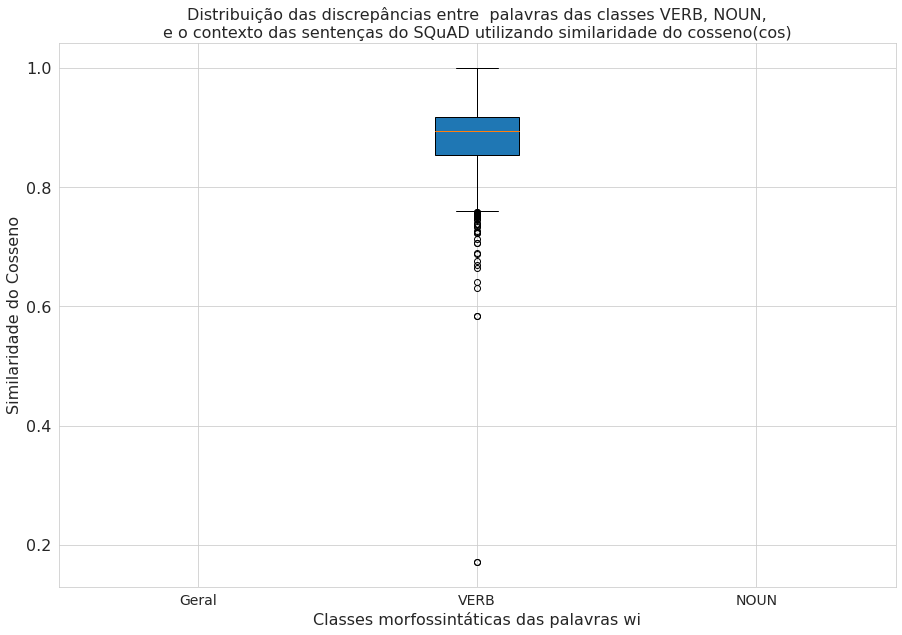

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre  palavras das classes VERB, NOUN,\ne o contexto das sentenças do SQuAD utilizando similaridade do cosseno(cos)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

colunas = [lista_comparacao_contexto[["cos_ctxverb_mean"]], lista_comparacao_classesVV[["cos_ctxverb_mean"]], lista_comparacao_classesNN[["cos_ctxverb_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

##### EUC

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["euc_ctxverb_mean"]],
                    lista_comparacao_classesVV[["euc_ctxverb_mean"]], 
                    lista_comparacao_classesNN[["euc_ctxverb_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral             VERB             NOUN
      euc_ctxverb_mean euc_ctxverb_mean euc_ctxverb_mean
count     31418.000000      2895.000000      5965.000000
mean         33.986752        18.834047        36.463494
std          10.003694         7.938960         4.413359
min           0.000000         0.000000        21.462152
25%          30.086973        17.811693        33.395664
50%          35.517651        20.385473        36.366837
75%          40.206966        23.397768        39.485912
max          58.054005        37.731236        55.239887

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


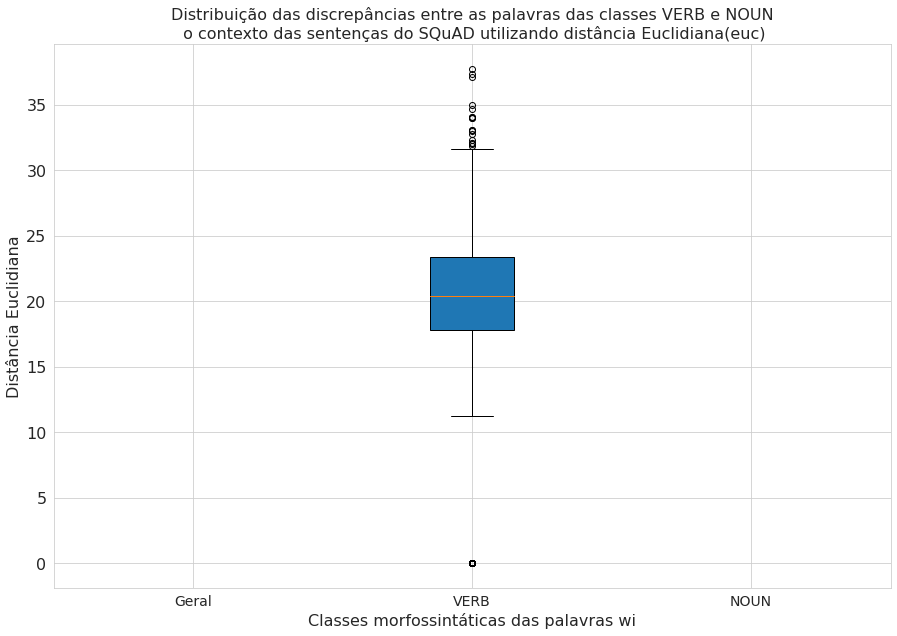

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n o contexto das sentenças do SQuAD utilizando distância Euclidiana(euc)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

colunas = [lista_comparacao_contexto[["euc_ctxverb_mean"]], 
           lista_comparacao_classesVV[["euc_ctxverb_mean"]], 
           lista_comparacao_classesNN[["euc_ctxverb_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3 ], ["Geral", "VERB", "NOUN"])

plt.show()

##### MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["man_ctxverb_mean"]],
                    lista_comparacao_classesVV[["man_ctxverb_mean"]], 
                    lista_comparacao_classesNN[["man_ctxverb_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral             VERB             NOUN
      man_ctxverb_mean man_ctxverb_mean man_ctxverb_mean
count     31418.000000      2895.000000      5965.000000
mean       1689.823290       950.481713      1833.156491
std         480.548868       399.626143       222.960408
min           0.000000         0.000000      1063.084106
25%        1514.436951       898.620300      1678.233643
50%        1782.960754      1030.426147      1830.363037
75%        1999.731445      1178.183594      1988.390137
max        2845.965576      1877.300049      2558.004395

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


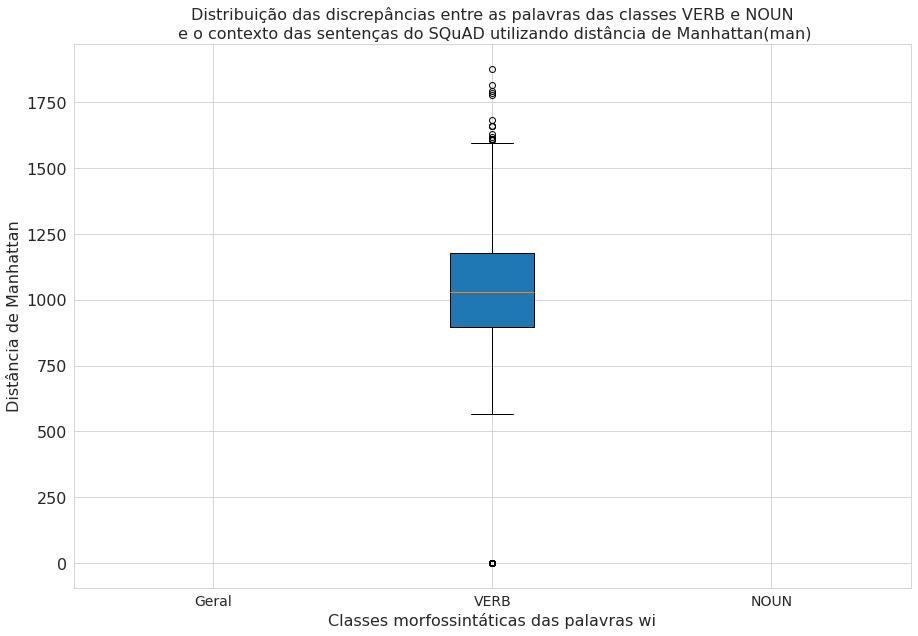

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n e o contexto das sentenças do SQuAD utilizando distância de Manhattan(man)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

colunas = [lista_comparacao_contexto[["man_ctxverb_mean"]], 
           lista_comparacao_classesVV[["man_ctxverb_mean"]], 
           lista_comparacao_classesNN[["man_ctxverb_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

### Contexto com palavras da classe NOUN(ctxnoun)

#### VERB

In [ ]:
classe_morfosintatica = "VERB"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesVV = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 2895


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxnoun_mean","euc_ctxnoun_mean",
                          "man_ctxnoun_mean","cos_ctxnoun_max",
                          "euc_ctxnoun_max","man_ctxnoun_max"]].describe(include=["float", "int"]) 

cos_ctxnoun_mean  euc_ctxnoun_mean  man_ctxnoun_mean  cos_ctxnoun_max  \
count       2648.000000       2648.000000       2648.000000      2648.000000   
mean           0.655834         35.495837       1787.281695         0.652624   
std            0.078364          4.685970        237.028828         0.079985   
min           -0.137425         22.252539       1106.121582        -0.137425   
25%            0.609626         32.133248       1613.358398         0.605480   
50%            0.662787         35.117876       1771.020752         0.659615   
75%            0.711252         38.347888       1936.403931         0.709708   
max            0.852888         54.982056       2556.067383         0.852888   

       euc_ctxnoun_max  man_ctxnoun_max  
count      2648.000000      2648.000000  
mean         35.830864      1805.571179  
std           4.800899       243.020334  
min          22.975374      1144.702393  
25%          32.401003      1632.080048  
50%          35.436516      1788.273376  
75%          38.671419      1953.002808  
max          54.982056      2780.310791

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo VERB

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/2895 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        3  394
      2        4  352
      3        5  352
      4        6  322
      5        7  266
      6        2  250
      7        1  217
      8        8  210
      9        9  146
     10       10  118
     11       11   91
     12       12   50
     13       13   45
     14       14   23
     15       15   16
     16        0   15
     17       16   12
     18       19    5
     19       18    5
     20       20    2


##### COS - MEAN

In [ ]:
medida = "cos_ctxnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2895 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 2895 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 2895 ( 0.0 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior)  entre palavras da classe VERB e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### COS - MAX

In [ ]:
medida = "cos_ctxnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2895 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 2895 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 2895 ( 0.0 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior)  entre palavras da classe VERB e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### EUC - MEAN

In [ ]:
medida = "euc_ctxnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2895 ( 0.0 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 2895 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 2895 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxnoun) < limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### EUC - MAX

In [ ]:
medida = "euc_ctxnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2895 ( 0.0 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 2895 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 2895 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxnoun) < limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### MAN - MEAN

In [ ]:
medida = "man_ctxnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2895 ( 0.0 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 2895 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 2895 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (man(wi,ctxnoun) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### MAN - MAX

In [ ]:
medida = "man_ctxnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2895 ( 0.0 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 2895 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 2895 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (man(wi,ctxnoun) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

#### NOUN

In [ ]:
classe_morfosintatica = "NOUN"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesNN = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 6055


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxnoun_mean","euc_ctxnoun_mean","man_ctxnoun_mean","cos_ctxnoun_max","euc_ctxnoun_max","man_ctxnoun_max"]].describe(include=["float", "int"]) 

cos_ctxnoun_mean  euc_ctxnoun_mean  man_ctxnoun_mean  cos_ctxnoun_max  \
count       6055.000000       6055.000000       6055.000000      6055.000000   
mean           0.880184         19.116736        954.700089         0.868866   
std            0.070415          8.036059        401.621833         0.079932   
min            0.022611          0.000000          0.000000         0.022611   
25%            0.841037         17.822170        890.585510         0.829718   
50%            0.877510         21.040995       1049.510986         0.873111   
75%            0.913032         23.792994       1186.907227         0.908909   
max            1.000000         39.371788       1837.491943         1.000000   

       euc_ctxnoun_max  man_ctxnoun_max  
count      6055.000000      6055.000000  
mean         20.361157      1020.165632  
std           8.596564       435.519312  
min           0.000000         0.000000  
25%          18.414997       918.766968  
50%          21.616581      1080.824463  
75%          24.912964      1246.311157  
max          50.862572      2725.454102

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo NOUN

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/6055 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        3  703
      2        1  637
      3        4  587
      4        2  563
      5        6  559
      6        5  530
      7        7  508
      8        8  457
      9        9  347
     10       10  291
     11       11  203
     12       12  171
     13       13  124
     14       14  104
     15       15   78
     16       16   50
     17        0   34
     18       17   29
     19       18   19
     20       19   19


##### COS - MEAN

In [ ]:
medida = "cos_ctxnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.0719950795173645
Limite superior             : 1.0210250914096832
Limite inferior             : 0.7330447733402252


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 6055 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 73 de 6055 ( 0.012056151940545004 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  73 de 6055 ( 0.012056151940545004 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.0226114187389612 -
         Did the FBI reassign agents from counter-intelligence to violent crime?

 2 0.0456142127513885 -
         non-LEDs are often used for what type of systems?

 3 0.0741111487150192 leg
         Who probably located the island on their final leg of their circumnavigation trip?

 4 0.0820730924606323 leg
         Who probably visited the island on their final leg of their circumnavigation trip ?

 5 0.0850313082337379 -
         What team were responsible for the re - release Digimon


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior)  entre palavras da classe NOUN e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 The level of what is the reason stimulants and depressants change human perceptions of time?
       1 0.8347369432449341 stimulants
       2 0.8310678601264954 depressants
       3 0.8156857490539551 perceptions
       4 0.7844858169555664 time
       5 0.7406913638114929 level
       6 0.7329517602920532 reason

 2 The level of what is the reason stimulants and depressants affect human perceptions of time ?
       1 0.8332231640815735 stimulants
       2 0.8310979604721069 depressants
       3 0.8222836256027222 perceptions
       4 0.7849098443984985 time
       5 0.7414316534996033 level
       6 0.732875645160675 reason

 3 What type of aircraft carriers did these ship conversions give rise to in 1972 ?
       1 0.8577651977539062 conversions
       2 0.8572749495506287 carriers
       3 0.8473308682441711 ship
       4 0.809427797794342 aircraft
       5 0.7951449155807495 type
       6 0.7316200137138367 rise

 4 What type of aircraft carriers did these ship conversions give 

##### COS - MAX

In [ ]:
medida = "cos_ctxnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.0719950795173645
Limite superior             : 1.0210250914096832
Limite inferior             : 0.7330447733402252


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 6055 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 73 de 6055 ( 0.012056151940545004 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  73 de 6055 ( 0.012056151940545004 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.0226114187389612 -
         Did the FBI reassign agents from counter-intelligence to violent crime?

 2 0.0456142127513885 -
         non-LEDs are often used for what type of systems?

 3 0.0741111487150192 leg
         Who probably located the island on their final leg of their circumnavigation trip?

 4 0.0820730924606323 leg
         Who probably visited the island on their final leg of their circumnavigation trip ?

 5 0.0850313082337379 -
         What team were responsible for the re - release Digimon


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior)  entre palavras da classe NOUN e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 The level of what is the reason stimulants and depressants change human perceptions of time?
       1 0.8347369432449341 stimulants
       2 0.8310678601264954 depressants
       3 0.8156857490539551 perceptions
       4 0.7844858169555664 time
       5 0.7406913638114929 level
       6 0.7329517602920532 reason

 2 The level of what is the reason stimulants and depressants affect human perceptions of time ?
       1 0.8332231640815735 stimulants
       2 0.8310979604721069 depressants
       3 0.8222836256027222 perceptions
       4 0.7849098443984985 time
       5 0.7414316534996033 level
       6 0.732875645160675 reason

 3 What type of aircraft carriers did these ship conversions give rise to in 1972 ?
       1 0.8577651977539062 conversions
       2 0.8572749495506287 carriers
       3 0.8473308682441711 ship
       4 0.809427797794342 aircraft
       5 0.7951449155807495 type
       6 0.7316200137138367 rise

 4 What type of aircraft carriers did these ship conversions give 

##### EUC - MEAN

In [ ]:
medida = "euc_ctxnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 5.970824241638184
Limite superior             : 32.74923086166382
Limite inferior             : 8.865933895111084


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 33


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 749 de 6055 ( 0.12369942196531791 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  782 de 6055 ( 0.12914946325350948 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 39.37178802490234 -
         Did the FBI reassign agents from counter-intelligence to violent crime?

 2 37.87974548339844 -
         What team were responsible for the re - release Digimon

 3 37.578155517578125 -
         non-LEDs are often used for what type of systems?

 4 36.66746520996094 addition
         In addition to the head and abdomen , what is the other major section of an insect 's body ?

 5 36.66746520996094 addition
         In addition to the head and abdomen, what is the other major section of an insect's body?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxnoun) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.0 month
         What is generally the hottest month in Hyderabad?

 2 0.0 reign
         Safavid Iran peaked during whose reign?

 3 0.0 reign
         Safavid Iran , during whose reign ?

 4 0.0 core
         What was not able to see through the dense solid core of the Earth?

 5 0.0 core
         What was not able to break through the dense solid core of the Earth ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Did the FBI reassign agents from counter-intelligence to violent crime?
       1 39.37178802490234 -
       2 25.11337280273437 agents
       3 23.750883102416992 crime
       4 21.98884010314941 intelligence
       5 21.50395965576172 counter

 2 What team were responsible for the re - release Digimon
       1 37.87974548339844 -
       2 26.735275268554688 team
       3 25.33893203735352 release
       4 24.67026901245117 re

 3 non-LEDs are often used for what type of systems?
       1 37.578155517578125 -
       2 26.60825538635254 type
       3 21.303417205810547 systems
       4 21.09466361999512 LEDs

 4 In addition to the head and abdomen , what is the other major section of an insect 's body ?
       1 36.66746520996094 addition
       2 27.03220558166504 section
       3 25.526094436645508 head
       4 24.71892547607422 abdomen
       5 24.4154109954834 insect
       6 21.26823616027832 body

 5 In addition to the head and abdomen, what is the other major section of an i

##### EUC - MAX

In [ ]:
medida = "euc_ctxnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 6.497966766357418
Limite superior             : 34.659914016723626
Limite inferior             : 8.668046951293954


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 160


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 679 de 6055 ( 0.11213872832369942 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  839 de 6055 ( 0.13856317093311313 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 50.862571716308594 circumnavigation
         Who probably located the island on their final leg of their circumnavigation trip?

 2 50.827880859375 circumnavigation
         Who probably visited the island on their final leg of their circumnavigation trip ?

 3 46.0693588256836 esablishment
         The treaty of Paris return how many esablishment captured by the British?

 4 46.014427185058594 diffrences
         Who was begining to find diffrences between animals , languages and folkways ?

 5 45.91626739501953 diffrences
         Who was begining to suspect diffrences between animals, languages and folkways?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxnoun) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.0 election
         Who was his promised at the 1966 election ?

 2 0.0 Members
         What are the five permanent Security Council Members doing militarily ?

 3 0.0 name
         What is the informal name of The National Archives Building?

 4 0.0 name
         What is the informal name of The National Archives Building ?

 5 0.0 satellites
         Which are Neptune 's four outermost satellites ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Who probably located the island on their final leg of their circumnavigation trip?
       1 50.862571716308594 circumnavigation
       2 34.37089920043945 leg
       3 28.247926712036133 island
       4 27.877199172973636 trip

 2 Who probably visited the island on their final leg of their circumnavigation trip ?
       1 50.827880859375 circumnavigation
       2 34.15251922607422 leg
       3 28.56811141967773 island
       4 28.233556747436523 trip

 3 The treaty of Paris return how many esablishment captured by the British?
       1 46.0693588256836 esablishment
       2 18.40108108520508 treaty

 4 Who was begining to find diffrences between animals , languages and folkways ?
       1 46.014427185058594 diffrences
       2 20.34967422485352 animals
       3 20.34132194519043 folkways
       4 18.905351638793945 languages

 5 Who was begining to suspect diffrences between animals, languages and folkways?
       1 45.91626739501953 diffrences
       2 20.24628257751465 animals
  

##### MAN - MEAN

In [ ]:
medida = "man_ctxnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 296.32171630859375
Limite superior             : 1631.3898010253906
Limite inferior             : 446.1029357910156


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 32


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 749 de 6055 ( 0.12369942196531791 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  781 de 6055 ( 0.12898431048720066 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1837.491943359375 proportion
         What proportion of Tennessee counties have their Sheriff as their head law enforcement official ?

 2 1833.0009765625 addition
         In addition to the head and abdomen , what is the other major section of an insect 's body ?

 3 1833.0009765625 addition
         In addition to the head and abdomen, what is the other major section of an insect's body?

 4 1832.0423583984373 proportion
         What proportion of Tennessee counties recognize their Sheriff as their head law enforcement official?

 5 1777.8642578125 %
         The amount of material used as a crop protection measure decreased from 1kg/ha in what year to its current 1%?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxnoun) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 407.2638854980469 form
         Link 's Edna form is faster than what other form ?

 2 407.2638854980469 form
         Link's Edna form is faster than what other form?

 3 407.2638549804688 form
         Link's Edna form is faster than what other form?

 4 407.2638549804688 form
         Link 's Edna form is faster than what other form ?

 5 383.1808471679688 volume
         What would be found with higher volume volumes ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 What proportion of Tennessee counties have their Sheriff as their head law enforcement official ?
       1 1837.491943359375 proportion
       2 1507.28369140625 counties
       3 1394.2491455078125 head
       4 1336.7498779296875 law
       5 1217.55615234375 enforcement
       6 1202.371337890625 official

 2 In addition to the head and abdomen , what is the other major section of an insect 's body ?
       1 1833.0009765625 addition
       2 1360.31103515625 section
       3 1285.287353515625 head
       4 1239.9404296875 abdomen
       5 1204.84912109375 insect
       6 1044.2236328125 body

 3 In addition to the head and abdomen, what is the other major section of an insect's body?
       1 1833.0009765625 addition
       2 1360.31103515625 section
       3 1285.287353515625 head
       4 1239.9404296875 abdomen
       5 1204.84912109375 insect
       6 1044.2236328125 body

 4 What proportion of Tennessee counties recognize their Sheriff as their head law enforcement officia

##### MAN - MAX

In [ ]:
medida = "man_ctxnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 327.5441894531249
Limite superior             : 1737.6274414062498
Limite inferior             : 427.4506835937503


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 182


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 679 de 6055 ( 0.11213872832369942 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  861 de 6055 ( 0.14219653179190753 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 2725.4541015625 circumnavigation
         Who probably visited the island on their final leg of their circumnavigation trip ?

 2 2721.533935546875 circumnavigation
         Who probably located the island on their final leg of their circumnavigation trip?

 3 2468.845703125 esablishment
         The treaty of Paris return how many esablishment captured by the British?

 4 2453.01953125 neoclassicism
         What style replace neoclassicism in 1806?

 5 2431.56640625 diffrences
         Who was begining to find diffrences between animals , languages and folkways ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxnoun) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 407.2638854980469 form
         Link 's Edna form is faster than what other form ?

 2 407.2638854980469 form
         Link's Edna form is faster than what other form?

 3 407.2638549804688 form
         Link's Edna form is faster than what other form?

 4 407.2638549804688 form
         Link 's Edna form is faster than what other form ?

 5 383.1808471679688 volume
         What would be found with higher volume volumes ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Who probably visited the island on their final leg of their circumnavigation trip ?
       1 2725.4541015625 circumnavigation
       2 1334.06787109375 trip
       3 1295.320068359375 island
       4 1042.8485107421875 leg

 2 Who probably located the island on their final leg of their circumnavigation trip?
       1 2721.533935546875 circumnavigation
       2 1314.812744140625 trip
       3 1275.7294921875 island
       4 1049.657958984375 leg

 3 The treaty of Paris return how many esablishment captured by the British?
       1 2468.845703125 esablishment
       2 926.0810546875 treaty

 4 What style replace neoclassicism in 1806?
       1 2453.01953125 neoclassicism
       2 767.7738647460938 style

 5 Who was begining to find diffrences between animals , languages and folkways ?
       1 2431.56640625 diffrences
       2 1009.6836547851562 folkways
       3 1006.1328125 animals
       4 954.267822265625 languages


#### Comparando discrepância entre o contexto de palavras NOUN e palavras de todas classes, VERB e NOUN

##### COS, EUC, MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxnoun_mean","euc_ctxnoun_mean","man_ctxnoun_mean","cos_ctxnoun_max","euc_ctxnoun_max","man_ctxnoun_max"]],
                    lista_comparacao_classesVV[["cos_ctxnoun_mean","euc_ctxnoun_mean","man_ctxnoun_mean","cos_ctxnoun_max","euc_ctxnoun_max","man_ctxnoun_max"]], 
                    lista_comparacao_classesNN[["cos_ctxnoun_mean","euc_ctxnoun_mean","man_ctxnoun_mean","cos_ctxnoun_max","euc_ctxnoun_max","man_ctxnoun_max"]],
                    ], 
                    axis="columns", 
                   keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                                                    \
      cos_ctxnoun_mean euc_ctxnoun_mean man_ctxnoun_mean cos_ctxnoun_max   
count     29486.000000     29486.000000     29486.000000    29486.000000   
mean          0.651673        33.964472      1683.572220        0.645944   
std           0.187545         9.859509       478.712894        0.186377   
min          -0.303819         0.000000         0.000000       -0.303819   
25%           0.570593        29.848417      1484.906006        0.564780   
50%           0.655530        35.280743      1759.731079        0.650053   
75%           0.746128        40.114353      1996.338989        0.739883   
max           1.000000        59.477032      2929.408203        1.000000   

                                                  VERB                   \
      euc_ctxnoun_max man_ctxnoun_max cos_ctxnoun_mean euc_ctxnoun_mean   
count    29486.000000    29486.000000      2648.000000      2648.000000   
mean        34.575067     1716.292697         0.655834        35.495837   
std          9.738668      474.378826         0.078364         4.685970   
min          0.000000        0.000000        -0.137425        22.252539   
25%         30.517065     1520.846985         0.609626        32.133248   
50%         35.765589     1785.076538         0.662787        35.117876   
75%         40.672540     2022.297424         0.711252        38.347888   
max         61.106171     3142.991211         0.852888        54.982056   

                                                                        \
      man_ctxnoun_mean cos_ctxnoun_max euc_ctxnoun_max man_ctxnoun_max   
count      2648.000000     2648.000000     2648.000000     2648.000000   
mean       1787.281695        0.652624       35.830864     1805.571179   
std         237.028828        0.079985        4.800899      243.020334   
min        1106.121582       -0.137425       22.975374     1144.702393   
25%        1613.358398        0.605480       32.401003     1632.080048   
50%        1771.020752        0.659615       35.436516     1788.273376   
75%        1936.403931        0.709708       38.671419     1953.002808   
max        2556.067383        0.852888       54.982056     2780.310791   

                  NOUN                                                    \
      cos_ctxnoun_mean euc_ctxnoun_mean man_ctxnoun_mean cos_ctxnoun_max   
count      6055.000000      6055.000000      6055.000000     6055.000000   
mean          0.880184        19.116736       954.700089        0.868866   
std           0.070415         8.036059       401.621833        0.079932   
min           0.022611         0.000000         0.000000        0.022611   
25%           0.841037        17.822170       890.585510        0.829718   
50%           0.877510        21.040995      1049.510986        0.873111   
75%           0.913032        23.792994      1186.907227        0.908909   
max           1.000000        39.371788      1837.491943        1.000000   

                                       
      euc_ctxnoun_max man_ctxnoun_max  
count     6055.000000     6055.000000  
mean        20.361157     1020.165632  
std          8.596564      435.519312  
min          0.000000        0.000000  
25%         18.414997      918.766968  
50%         21.616581     1080.824463  
75%         24.912964     1246.311157  
max         50.862572     2725.454102

##### COS

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxnoun_mean"]],                    
                    lista_comparacao_classesVV[["cos_ctxnoun_mean"]], 
                    lista_comparacao_classesNN[["cos_ctxnoun_mean"]],
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral             VERB             NOUN
      cos_ctxnoun_mean cos_ctxnoun_mean cos_ctxnoun_mean
count     29486.000000      2648.000000      6055.000000
mean          0.651673         0.655834         0.880184
std           0.187545         0.078364         0.070415
min          -0.303819        -0.137425         0.022611
25%           0.570593         0.609626         0.841037
50%           0.655530         0.662787         0.877510
75%           0.746128         0.711252         0.913032
max           1.000000         0.852888         1.000000

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


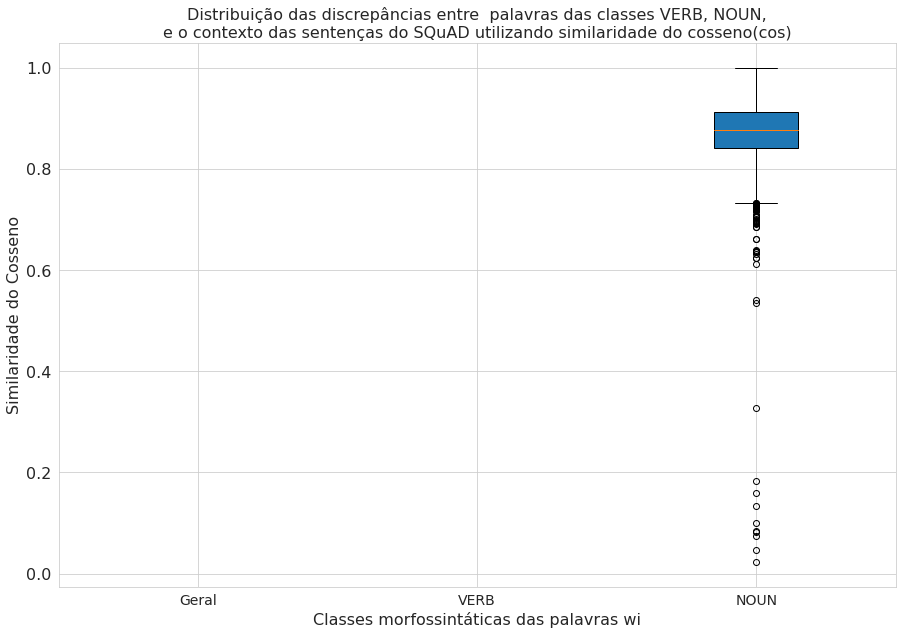

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre  palavras das classes VERB, NOUN,\ne o contexto das sentenças do SQuAD utilizando similaridade do cosseno(cos)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

colunas = [lista_comparacao_contexto[["cos_ctxnoun_mean"]], lista_comparacao_classesVV[["cos_ctxnoun_mean"]], lista_comparacao_classesNN[["cos_ctxnoun_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

##### EUC

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["euc_ctxnoun_mean"]],
                    lista_comparacao_classesVV[["euc_ctxnoun_mean"]], 
                    lista_comparacao_classesNN[["euc_ctxnoun_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral             VERB             NOUN
      euc_ctxnoun_mean euc_ctxnoun_mean euc_ctxnoun_mean
count     29486.000000      2648.000000      6055.000000
mean         33.964472        35.495837        19.116736
std           9.859509         4.685970         8.036059
min           0.000000        22.252539         0.000000
25%          29.848417        32.133248        17.822170
50%          35.280743        35.117876        21.040995
75%          40.114353        38.347888        23.792994
max          59.477032        54.982056        39.371788

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


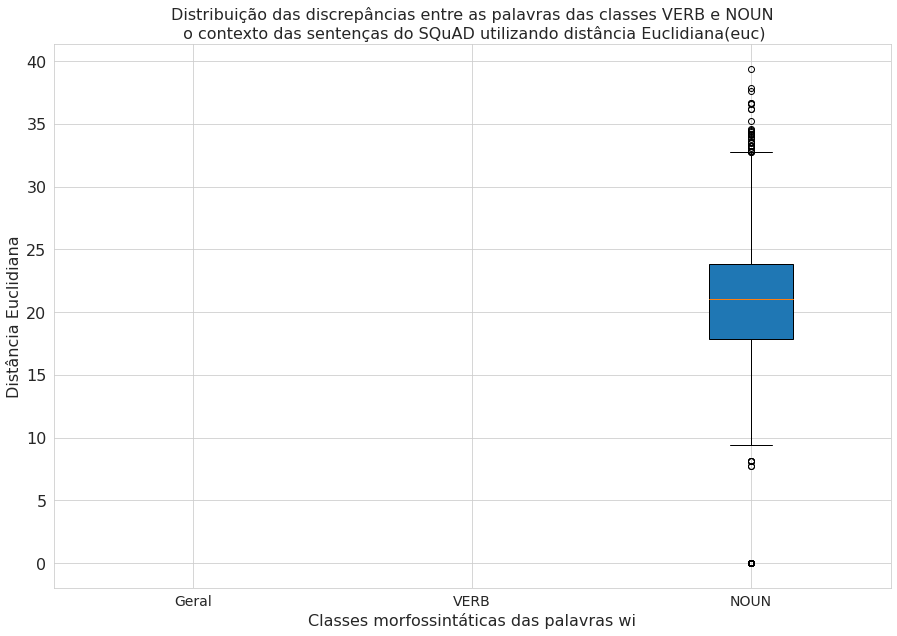

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n o contexto das sentenças do SQuAD utilizando distância Euclidiana(euc)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

colunas = [lista_comparacao_contexto[["euc_ctxnoun_mean"]], lista_comparacao_classesVV[["euc_ctxnoun_mean"]], lista_comparacao_classesNN[["euc_ctxnoun_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3 ], ["Geral", "VERB", "NOUN"])

plt.show()

##### MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["man_ctxnoun_mean"]],
                    lista_comparacao_classesVV[["man_ctxnoun_mean"]], 
                    lista_comparacao_classesNN[["man_ctxnoun_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral             VERB             NOUN
      man_ctxnoun_mean man_ctxnoun_mean man_ctxnoun_mean
count     29486.000000      2648.000000      6055.000000
mean       1683.572220      1787.281695       954.700089
std         478.712894       237.028828       401.621833
min           0.000000      1106.121582         0.000000
25%        1484.906006      1613.358398       890.585510
50%        1759.731079      1771.020752      1049.510986
75%        1996.338989      1936.403931      1186.907227
max        2929.408203      2556.067383      1837.491943

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


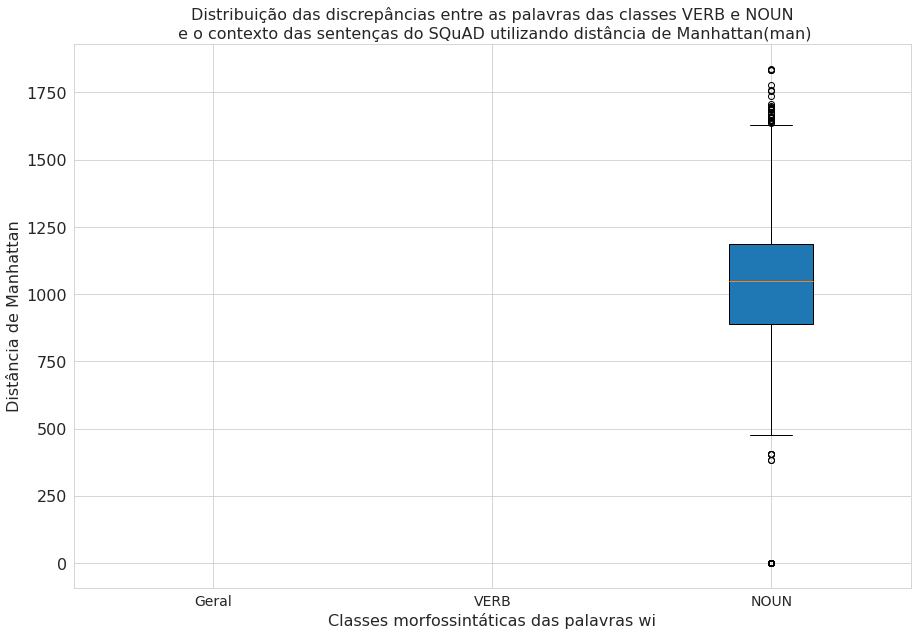

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n e o contexto das sentenças do SQuAD utilizando distância de Manhattan(man)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

colunas = [lista_comparacao_contexto[["man_ctxnoun_mean"]], lista_comparacao_classesVV[["man_ctxnoun_mean"]], lista_comparacao_classesNN[["man_ctxnoun_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

### Contexto com palavras da classe VERB(AUX) e NOUN(ctxverbnoun)

#### VERB

In [ ]:
classe_morfosintatica = "VERB"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesVV = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 2895


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxverbnoun_mean","euc_ctxverbnoun_mean","man_ctxverbnoun_mean","cos_ctxverbnoun_max","euc_ctxverbnoun_max","man_ctxverbnoun_max",]].describe(include=["float", "int"]) 

cos_ctxverbnoun_mean  euc_ctxverbnoun_mean  man_ctxverbnoun_mean  \
count           2895.000000           2895.000000           2895.000000   
mean               0.836039             24.326164           1226.038177   
std                0.055858              4.521906            227.553703   
min                0.065938              0.000000              0.000000   
25%                0.807182             22.097265           1113.761658   
50%                0.838055             24.546268           1237.498047   
75%                0.869528             26.895276           1359.444153   
max                1.000000             40.631443           2027.508545   

       cos_ctxverbnoun_max  euc_ctxverbnoun_max  man_ctxverbnoun_max  
count          2895.000000          2895.000000          2895.000000  
mean              0.831800            24.754988          1249.125566  
std               0.062793             5.031032           256.171195  
min               0.065938             0.000000             0.000000  
25%               0.803798            22.232327          1123.550049  
50%               0.836599            24.786674          1251.074585  
75%               0.868831            27.265338          1375.003479  
max               1.000000            49.032181          2590.377441

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo VERB

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/2895 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        3  394
      2        4  352
      3        5  352
      4        6  322
      5        7  266
      6        2  250
      7        1  217
      8        8  210
      9        9  146
     10       10  118
     11       11   91
     12       12   50
     13       13   45
     14       14   23
     15       15   16
     16        0   15
     17       16   12
     18       19    5
     19       18    5
     20       20    2


##### COS - MEAN

In [ ]:
medida = "cos_ctxverbnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.06234505772590637
Limite superior             : 0.9630451053380966
Limite inferior             : 0.7136648744344711


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 34 de 2895 ( 0.011744386873920553 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 46 de 2895 ( 0.015889464594127805 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  80 de 2895 ( 0.027633851468048358 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1.0 closed
         What Antartcic Church closed in 2004?

 2 1.0 contributes
         Who contributes to UNFPA?

 3 1.0 died
         Who died in the 913 ?

 4 1.0 founded
         Who founded the Tibetan Empire?

 5 1.0 built
         Who built the Tibetan Empire ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverbnoun) < limite_inferior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.0659378990530967 -
         When was the Armenian Mosaic re - discovered ?

 2 0.0659378990530967 -
         When was the Armenian Mosaic re-discovered?

 3 0.5841769576072693 Following
         Following the Liberal victory in 2015 , standing orders were changed to Say what ?

 4 0.5862544775009155 minted
         When were oldly minted coins presented to prove they met standards ?

 5 0.5915358066558838 minted
         When were oldly minted coins presented to ensure they met standards?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverbnoun) < limite_inferior)  entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Do the values for symbols on modern keyboards correspond closely to the ASCII table ?
       1 0.7131046056747437 correspond

 2 What was inflicting heavy losses and increasing the air war designed to do?
       1 0.8191651701927185 inflicting
       2 0.7251620888710022 increasing
       3 0.7126161456108093 designed
       4 0.6841533780097961 do

 3 According to Snjezana Kordic how long has the language discussion lasted?
       1 0.7722076177597046 lasted
       2 0.7117554545402527 According

 4 According to Snjezana Kordic how long has the language discussion lasted ?
       1 0.7722076177597046 lasted
       2 0.7117554545402527 According

 5 What concern has caused national associations and clubs to disagree about friendlies?
       1 0.8183555006980896 disagree
       2 0.7114362716674805 caused


##### COS - MAX

In [ ]:
medida = "cos_ctxverbnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.06503301858901978
Limite superior             : 0.9663800895214081
Limite inferior             : 0.706248015165329


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 34 de 2895 ( 0.011744386873920553 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 88 de 2895 ( 0.030397236614853194 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  122 de 2895 ( 0.04214162348877375 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1.0 closed
         What Antartcic Church closed in 2004?

 2 1.0 contributes
         Who contributes to UNFPA?

 3 1.0 died
         Who died in the 913 ?

 4 1.0 founded
         Who founded the Tibetan Empire?

 5 1.0 built
         Who built the Tibetan Empire ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverbnoun) < limite_inferior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.0659378990530967 -
         When was the Armenian Mosaic re - discovered ?

 2 0.0659378990530967 -
         When was the Armenian Mosaic re-discovered?

 3 0.5195233225822449 diaphragming
         Why did some music lovers frown upon diaphragming?

 4 0.5282084941864014 Stretched
         Stretched rocks that turn into lenses are known by what word ?

 5 0.5339729189872742 disproved
         It has been disproved that each class is included into what?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverbnoun) < limite_inferior)  entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 How do birds conserve energy?
       1 0.7053274512290955 conserve

 2 Following the Liberal victory in 2015 , standing orders were changed to Say what ?
       1 0.7859961986541748 standing
       2 0.752493143081665 changed
       3 0.702325165271759 Say
       4 0.5841769576072693 Following

 3 What business that sells cheap alcohol has sometimes been held to have resulted in the decline of pubs?
       1 0.8056684136390686 resulted
       2 0.709065854549408 held
       3 0.7010654807090759 sells

 4 Western Armenian aspirated corresponds to Eastern American what?
       1 0.700836718082428 aspirated

 5 What is this cultural movement called that involves a shift in gender relations mainly excluding women?
       1 0.8202401399612427 involves
       2 0.7278874516487122 excluding
       3 0.7004762291908264 called


##### EUC - MEAN

In [ ]:
medida = "euc_ctxverbnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.79801082611084
Limite superior             : 34.09229230880737
Limite inferior             : 14.900249004364014


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 27 de 2895 ( 0.00932642487046632 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 40 de 2895 ( 0.013816925734024179 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  67 de 2895 ( 0.0231433506044905 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 40.63144302368164 force
         How much did Wilber force Bell gave him in order to look at Gray 's paperwork ?

 2 39.68800354003906 Following
         Following the Liberal victory in 2015 , standing orders were changed to Say what ?

 3 39.20683288574219 throw
         What group wanted to use violent means to over throw the British rule ?

 4 39.20683288574219 throw
         What group wanted to use violent means to over throw the British rule?

 5 38.94206619262695 Following
         Following the Liberal victory in 2015, standing orders were changed to do what?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverbnoun) < limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.0 closed
         What Antartcic Church closed in 2004?

 2 0.0 makes
         What makes Neptune blue?

 3 0.0 dies
         Who dies in the 913?

 4 0.0 died
         Who died in the 913 ?

 5 0.0 founded
         Who founded the Tibetan Empire?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior)   entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 How much did Wilber force Bell gave him in order to look at Gray 's paperwork ?
       1 40.63144302368164 force
       2 26.11809730529785 look
       3 25.47528076171875 gave

 2 Following the Liberal victory in 2015 , standing orders were changed to Say what ?
       1 39.68800354003906 Following
       2 32.02278137207031 Say
       3 30.78864288330078 changed
       4 29.119792938232425 standing

 3 What group wanted to use violent means to over throw the British rule ?
       1 39.20683288574219 throw
       2 23.94753646850586 wanted
       3 22.20948028564453 use

 4 What group wanted to use violent means to over throw the British rule?
       1 39.20683288574219 throw
       2 23.94753646850586 wanted
       3 22.20948028564453 use

 5 Following the Liberal victory in 2015, standing orders were changed to do what?
       1 38.94206619262695 Following
       2 30.90752410888672 do
       3 30.38603973388672 changed
       4 28.362388610839844 standing


##### EUC - MAX

In [ ]:
medida = "euc_ctxverbnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 5.033010482788086
Limite superior             : 34.81485366821289
Limite inferior             : 14.682811737060547


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 74 de 2895 ( 0.025561312607944732 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 40 de 2895 ( 0.013816925734024179 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  114 de 2895 ( 0.039378238341968914 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 49.03218078613281 diaphragming
         Why did some music lovers frown upon diaphragming?

 2 47.11960983276367 Occupy
         On what date did the Occupy Wall Street protests begin ?

 3 46.76997756958008 Occupy
         On what date did the Occupy Wall Street protests commence?

 4 46.17610168457031 affixed
         What generation saw iPod batterys being affixed with glue?

 5 46.00227737426758 affixed
         What generation of iPod batterys being affixed with glue ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverbnoun) < limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.0 closed
         What Antartcic Church closed in 2004?

 2 0.0 makes
         What makes Neptune blue?

 3 0.0 dies
         Who dies in the 913?

 4 0.0 died
         Who died in the 913 ?

 5 0.0 founded
         Who founded the Tibetan Empire?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior)   entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Why did some music lovers frown upon diaphragming?
       1 49.03218078613281 diaphragming
       2 29.38703346252441 frown

 2 On what date did the Occupy Wall Street protests begin ?
       1 47.11960983276367 Occupy
       2 27.291139602661133 begin

 3 On what date did the Occupy Wall Street protests commence?
       1 46.76997756958008 Occupy
       2 27.8089542388916 commence

 4 What generation saw iPod batterys being affixed with glue?
       1 46.17610168457031 affixed
       2 24.24331283569336 saw

 5 What generation of iPod batterys being affixed with glue ?
       1 46.00227737426758 affixed


##### MAN - MEAN

In [ ]:
medida = "man_ctxverbnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 245.6824951171875
Limite superior             : 1727.9678955078125
Limite inferior             : 745.2379150390625


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 24 de 2895 ( 0.008290155440414507 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 39 de 2895 ( 0.013471502590673576 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  63 de 2895 ( 0.021761658031088083 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 2027.508544921875 force
         How much did Wilber force Bell gave him in order to look at Gray 's paperwork ?

 2 1959.34423828125 throw
         What group wanted to use violent means to over throw the British rule ?

 3 1959.34423828125 throw
         What group wanted to use violent means to over throw the British rule?

 4 1901.159423828125 Following
         Following the Liberal victory in 2015 , standing orders were changed to Say what ?

 5 1882.26708984375 closed
         What was closed in order to create a fight sequence using a boat ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxverbnoun) < limite_inferior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 722.6123657226562 do
         What did the Japanese do on September 30 , 1914 ?

 2 715.101806640625 have
         How many " temporal series " did McTaggart have ?

 3 711.7454833984375 do
         What did Mazda do in the US in 1973 ?

 4 689.105224609375 established
         When was Laidlaw Leeds first established?

 5 677.3690185546875 provided
         Who provided financial backing to the United States?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior)   entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 How much did Wilber force Bell gave him in order to look at Gray 's paperwork ?
       1 2027.508544921875 force
       2 1315.517578125 look
       3 1307.4893798828125 gave

 2 What group wanted to use violent means to over throw the British rule ?
       1 1959.34423828125 throw
       2 1202.43994140625 wanted
       3 1116.589599609375 use

 3 What group wanted to use violent means to over throw the British rule?
       1 1959.34423828125 throw
       2 1202.43994140625 wanted
       3 1116.589599609375 use

 4 Following the Liberal victory in 2015 , standing orders were changed to Say what ?
       1 1901.159423828125 Following
       2 1604.3538818359375 Say
       3 1551.0819091796875 changed
       4 1475.5970458984375 standing

 5 What was closed in order to create a fight sequence using a boat ?
       1 1882.26708984375 closed
       2 1276.475830078125 using
       3 1248.6195068359375 create


##### MAN - MAX

In [ ]:
medida = "man_ctxverbnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 251.45343017578125
Limite superior             : 1752.1836242675781
Limite inferior             : 746.3699035644531


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 65 de 2895 ( 0.022452504317789293 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 39 de 2895 ( 0.013471502590673576 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  104 de 2895 ( 0.03592400690846287 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 2590.37744140625 diaphragming
         Why did some music lovers frown upon diaphragming?

 2 2485.479248046875 strenthened
         What war strenthened the monarchs position?

 3 2482.617431640625 Occupy
         On what date did the Occupy Wall Street protests begin ?

 4 2465.220947265625 Occupy
         On what date did the Occupy Wall Street protests commence?

 5 2461.0234375 affixed
         What generation saw iPod batterys being affixed with glue?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxverbnoun) < limite_inferior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 722.6123657226562 do
         What did the Japanese do on September 30 , 1914 ?

 2 715.101806640625 have
         How many " temporal series " did McTaggart have ?

 3 711.7454833984375 do
         What did Mazda do in the US in 1973 ?

 4 689.105224609375 established
         When was Laidlaw Leeds first established?

 5 677.3690185546875 provided
         Who provided financial backing to the United States?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior)   entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Why did some music lovers frown upon diaphragming?
       1 2590.37744140625 diaphragming
       2 1475.2388916015625 frown

 2 What war strenthened the monarchs position?
       1 2485.479248046875 strenthened

 3 On what date did the Occupy Wall Street protests begin ?
       1 2482.617431640625 Occupy
       2 1375.05712890625 begin

 4 On what date did the Occupy Wall Street protests commence?
       1 2465.220947265625 Occupy
       2 1411.464111328125 commence

 5 What generation saw iPod batterys being affixed with glue?
       1 2461.0234375 affixed
       2 1233.965087890625 saw


#### NOUN

In [ ]:
classe_morfosintatica = "NOUN"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesNN = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 6055


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxverbnoun_mean","euc_ctxverbnoun_mean","man_ctxverbnoun_mean","cos_ctxverbnoun_max","euc_ctxverbnoun_max","man_ctxverbnoun_max",]].describe(include=["float", "int"]) 

cos_ctxverbnoun_mean  euc_ctxverbnoun_mean  man_ctxverbnoun_mean  \
count           6055.000000           6055.000000           6055.000000   
mean               0.830350             24.226423           1213.047772   
std                0.055481              3.390877            169.823894   
min               -0.041515              0.000000              0.000000   
25%                0.805600             22.082335           1103.569702   
50%                0.834755             24.209312           1211.260010   
75%                0.861102             26.275949           1318.483459   
max                1.000000             41.524250           1843.390137   

       cos_ctxverbnoun_max  euc_ctxverbnoun_max  man_ctxverbnoun_max  
count          6055.000000          6055.000000          6055.000000  
mean              0.820248            25.231708          1266.322006  
std               0.065579             4.379315           225.783378  
min              -0.041515             0.000000             0.000000  
25%               0.795883            22.616647          1132.987915  
50%               0.829348            24.736525          1240.695068  
75%               0.857713            27.154864          1360.448608  
max               1.000000            51.008263          2733.724854

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo NOUN

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/6055 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        3  703
      2        1  637
      3        4  587
      4        2  563
      5        6  559
      6        5  530
      7        7  508
      8        8  457
      9        9  347
     10       10  291
     11       11  203
     12       12  171
     13       13  124
     14       14  104
     15       15   78
     16       16   50
     17        0   34
     18       17   29
     19       18   19
     20       19   19


##### COS - MEAN

In [ ]:
medida = "cos_ctxverbnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.05550166964530945
Limite superior             : 0.9443543702363968
Limite inferior             : 0.722347691655159


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 13 de 6055 ( 0.0021469859620148637 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 105 de 6055 ( 0.017341040462427744 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  118 de 6055 ( 0.019488026424442608 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1.0 sea
         The present Mediterranean Sea , from what sea ?

 2 1.0 USB
         USB for what ?

 3 1.0 park
         Name Philidelphia's largest park?

 4 1.0 area
         Buddhism , in what area ?

 5 1.0 reign
         Safavid Iran , during whose reign ?


###### Top 5 documentos com as maiores discrepânciass (cos(wi,ctxverbnoun) < limite_inferior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 -0.0415152348577976 -
         non-LEDs are often used for what type of systems?

 2 -0.0047722863964736 leg
         Who probably located the island on their final leg of their circumnavigation trip?

 3 0.0001018917391775 -
         Who were the two National Assembly vice-presidents in Egypt?

 4 0.0012343584094196 leg
         Who probably visited the island on their final leg of their circumnavigation trip ?

 5 0.0080426335334777 -
         Did the FBI reassign agents from counter-intelligence to violent crime?


###### Top 5 documentos com as maiores discrepâncias  (cos(wi,ctxverbnoun) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 The 2008 study related to Napoleon 's death found that hair collected from Napoleon 's hair as well as that of his family and contemporaries , had arsenic levels approximately how many times higher than current averages ?
       1 0.7987392544746399 arsenic
       2 0.7886495590209961 levels
       3 0.7821429371833801 hair
       4 0.7777135372161865 study
       5 0.7584799528121948 averages
       6 0.7578415274620056 contemporaries
       7 0.7319917678833008 hair
       8 0.7234281301498413 family
       9 0.7223366498947144 times
       10 0.7126567363739014 death

 2 The 2008 study related to Napoleon's death found that hair collected from Napoleon's hair as well as that of his family and contemporaries, had arsenic levels approximately how many times higher than current averages?
       1 0.7987392544746399 arsenic
       2 0.7886495590209961 levels
       3 0.7821429371833801 hair
       4 0.7777135372161865 study
       5 0.7584799528121948 averages
       6 0.75784152746

##### COS - MAX

In [ ]:
medida = "cos_ctxverbnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.06182989478111267
Limite superior             : 0.950457975268364
Limite inferior             : 0.7031383961439133


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 10 de 6055 ( 0.0016515276630883566 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 270 de 6055 ( 0.04459124690338563 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  280 de 6055 ( 0.046242774566473986 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1.0 sea
         The present Mediterranean Sea , from what sea ?

 2 1.0 USB
         USB for what ?

 3 1.0 park
         Name Philidelphia's largest park?

 4 1.0 area
         Buddhism , in what area ?

 5 1.0 reign
         Safavid Iran , during whose reign ?


###### Top 5 documentos com as maiores discrepânciass (cos(wi,ctxverbnoun) < limite_inferior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 -0.0415152348577976 -
         non-LEDs are often used for what type of systems?

 2 -0.0047722863964736 leg
         Who probably located the island on their final leg of their circumnavigation trip?

 3 0.0001018917391775 -
         Who were the two National Assembly vice-presidents in Egypt?

 4 0.0012343584094196 leg
         Who probably visited the island on their final leg of their circumnavigation trip ?

 5 0.0080426335334777 -
         Did the FBI reassign agents from counter-intelligence to violent crime?


###### Top 5 documentos com as maiores discrepâncias  (cos(wi,ctxverbnoun) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 What two women tried to commit perjury in the Book of Exodus ?
       1 0.8293657898902893 women
       2 0.7031304240226746 perjury

 2 The last tsar of Russia , Nicholas ll get his first elevator at the Hotel Adloin in what city ?
       1 0.8028171062469482 elevator
       2 0.7721360325813293 city
       3 0.7030235528945923 tsar

 3 What day will the business that first rang a bell to begin in the winter of 2014 in Myanmar open its doors to customers ?
       1 0.7864817380905151 business
       2 0.7685678005218506 customers
       3 0.7474534511566162 doors
       4 0.7145208120346069 bell
       5 0.7028163075447083 day
       6 0.6916080117225647 winter

 4 Which term is criticized as having abstract overreach?
       1 0.8658723831176758 term
       2 0.702487587928772 overreach

 5 Critics of the HDI cite its focus on which: egalitarianism or authoritarianism?
       1 0.8041141629219055 focus
       2 0.7244775295257568 authoritarianism
       3 0.7023608684539795 Criti

##### EUC - MEAN

In [ ]:
medida = "euc_ctxverbnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.193613052368164
Limite superior             : 32.566368103027344
Limite inferior             : 15.791915893554688


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 72


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 25 de 6055 ( 0.004128819157720892 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  97 de 6055 ( 0.01601981833195706 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 41.52425003051758 -
         non-LEDs are often used for what type of systems?

 2 39.85166549682617 -
         What team were responsible for the re - release Digimon

 3 38.92928695678711 -
         Who were the two National Assembly vice-presidents in Egypt?

 4 38.824649810791016 -
         Which genres were least influenced by post-punk?

 5 38.10419464111328 -
         Did the FBI reassign agents from counter-intelligence to violent crime?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverbnoun) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.0 sea
         The present Mediterranean Sea , from what sea ?

 2 0.0 reign
         Safavid Iran , during whose reign ?

 3 0.0 administration
         Whose administration of the Paymaster General Act ?

 4 0.0 pantheist
         Or a famous pantheist ?

 5 0.0 USB
         USB for what ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 non-LEDs are often used for what type of systems?
       1 41.52425003051758 -
       2 26.47897720336914 type
       3 22.371461868286133 systems
       4 19.608375549316406 LEDs

 2 What team were responsible for the re - release Digimon
       1 39.85166549682617 -
       2 27.092538833618164 release
       3 25.434791564941406 re
       4 24.52096366882324 team

 3 Who were the two National Assembly vice-presidents in Egypt?
       1 38.92928695678711 -
       2 28.71211624145508 vice
       3 27.30878257751465 presidents

 4 Which genres were least influenced by post-punk?
       1 38.824649810791016 -
       2 24.858612060546875 punk
       3 23.684324264526367 genres

 5 Did the FBI reassign agents from counter-intelligence to violent crime?
       1 38.10419464111328 -
       2 26.21088981628418 agents
       3 25.383607864379883 crime
       4 24.05782127380371 intelligence
       5 23.84113883972168 counter


##### EUC - MAX

In [ ]:
medida = "euc_ctxverbnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.538217544555664
Limite superior             : 33.96219062805176
Limite inferior             : 15.809320449829102


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 259


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 20 de 6055 ( 0.0033030553261767133 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  279 de 6055 ( 0.046077621800165156 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 51.008262634277344 circumnavigation
         Who probably visited the island on their final leg of their circumnavigation trip ?

 2 50.92060089111328 circumnavigation
         Who probably located the island on their final leg of their circumnavigation trip?

 3 48.56189727783203 Inhabitants
         Inhabitants of Judah are known as what?

 4 48.56189727783203 Inhabitants
         Inhabitants of Judah are known as what ?

 5 47.30389022827149 esablishment
         The treaty of Paris return how many esablishment captured by the British?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverbnoun) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.0 park
         Name Philidelphia's largest park?

 2 0.0 administration
         Whose administration of the Paymaster General Act ?

 3 0.0 sea
         The present Mediterranean Sea , from what sea ?

 4 0.0 city
         Along with Saint Paul , what city in the Twin Cities ?

 5 0.0 reign
         Safavid Iran , during whose reign ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Who probably visited the island on their final leg of their circumnavigation trip ?
       1 51.008262634277344 circumnavigation
       2 36.82652282714844 leg
       3 27.984357833862305 trip
       4 27.7421989440918 island

 2 Who probably located the island on their final leg of their circumnavigation trip?
       1 50.92060089111328 circumnavigation
       2 36.911888122558594 leg
       3 27.963489532470703 trip
       4 27.201181411743164 island

 3 Inhabitants of Judah are known as what?
       1 48.56189727783203 Inhabitants

 4 Inhabitants of Judah are known as what ?
       1 48.56189727783203 Inhabitants

 5 The treaty of Paris return how many esablishment captured by the British?
       1 47.30389022827149 esablishment
       2 23.99978446960449 treaty


##### MAN - MEAN

In [ ]:
medida = "man_ctxverbnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 214.91375732421875
Limite superior             : 1640.8540954589844
Limite inferior             : 781.1990661621094


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 63


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 21 de 6055 ( 0.003468208092485549 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  84 de 6055 ( 0.013872832369942197 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1843.39013671875 addition
         In addition to the head and abdomen , what is the other major section of an insect 's body ?

 2 1843.39013671875 addition
         In addition to the head and abdomen, what is the other major section of an insect's body?

 3 1833.2440185546875 %
         The amount of material used as a crop protection measure decreased from 1kg/ha in what year to its current 1%?

 4 1823.664794921875 proportion
         What proportion of Tennessee counties have their Sheriff as their head law enforcement official ?

 5 1820.77880859375 proportion
         What proportion of Tennessee counties recognize their Sheriff as their head law enforcement official?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxverbnoun) < limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 781.02587890625 divisors
         What are the specific divisors of all even numbers larger than 2?

 2 781.02587890625 divisors
         What are the specific divisors of all even numbers larger than 2 ?

 3 772.0093383789062 LEDs
         How are LEDs similar to other diodes?

 4 763.7117919921875 construction
         The Queensboro Bridge , what type of construction ?

 5 763.7117309570312 type
         The Queensboro Bridge , what type of construction ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 In addition to the head and abdomen , what is the other major section of an insect 's body ?
       1 1843.39013671875 addition
       2 1355.380126953125 section
       3 1329.4580078125 head
       4 1286.118408203125 abdomen
       5 1225.784423828125 insect
       6 1064.7490234375 body

 2 In addition to the head and abdomen, what is the other major section of an insect's body?
       1 1843.39013671875 addition
       2 1355.380126953125 section
       3 1329.4580078125 head
       4 1286.118408203125 abdomen
       5 1225.784423828125 insect
       6 1064.7490234375 body

 3 The amount of material used as a crop protection measure decreased from 1kg/ha in what year to its current 1%?
       1 1833.2440185546875 %
       2 1436.2320556640625 year
       3 1354.254638671875 crop
       4 1347.30224609375 1kg
       5 1259.6455078125 amount
       6 1258.3134765625 protection
       7 1222.9786376953125 measure
       8 1221.3330078125 material

 4 What proportion of Tennessee 

##### MAN - MAX

In [ ]:
medida = "man_ctxverbnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 227.460693359375
Limite superior             : 1701.6396484375
Limite inferior             : 791.796875


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 251


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 18 de 6055 ( 0.002972749793559042 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  269 de 6055 ( 0.044426094137076794 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 2733.724853515625 circumnavigation
         Who probably visited the island on their final leg of their circumnavigation trip ?

 2 2729.455078125 circumnavigation
         Who probably located the island on their final leg of their circumnavigation trip?

 3 2534.0244140625 Inhabitants
         Inhabitants of Judah are known as what?

 4 2534.0244140625 Inhabitants
         Inhabitants of Judah are known as what ?

 5 2512.121826171875 esablishment
         The treaty of Paris return how many esablishment captured by the British?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxverbnoun) < limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 791.489990234375 monopoly
         Who was eventually bankrupt due to their virtual monopoly?

 2 784.1795654296875 parties
         What party is similar to Irish republican parties?

 3 781.4012451171875 writers
         Which writers emphasize the external rather than the internal ?

 4 763.7117919921875 construction
         The Queensboro Bridge , what type of construction ?

 5 763.7117309570312 type
         The Queensboro Bridge , what type of construction ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes = lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Who probably visited the island on their final leg of their circumnavigation trip ?
       1 2733.724853515625 circumnavigation
       2 1361.85205078125 trip
       3 1304.8856201171875 island
       4 1093.70849609375 leg

 2 Who probably located the island on their final leg of their circumnavigation trip?
       1 2729.455078125 circumnavigation
       2 1362.3656005859375 trip
       3 1272.056396484375 island
       4 1092.2596435546875 leg

 3 Inhabitants of Judah are known as what?
       1 2534.0244140625 Inhabitants

 4 Inhabitants of Judah are known as what ?
       1 2534.0244140625 Inhabitants

 5 The treaty of Paris return how many esablishment captured by the British?
       1 2512.121826171875 esablishment
       2 1204.42724609375 treaty


#### Comparando discrepância entre o contexto de palavras VERB e NOUN e palavras de todas as classes, VERB e NOUN.

##### COS, EUC, MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxverbnoun_mean","euc_ctxverbnoun_mean","man_ctxverbnoun_mean","cos_ctxverbnoun_max","euc_ctxverbnoun_max","man_ctxverbnoun_max",]].dropna(),
                    lista_comparacao_classesVV[["cos_ctxverbnoun_mean","euc_ctxverbnoun_mean","man_ctxverbnoun_mean","cos_ctxverbnoun_max","euc_ctxverbnoun_max","man_ctxverbnoun_max",]].dropna(), 
                    lista_comparacao_classesNN[["cos_ctxverbnoun_mean","euc_ctxverbnoun_mean","man_ctxverbnoun_mean","cos_ctxverbnoun_max","euc_ctxverbnoun_max","man_ctxverbnoun_max",]].dropna(),
                    ], 
                    axis="columns", 
                   keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                                            \
      cos_ctxverbnoun_mean euc_ctxverbnoun_mean man_ctxverbnoun_mean   
count         31745.000000         31745.000000         31745.000000   
mean              0.707161            30.983532          1534.071165   
std               0.172588             7.368571           339.689558   
min              -0.300637             0.000000             0.000000   
25%               0.644131            25.455311          1280.292725   
50%               0.734913            30.576893          1525.698120   
75%               0.819896            35.488430          1765.862915   
max               1.000000            54.833580          2635.469238   

                                                                   \
      cos_ctxverbnoun_max euc_ctxverbnoun_max man_ctxverbnoun_max   
count        31745.000000        31745.000000        31745.000000   
mean             0.701113           31.596762         1566.914144   
std              0.173463            7.558955          353.345494   
min             -0.300637            0.000000            0.000000   
25%              0.634293           25.877983         1302.075562   
50%              0.727629           31.235025         1558.575684   
75%              0.816082           36.260708         1803.820557   
max              1.000000           57.873421         3067.160156   

                      VERB                                            \
      cos_ctxverbnoun_mean euc_ctxverbnoun_mean man_ctxverbnoun_mean   
count          2895.000000          2895.000000          2895.000000   
mean              0.836039            24.326164          1226.038177   
std               0.055858             4.521906           227.553703   
min               0.065938             0.000000             0.000000   
25%               0.807182            22.097265          1113.761658   
50%               0.838055            24.546268          1237.498047   
75%               0.869528            26.895276          1359.444153   
max               1.000000            40.631443          2027.508545   

                                                                   \
      cos_ctxverbnoun_max euc_ctxverbnoun_max man_ctxverbnoun_max   
count         2895.000000         2895.000000         2895.000000   
mean             0.831800           24.754988         1249.125566   
std              0.062793            5.031032          256.171195   
min              0.065938            0.000000            0.000000   
25%              0.803798           22.232327         1123.550049   
50%              0.836599           24.786674         1251.074585   
75%              0.868831           27.265338         1375.003479   
max              1.000000           49.032181         2590.377441   

                      NOUN                                            \
      cos_ctxverbnoun_mean euc_ctxverbnoun_mean man_ctxverbnoun_mean   
count          6055.000000          6055.000000          6055.000000   
mean              0.830350            24.226423          1213.047772   
std               0.055481             3.390877           169.823894   
min              -0.041515             0.000000             0.000000   
25%               0.805600            22.082335          1103.569702   
50%               0.834755            24.209312          1211.260010   
75%               0.861102            26.275949          1318.483459   
max               1.000000            41.524250          1843.390137   

                                                                   
      cos_ctxverbnoun_max euc_ctxverbnoun_max man_ctxverbnoun_max  
count         6055.000000         6055.000000         6055.000000  
mean             0.820248           25.231708         1266.322006  
std              0.065579            4.379315          225.783378  
min             -0.041515            0.000000            0.000000  
25%              0.795883           22.616647         1132.987915  


##### COS

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxverbnoun_mean"]].dropna(),                    
                    lista_comparacao_classesVV[["cos_ctxverbnoun_mean"]].dropna(), 
                    lista_comparacao_classesNN[["cos_ctxverbnoun_mean"]].dropna(),
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                 VERB                 NOUN
      cos_ctxverbnoun_mean cos_ctxverbnoun_mean cos_ctxverbnoun_mean
count         31745.000000          2895.000000          6055.000000
mean              0.707161             0.836039             0.830350
std               0.172588             0.055858             0.055481
min              -0.300637             0.065938            -0.041515
25%               0.644131             0.807182             0.805600
50%               0.734913             0.838055             0.834755
75%               0.819896             0.869528             0.861102
max               1.000000             1.000000             1.000000

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


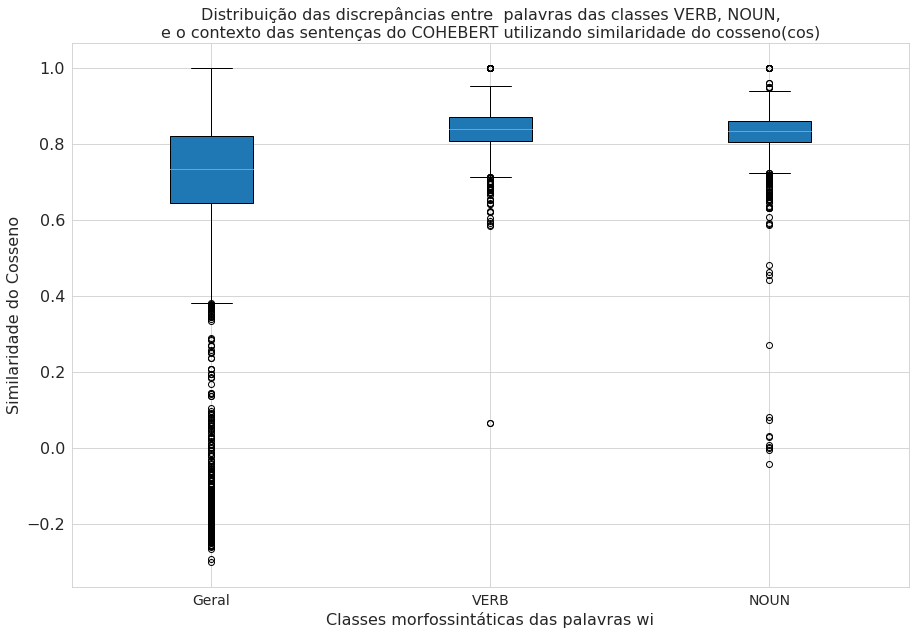

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre  palavras das classes VERB, NOUN,\ne o contexto das sentenças do COHEBERT utilizando similaridade do cosseno(cos)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

colunas = [lista_comparacao_contexto[["cos_ctxverbnoun_mean"]].dropna(), 
           lista_comparacao_classesVV[["cos_ctxverbnoun_mean"]].dropna(), 
           lista_comparacao_classesNN[["cos_ctxverbnoun_mean"]].dropna()]

ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

##### EUC

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["euc_ctxverbnoun_mean"]].dropna(),
                    lista_comparacao_classesVV[["euc_ctxverbnoun_mean"]].dropna(), 
                    lista_comparacao_classesNN[["euc_ctxverbnoun_mean"]].dropna(),                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                 VERB                 NOUN
      euc_ctxverbnoun_mean euc_ctxverbnoun_mean euc_ctxverbnoun_mean
count         31745.000000          2895.000000          6055.000000
mean             30.983532            24.326164            24.226423
std               7.368571             4.521906             3.390877
min               0.000000             0.000000             0.000000
25%              25.455311            22.097265            22.082335
50%              30.576893            24.546268            24.209312
75%              35.488430            26.895276            26.275949
max              54.833580            40.631443            41.524250

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


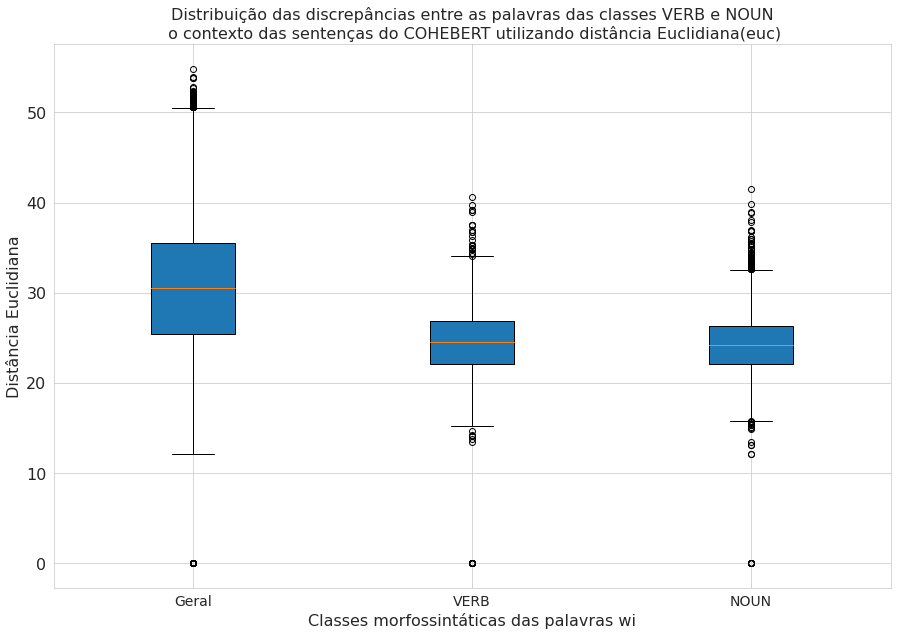

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n o contexto das sentenças do COHEBERT utilizando distância Euclidiana(euc)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

colunas = [lista_comparacao_contexto[["euc_ctxverbnoun_mean"]].dropna(), 
           lista_comparacao_classesVV[["euc_ctxverbnoun_mean"]].dropna(), 
           lista_comparacao_classesNN[["euc_ctxverbnoun_mean"]].dropna()]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3 ], ["Geral", "VERB", "NOUN"])

plt.show()

##### MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["man_ctxverbnoun_mean"]].dropna(),
                    lista_comparacao_classesVV[["man_ctxverbnoun_mean"]].dropna(), 
                    lista_comparacao_classesNN[["man_ctxverbnoun_mean"]].dropna(),                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                 VERB                 NOUN
      man_ctxverbnoun_mean man_ctxverbnoun_mean man_ctxverbnoun_mean
count         31745.000000          2895.000000          6055.000000
mean           1534.071165          1226.038177          1213.047772
std             339.689558           227.553703           169.823894
min               0.000000             0.000000             0.000000
25%            1280.292725          1113.761658          1103.569702
50%            1525.698120          1237.498047          1211.260010
75%            1765.862915          1359.444153          1318.483459
max            2635.469238          2027.508545          1843.390137

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


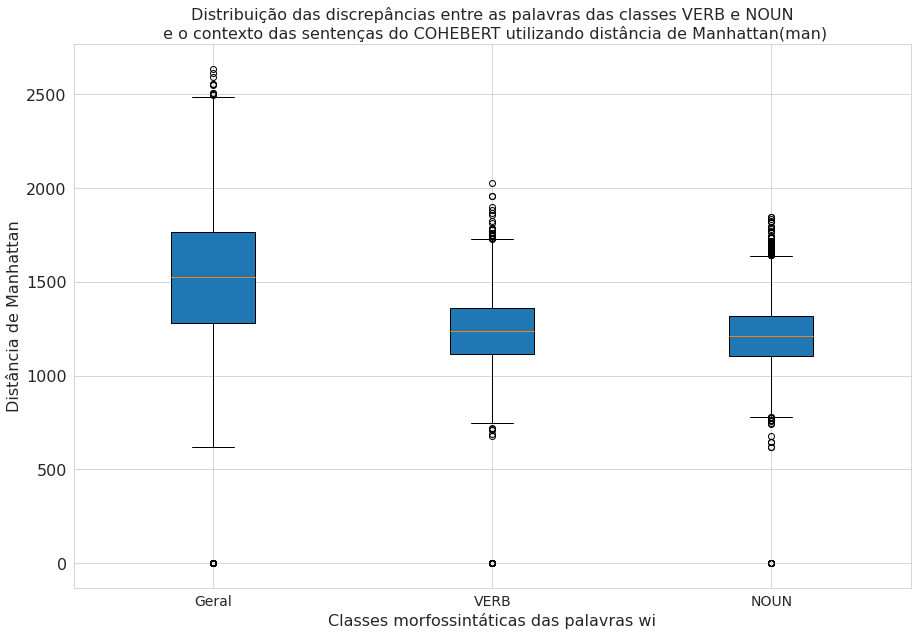

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n e o contexto das sentenças do COHEBERT utilizando distância de Manhattan(man)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

colunas = [lista_comparacao_contexto[["man_ctxverbnoun_mean"]].dropna(), 
           lista_comparacao_classesVV[["man_ctxverbnoun_mean"]].dropna(), 
           lista_comparacao_classesNN[["man_ctxverbnoun_mean"]].dropna()]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

## 3.6 Ocorrências palavras e contexto

### Indexa os dados das comparações pelo id do documento

In [ ]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_comparacao_contexto_indexado = lista_comparacao_contexto.set_index(["id"])
lista_comparacao_contexto_indexado.head()

index_documento  index_sentenca  index_wi          wi  pos_i  \
id                                                                 
1                 0               0         0        Como  SCONJ   
1                 0               0         1  enfileirar   VERB   
1                 0               0         2   elementos   NOUN   
1                 0               0         3          em    ADP   
1                 0               0         4         uma    DET   

    cos_ctxall_mean  euc_ctxall_mean  man_ctxall_mean  cos_ctxclean_mean  \
id                                                                         
1          0.828282        21.519108      1075.545000           0.795338   
1          0.957184        10.615781       524.864750           0.923698   
1          0.803867        26.599089      1214.868700           0.868563   
1          0.871055        20.539904       985.528140           0.828741   
1          0.840564        20.068254       958.674800           0.787430   

    euc_ctxclean_mean  ...  man_ctxclean_max  cos_ctxverb_max  \
id                     ...                                      
1           23.453634  ...       1157.058100         0.759586   
1           13.929335  ...       1131.780200         0.888775   
1           22.597618  ...       1028.900600         0.740469   
1           23.203224  ...       1111.173300         0.796027   
1           23.178740  ...       1096.644800         0.744569   

    euc_ctxverb_max  man_ctxverb_max  cos_ctxnoun_max  euc_ctxnoun_max  \
id                                                                       
1         25.941952      1294.481201         0.680192        29.916761   
1         18.006964       972.863525         0.740781        27.314678   
1         30.121441      1415.033325         0.927326        17.372261   
1         25.312115      1248.880127         0.801384        24.997398   
1         26.130171      1257.120117         0.727427        27.010202   

    man_ctxnoun_max  cos_ctxverbnoun_max  euc_ctxverbnoun_max  \
id                                                              
1       1453.618900             0.733323            26.951654   
1       1333.597400             0.819909            22.602350   
1        782.108460             0.897772            20.224216   
1       1188.405400             0.829802            23.141649   
1       1257.071300             0.760827            24.886763   

    man_ctxverbnoun_max  
id                       
1           1323.588700  
1           1117.259800  
1            922.564500  
1           1105.196000  
1           1168.039700  

[5 rows x 35 columns]

### 3.6.1 Similaridade coseno

#### 3.6.1.1 Organiza as comparações das palavras antes e depois da palavra chave

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Medida
# Para usar outras medidas altere aqui
medida = 'cos' # medidas = {cos, euc, man}

# Estratégia medida
estrategia_medida = 'mean' # medidas = {mean, max}

# Equação medida
equacao_medida = "ctxall" # equação medida = {ctxall, ctxclean, ctxverb, ctxnoun, ctxverbnoun}

# Coluna da medida
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

# Constrói uma lista com as palavras próximas
lista_proximidade = []

# conta comparações
conta = 0

soma_medida = 0

# Barra de progresso dos documentos
lista_documentos_agrupados_bar = tqdm_notebook(lista_documentos_agrupados.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados))

# Percorre os documentos
for i, linha1 in lista_documentos_agrupados_bar:  

  # if i < 5:

    # Lista para as comparações
    lista_proximidade_documento = []

    # Localiza as comparações do documento
    lista_comp = lista_comparacao_contexto_indexado.loc[linha1['id']]
    
    # Percorre as comparações do documento
    for i, linha in lista_comp.iterrows():
      
          # Conta o número de comparações
          conta = conta + 1
            
          # Acumula medida
          soma_medida = soma_medida +  linha[coluna_equacao]

          # Guarda os dados da comparação          
          lista_proximidade_documento.append([linha['wi'],          # 0
                                                    linha['pos_i'],       # 1
                                                    linha[coluna_equacao],# 2
                                                    ])
    
    # Guarda as comparações do documento
    lista_proximidade.append([linha1['id'], lista_proximidade_documento])

print("Número de comparações :", conta)
media = soma_medida / conta
print("Média medida", coluna_equacao, " : ", media)

Documentos:   0%|          | 0/40 [00:00<?, ? documento/s]

Número de comparações : 434
Média medida cos_ctxall_mean  :  0.8090358675212904


#### 3.6.1.2 Seleciona comparações entre palavras onde a similaridade do coseno é maior que um determinado threshold

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Limite da medida
threshold = 0.5

# Dicionário para guardar as ocorrências de comparações
frequencia_ocorrencia_palavra = {}

# Barra de progresso das proximidades
lista_proximidade_bar = tqdm_notebook(enumerate(lista_proximidade), desc=f"Comparações", unit=f" comparação", total=len(lista_proximidade))

# Percorre a lista de comparações com a chave
for i, linha1 in lista_proximidade_bar:
  # if i < 5:

    # Verifica se existe comparações 
    if len(linha1[1]) != 0:

      # Percorre as comparações 
      for j, linha2 in enumerate(linha1[1]):
          
        # Compara a medida se está acima do Threshold
        if linha2[2] >= threshold:

            # Monta a chave do dicionário
            chave = linha2[0] + "(" + linha2[1] + ") "

            # Recupera a chave para atualizar o valor
            if chave in frequencia_ocorrencia_palavra:
              valor = frequencia_ocorrencia_palavra.get(chave)
              frequencia_ocorrencia_palavra.update({chave: valor + 1})
            
            else:
              # Atualiza a chave com valor 1 se não existir
              frequencia_ocorrencia_palavra.update({chave: 1})

Comparações:   0%|          | 0/40 [00:00<?, ? comparação/s]

#### 3.6.1.3 Lista as 20 maiores ocorrências de palavras com similaridade acima do threshold com o contexto

In [ ]:
top = 20

print("Lista ordenada das ", top, " maiores ocorrências ordenadas de palavras comparadas com o contexto")
print("usando medida", medida ,",estratégia", estrategia_medida, "e equação", equacao_medida,"acima do threshold com o contexto")

# Lista as ocorrências das palavras
for i, item in enumerate(sorted(frequencia_ocorrencia_palavra, key = frequencia_ocorrencia_palavra.get, reverse=True)):
  if i < top:
    print (i+1, item, frequencia_ocorrencia_palavra[item])

Lista ordenada das  20  maiores ocorrências ordenadas de palavras comparadas com o contexto
usando medida cos ,estratégia mean e equação ctxall acima do threshold com o contexto
1 uma(DET)  40
2 ?(PUNCT)  40
3 elementos(NOUN)  24
4 em(ADP)  24
5 fila(NOUN)  20
6 pilha(NOUN)  20
7 e(CCONJ)  19
8 empilhar(VERB)  18
9 O(PRON)  16
10 que(PRON)  16
11 é(AUX)  16
12 como(ADV)  14
13 Como(SCONJ)  12
14 enfileirar(VERB)  12
15 elemento(NOUN)  12
16 desempilhar(NOUN)  8
17 um(DET)  8
18 nela(PRON)  8
19 de(SCONJ)  8
20 desempilhar(VERB)  6


### 3.6.2 Distância Euclidiana

#### 3.6.2.1 Organiza as comparações das palavras antes e depois da palavra chave

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Medida
# Para usar outras medidas altere aqui
medida = 'euc' # medidas = {cos, euc, man}

# Estratégia medida
estrategia_medida = 'mean' # medidas = {mean, max}

# Equação medida
equacao_medida = "ctxall" # equação medida = {ctxall, ctxclean, ctxverb, ctxnoun, ctxverbnoun}

# Coluna da medida
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

# Constrói uma lista com as palavras próximas
lista_proximidade = []

# conta comparações
conta = 0

soma_medida = 0

# Barra de progresso dos documentos
lista_documentos_agrupados_bar = tqdm_notebook(lista_documentos_agrupados.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados))

# Percorre os documentos
for i, linha1 in lista_documentos_agrupados_bar:  

  # if i < 5:

    # Lista para as comparações
    lista_proximidade_documento = []

    # Localiza as comparações do documento
    lista_comp = lista_comparacao_contexto_indexado.loc[linha1['id']]
    
    # Percorre as comparações do documento
    for i, linha in lista_comp.iterrows():
      
          # Conta o número de comparações
          conta = conta + 1
            
          # Acumula medida
          soma_medida = soma_medida +  linha[coluna_equacao]

          # Guarda os dados da comparação          
          lista_proximidade_documento.append([linha['wi'],          # 0
                                                    linha['pos_i'],       # 1
                                                    linha[coluna_equacao],# 2
                                                    ])
    
    # Guarda as comparações do documento
    lista_proximidade.append([linha1['id'], lista_proximidade_documento])

print("Número de comparações :", conta)
media = soma_medida / conta
print("Média medida", coluna_equacao, " : ", media)

Documentos:   0%|          | 0/40 [00:00<?, ? documento/s]

Número de comparações : 434
Média medida euc_ctxall_mean  :  22.545366594868323


#### 3.6.2.2 Seleciona comparações entre palavras onde a similaridade do coseno é maior que um determinado threshold

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Limite da medida
threshold = 0.5

# Dicionário para guardar as ocorrências de comparações
frequencia_ocorrencia_palavra = {}

# Barra de progresso das proximidades
lista_proximidade_bar = tqdm_notebook(enumerate(lista_proximidade), desc=f"Comparações", unit=f" comparação", total=len(lista_proximidade))

# Percorre a lista de comparações com a chave
for i, linha1 in lista_proximidade_bar:
  # if i < 5:

    # Verifica se existe comparações
    if len(linha1[1]) != 0:

      # Percorre as comparações
      for j, linha2 in enumerate(linha1[1]):
          
        # Compara a medida se está acima do Threshold
        if linha2[2] >= threshold:

            # Monta a chave do dicionário
            chave = linha2[0] + "(" + linha2[1] + ") "

            # Recupera a chave para atualizar o valor
            if chave in frequencia_ocorrencia_palavra:
              valor = frequencia_ocorrencia_palavra.get(chave)
              frequencia_ocorrencia_palavra.update({chave: valor + 1})
            
            else:
              # Atualiza a chave com valor 1 se não existir
              frequencia_ocorrencia_palavra.update({chave: 1})

Comparações:   0%|          | 0/40 [00:00<?, ? comparação/s]

#### 3.6.2.3 Lista as 20 maiores ocorrências de palavras com similaridade acima do threshold com o contexto

In [ ]:
top = 20

print("Lista ordenada das ", top, " maiores ocorrências ordenadas de palavras comparadas com o contexto")
print("usando medida", medida ,",estratégia", estrategia_medida, "e equação", equacao_medida,"acima do threshold com o contexto")

# Lista as ocorrências das palavras
for i, item in enumerate(sorted(frequencia_ocorrencia_palavra, key = frequencia_ocorrencia_palavra.get, reverse=True)):
  if i < top:
    print (i+1, item, frequencia_ocorrencia_palavra[item])

Lista ordenada das  20  maiores ocorrências ordenadas de palavras comparadas com o contexto
usando medida euc ,estratégia mean e equação ctxall acima do threshold com o contexto
1 uma(DET)  40
2 ?(PUNCT)  40
3 e(CCONJ)  28
4 elementos(NOUN)  24
5 em(ADP)  24
6 fila(NOUN)  20
7 pilha(NOUN)  20
8 empilhar(VERB)  18
9 O(PRON)  16
10 que(PRON)  16
11 é(AUX)  16
12 como(ADV)  14
13 Como(SCONJ)  12
14 enfileirar(VERB)  12
15 elemento(NOUN)  12
16 desempilhar(NOUN)  8
17 um(DET)  8
18 nela(PRON)  8
19 de(SCONJ)  8
20 desempilhar(VERB)  6


### 3.6.3 Distância de Manhattan

#### 3.6.3.1 Organiza as comparações das palavras antes e depois da palavra chave

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Medida
# Para usar outras medidas altere aqui
medida = 'man' # medidas = {cos, euc, man}

# Estratégia medida
estrategia_medida = 'mean' # medidas = {mean, max}

# Equação medida
equacao_medida = "ctxall" # equação medida = {ctxall, ctxclean, ctxverb, ctxnoun, ctxverbnoun}

# Coluna da medida
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

# Constrói uma lista com as palavras próximas
lista_proximidade = []

# conta comparações
conta = 0

soma_medida = 0

# Barra de progresso dos documentos
lista_documentos_agrupados_bar = tqdm_notebook(lista_documentos_agrupados.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados))

# Percorre os documentos
for i, linha1 in lista_documentos_agrupados_bar:  

  # if i < 5:

    # Lista para as comparações
    lista_proximidade_documento = []

    # Localiza as comparações do documento
    lista_comp = lista_comparacao_contexto_indexado.loc[linha1['id']]
    
    # Percorre as comparações do documento
    for i, linha in lista_comp.iterrows():
      
          # Conta o número de comparações
          conta = conta + 1
            
          # Acumula medida
          soma_medida = soma_medida +  linha[coluna_equacao]

          # Guarda os dados da comparação          
          lista_proximidade_documento.append([linha['wi'],          # 0
                                                    linha['pos_i'],       # 1
                                                    linha[coluna_equacao],# 2
                                                    ])
    
    # Guarda as comparações do documento
    lista_proximidade.append([linha1['id'], lista_proximidade_documento])

print("Número de comparações :", conta)
media = soma_medida / conta
print("Média medida", coluna_equacao, " : ", media)

Documentos:   0%|          | 0/40 [00:00<?, ? documento/s]

Número de comparações : 434
Média medida man_ctxall_mean  :  1079.1845001382487


#### 3.6.3.2 Seleciona comparações entre palavras onde a similaridade do coseno é maior que um determinado threshold

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Limite da medida
threshold = 0.5

# Dicionário para guardar as ocorrências de comparações
frequencia_ocorrencia_palavra = {}

# Barra de progresso das proximidades
lista_proximidade_bar = tqdm_notebook(enumerate(lista_proximidade), desc=f"Comparações", unit=f" comparação", total=len(lista_proximidade))

# Percorre a lista de comparações com a chave
for i, linha1 in lista_proximidade_bar:
  # if i < 5:

    # Verifica se existe comparações
    if len(linha1[1]) != 0:

      # Percorre as comparações
      for j, linha2 in enumerate(linha1[1]):
          
        # Compara a medida se está acima do Threshold
        if linha2[2] >= threshold:

            # Monta a chave do dicionário
            chave = linha2[0] + "(" + linha2[1] + ") "

            # Recupera a chave para atualizar o valor
            if chave in frequencia_ocorrencia_palavra:
              valor = frequencia_ocorrencia_palavra.get(chave)
              frequencia_ocorrencia_palavra.update({chave: valor + 1})
            
            else:
              # Atualiza a chave com valor 1 se não existir
              frequencia_ocorrencia_palavra.update({chave: 1})

Comparações:   0%|          | 0/40 [00:00<?, ? comparação/s]

#### 3.6.3.3 Lista as 20 maiores ocorrências de palavras com similaridade acima do threshold com o contexto

In [ ]:
top = 20

print("Lista ordenada das ", top, " maiores ocorrências ordenadas de palavras comparadas com o contexto")
print("usando medida", medida ,",estratégia", estrategia_medida, "e equação", equacao_medida,"acima do threshold com o contexto")

# Lista as ocorrências das palavras
for i, item in enumerate(sorted(frequencia_ocorrencia_palavra, key = frequencia_ocorrencia_palavra.get, reverse=True)):
  if i < top:
    print (i+1, item, frequencia_ocorrencia_palavra[item])

Lista ordenada das  20  maiores ocorrências ordenadas de palavras comparadas com o contexto
usando medida man ,estratégia mean e equação ctxall acima do threshold com o contexto
1 uma(DET)  40
2 ?(PUNCT)  40
3 e(CCONJ)  28
4 elementos(NOUN)  24
5 em(ADP)  24
6 fila(NOUN)  20
7 pilha(NOUN)  20
8 empilhar(VERB)  18
9 O(PRON)  16
10 que(PRON)  16
11 é(AUX)  16
12 como(ADV)  14
13 Como(SCONJ)  12
14 enfileirar(VERB)  12
15 elemento(NOUN)  12
16 desempilhar(NOUN)  8
17 um(DET)  8
18 nela(PRON)  8
19 de(SCONJ)  8
20 desempilhar(VERB)  6


# 4 Finalização

## 4.1 Tempo final de processamento



In [ ]:
# Pega o tempo atual menos o tempo do início do processamento.
final_processamento = time.time()
tempo_total_processamento = formataTempo(final_processamento - inicio_processamento)

print("")
print("  Tempo processamento:  {:} (h:mm:ss)".format(tempo_total_processamento))


  Tempo processamento:  0:02:38 (h:mm:ss)
